[2023 연구개발특구 AI SPARK 챌린지 - 공기압축기 이상 판단](https://aifactory.space/competition/data/2226)

# 파일 구성

data.zip
- train_data.csv : 학습용 데이터 파일
  - 모두 **정상 case**로 이루어진 데이터
- test_data.csv : 평가용 데이터 파일
  - **정상 case**와 **이상 case**가 함께 포함되어 있는 데이터
- answer_sample.csv : 정답 양식 파일

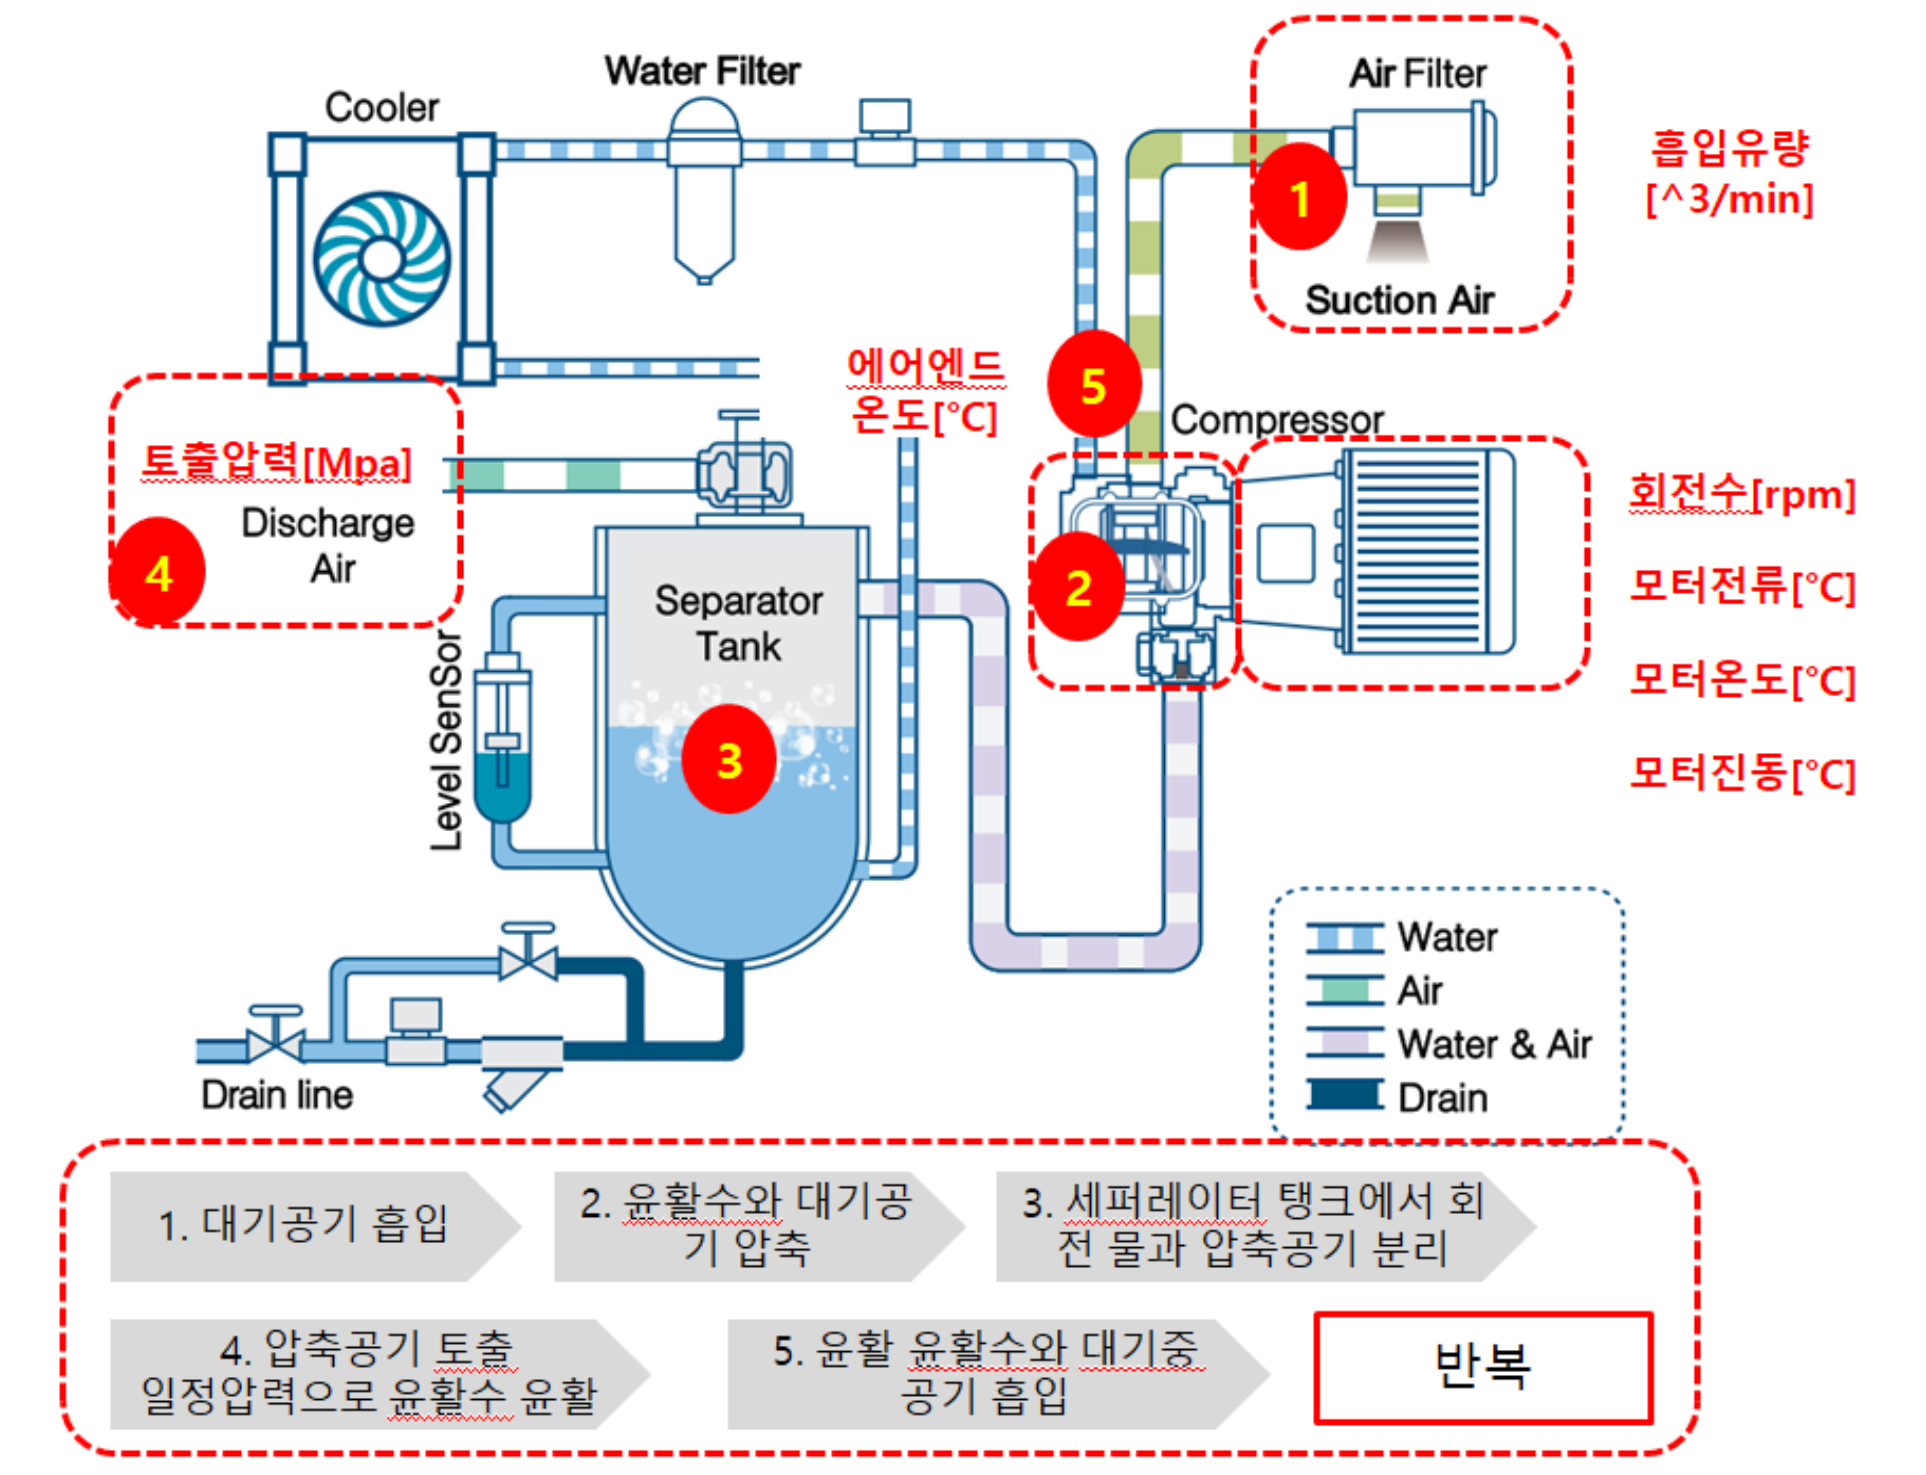

- air_inflow: 공기 흡입 유량 (^3/min)
- air_end_temp: 공기 말단 온도 (°C)
- out_pressure: 토출 압력 (Mpa)
- motor_current: 모터 전류 (A)
- motor_rpm: 모터 회전수 (rpm)
- motor_temp: 모터 온도 (°C)
- motor_vibe: 모터 진동 (mm/s)
- type: 설비 번호

- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
- 설비 번호 1: 20HP
- 설비 번호 2: 10HP
- 설비 번호 3: 50HP

# 데이터 확인

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
from matplotlib.lines import Line2D
from sklearn.cluster import DBSCAN

In [347]:
submission = pd.read_csv('dataset/answer_sample.csv')

In [2]:
train_data = pd.read_csv('dataset/train_data.csv')
test_data = pd.read_csv('dataset/test_data.csv')
submission = pd.read_csv('dataset/answer_sample.csv')

In [3]:
# train_data 확인해봅니다.
train_data.head()

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0        1.59         41.00           0.7          20.53     1680.0   
1        2.97         59.28           0.7          38.40     3142.0   
2        1.91         45.29           0.7          24.73     2023.0   
3        2.37         51.33           0.7          30.63     2506.0   
4        1.90         45.21           0.7          24.65     2017.0   

   motor_temp  motor_vibe  type  
0       58.67        2.93     0  
1       74.91        3.75     0  
2       62.48        3.12     0  
3       67.84        3.39     0  
4       62.41        3.12     0

In [4]:
# test_data 확인해봅니다.
test_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           2.51         53.28           0.7          32.54     2662.0   
1           2.66         55.24           0.7          34.45     2819.0   
2           1.72         42.74           0.7          22.23     1819.0   
3           2.20         49.15           0.7          28.50     2332.0   
4           2.06         47.28           0.7          26.67     2182.0   
...          ...           ...           ...            ...        ...   
7384        2.12         48.08           0.7          27.45     2246.0   
7385        1.48         39.63           0.7          19.19     1570.0   
7386        1.56         40.61           0.7          20.15     1649.0   
7387        1.59         40.99           0.7          20.52     1679.0   
7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type  
0          69.58        3.48     0  
1          71.32        3.57     0  
2          60.21        3.01     0  
3          65.91        3.30     0  
4          64.24        3.21     0  
...          ...         ...   ...  
7384       64.96        3.25     7  
7385       57.44        2.87     7  
7386       58.32        2.92     7  
7387       58.66        2.93     7  
7388       60.01        3.00     7  

[7389 rows x 8 columns]

In [5]:
# 정상인지 아닌지를 구별합니다. 
submission.head()

type  label
0     0     -1
1     0     -1
2     0     -1
3     0     -1
4     0     -1

train_data와 test_data에는 label이라는 특성이 존재하지 않습니다. 즉 비지도 학습입니다. train_data는 정상으로 이뤄진 data이고, test_data는 비정상 data가 섞여 있습니다. 즉 정상인지 비정상인지 나누는 문제이므로 **분류**에 포함될 수 있으며 0(정상) 또는 1(이상)으로 분류되기 때문에 **이진분류**라고 볼 수 있습니다.

---
train_data는 전부 정상 case이기 때문에, train_data만으로는 data를 분석하기가 어렵습니다. 따라서 test_data와 train_data를 합쳐서 이상치와 정상치가 어떤 부분에서 다른지 쉽게 확인할 수 있도록 만드는 것이 더 좋다고 판단하였습니다.

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463 entries, 0 to 2462
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     2463 non-null   float64
 1   air_end_temp   2463 non-null   float64
 2   out_pressure   2463 non-null   float64
 3   motor_current  2463 non-null   float64
 4   motor_rpm      2463 non-null   float64
 5   motor_temp     2463 non-null   float64
 6   motor_vibe     2463 non-null   float64
 7   type           2463 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 154.1 KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7389 entries, 0 to 7388
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     7389 non-null   float64
 1   air_end_temp   7389 non-null   float64
 2   out_pressure   7389 non-null   float64
 3   motor_current  7389 non-null   float64
 4   motor_rpm      7389 non-null   float64
 5   motor_temp     7389 non-null   float64
 6   motor_vibe     7389 non-null   float64
 7   type           7389 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 461.9 KB


In [15]:
train_data['data_type'] = 'train'

In [16]:
test_data['data_type'] = 'test'

train_data와 test_data 둘 다 결측치가 없는 것을 확인하였습니다.

# EDA (Exploratory Data Analysis, 탐색적 데이터 분석)

In [17]:
# train_data와 test_data를 합쳐서 새로운 data를 만듭니다.
sum_data = pd.concat([train_data, test_data]).reset_index()
sum_data

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0         0        1.59         41.00           0.7          20.53     1680.0   
1         1        2.97         59.28           0.7          38.40     3142.0   
2         2        1.91         45.29           0.7          24.73     2023.0   
3         3        2.37         51.33           0.7          30.63     2506.0   
4         4        1.90         45.21           0.7          24.65     2017.0   
...     ...         ...           ...           ...            ...        ...   
9847   7384        2.12         48.08           0.7          27.45     2246.0   
9848   7385        1.48         39.63           0.7          19.19     1570.0   
9849   7386        1.56         40.61           0.7          20.15     1649.0   
9850   7387        1.59         40.99           0.7          20.52     1679.0   
9851   7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type data_type  
0          58.67        2.93     0     train  
1          74.91        3.75     0     train  
2          62.48        3.12     0     train  
3          67.84        3.39     0     train  
4          62.41        3.12     0     train  
...          ...         ...   ...       ...  
9847       64.96        3.25     7      test  
9848       57.44        2.87     7      test  
9849       58.32        2.92     7      test  
9850       58.66        2.93     7      test  
9851       60.01        3.00     7      test  

[9852 rows x 10 columns]

In [18]:
sum_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9852 non-null   int64  
 1   air_inflow     9852 non-null   float64
 2   air_end_temp   9852 non-null   float64
 3   out_pressure   9852 non-null   float64
 4   motor_current  9852 non-null   float64
 5   motor_rpm      9852 non-null   float64
 6   motor_temp     9852 non-null   float64
 7   motor_vibe     9852 non-null   float64
 8   type           9852 non-null   int64  
 9   data_type      9852 non-null   object 
dtypes: float64(7), int64(2), object(1)
memory usage: 769.8+ KB


In [19]:
sum_data.describe()

index   air_inflow  air_end_temp  out_pressure  motor_current  \
count  9852.000000  9852.000000   9852.000000   9852.000000    9852.000000   
mean   3078.250000     2.109557     49.032336      0.699880      27.436130   
std    2162.552668     1.173689      8.695520      0.004657      13.327023   
min       0.000000     0.330000     32.030000      0.490000       5.340000   
25%    1231.000000     1.280000     41.525000      0.700000      17.170000   
50%    2462.500000     1.940000     48.805000      0.700000      26.035000   
75%    4925.250000     2.780000     56.502500      0.700000      35.950000   
max    7388.000000     6.240000     65.540000      0.700000      74.000000   

         motor_rpm   motor_temp   motor_vibe         type  
count  9852.000000  9852.000000  9852.000000  9852.000000  
mean   2373.509237    65.770394     3.372385     2.957369  
std     687.735877     7.755034     0.966673     2.229774  
min    1200.000000    50.360000     1.970000     0.000000  
25%    1776.000000    59.120000     2.890000     1.000000  
50%    2356.000000    65.575000     3.260000     3.000000  
75%    2972.000000    72.420000     3.730000     5.000000  
max    3564.000000    82.390000    21.870000     7.000000

설비 번호에 따라 장비 성능이 매우 다르기 때문에 EDA할 때, 설비 번호를 유심히 살펴보도록 하겠습니다.

air_inflow는 공기 흡입 유량입니다. box plot을 하여 data 분포를 한 눈에 살펴보겠습니다.



In [11]:
# box_plot 함수를 정의합니다.
def box_plot(data, title=""):
  plt.figure(figsize=(3,5))
  g = sns.boxplot(data=pd.DataFrame(data), showfliers=False)
  g.set_title(title, size=10)
  g.set_xticklabels(g.get_xticklabels())
  plt.show()

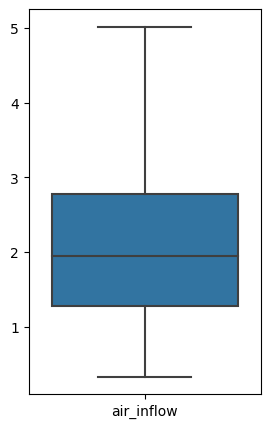

In [12]:
box_plot(pd.DataFrame(sum_data['air_inflow']), "")

air_inflow는 대체로 균일해보입니다. 이번에는 설비 번호에 나눠서 분석해보겠습니다. 설비 번호는 0~7까지의 정수형 입니다.

In [13]:
sum_data

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0         0        1.59         41.00           0.7          20.53     1680.0   
1         1        2.97         59.28           0.7          38.40     3142.0   
2         2        1.91         45.29           0.7          24.73     2023.0   
3         3        2.37         51.33           0.7          30.63     2506.0   
4         4        1.90         45.21           0.7          24.65     2017.0   
...     ...         ...           ...           ...            ...        ...   
9847   7384        2.12         48.08           0.7          27.45     2246.0   
9848   7385        1.48         39.63           0.7          19.19     1570.0   
9849   7386        1.56         40.61           0.7          20.15     1649.0   
9850   7387        1.59         40.99           0.7          20.52     1679.0   
9851   7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type  
0          58.67        2.93     0  
1          74.91        3.75     0  
2          62.48        3.12     0  
3          67.84        3.39     0  
4          62.41        3.12     0  
...          ...         ...   ...  
9847       64.96        3.25     7  
9848       57.44        2.87     7  
9849       58.32        2.92     7  
9850       58.66        2.93     7  
9851       60.01        3.00     7  

[9852 rows x 9 columns]

In [14]:
data0 = sum_data[sum_data['type'] == 0]
data1 = sum_data[sum_data['type'] == 1]
data2 = sum_data[sum_data['type'] == 2]
data3 = sum_data[sum_data['type'] == 3]
data4 = sum_data[sum_data['type'] == 4]
data5 = sum_data[sum_data['type'] == 5]
data6 = sum_data[sum_data['type'] == 6]
data7 = sum_data[sum_data['type'] == 7]
data7

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
2277   2277        1.97         46.14           0.7          25.56     2091.0   
2278   2278        2.60         54.36           0.7          33.60     2749.0   
2279   2279        2.12         48.01           0.7          27.39     2241.0   
2280   2280        1.13         35.01           0.7          14.68     1201.0   
2281   2281        1.91         45.25           0.7          24.69     2020.0   
...     ...         ...           ...           ...            ...        ...   
9847   7384        2.12         48.08           0.7          27.45     2246.0   
9848   7385        1.48         39.63           0.7          19.19     1570.0   
9849   7386        1.56         40.61           0.7          20.15     1649.0   
9850   7387        1.59         40.99           0.7          20.52     1679.0   
9851   7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type  
2277       63.23        3.16     7  
2278       70.54        3.53     7  
2279       64.90        3.25     7  
2280       53.34        2.67     7  
2281       62.44        3.12     7  
...          ...         ...   ...  
9847       64.96        3.25     7  
9848       57.44        2.87     7  
9849       58.32        2.92     7  
9850       58.66        2.93     7  
9851       60.01        3.00     7  

[744 rows x 9 columns]

In [20]:
# type별로 box plot 하기
def box_plot_per_type(data, name):
  plt.figure(figsize=(5,7))
  j = 0
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type']==i][name]
    plt.subplot(2,4,i+1)
    color = ['green', 'yellow', 'red']
    if i == 1 or i == 2 or i == 3:
      g = sns.boxplot(data=pd.DataFrame(globals()['data{}'.format(i)]), showfliers=False, color = color[j])
      j += 1
    else :
      g = sns.boxplot(data=pd.DataFrame(globals()['data{}'.format(i)]), showfliers=False)
    g.set_title("type = {}".format(i), size=10)
    g.set_xticklabels(g.get_xticklabels())
  plt.tight_layout()
  plt.show()

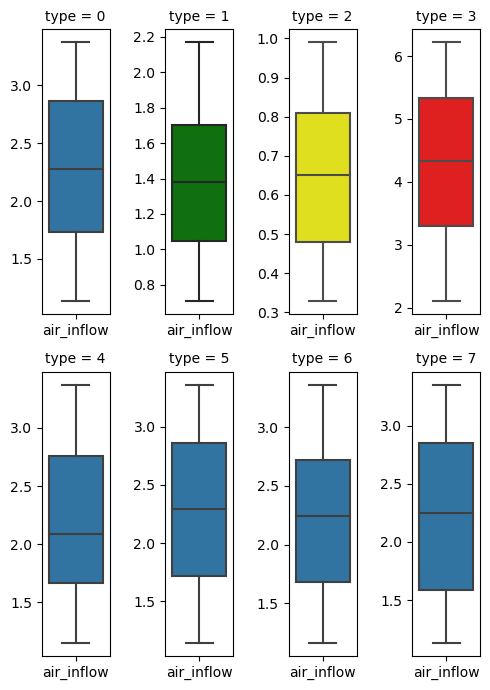

In [21]:
box_plot_per_type(train_data, "air_inflow")

역시 예상했던대로 type에 따라서 air_inflow가 다름을 볼 수 있습니다! 특히 설비 번호 0, 4, 5, 6, 7은 30HP(마력)이고 1은 20HP, 2는 10HP, 3은 50HP인데, 마력에 따라 공기 흡입 유량의 차이가 있다는 것을 볼 수 있습니다.

다른 특성도 그러한지 보겠습니다.

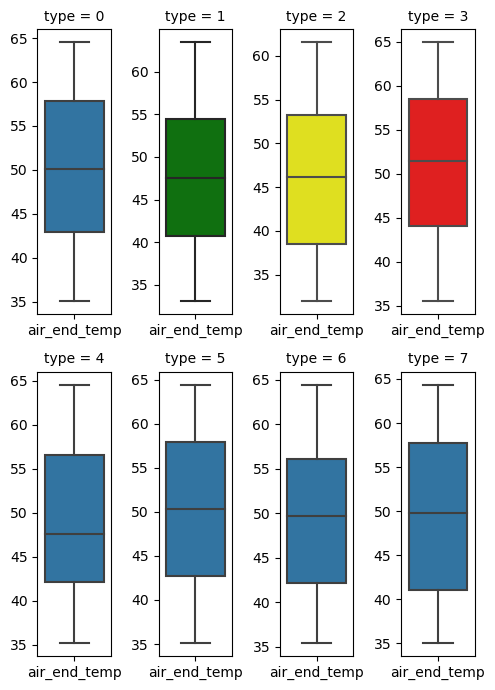

In [22]:
box_plot_per_type(train_data, "air_end_temp")

air_end_temp는 type=1과 type=2에서 약간 달라질 뿐 크게 달라지는 것은 없어 보입니다.

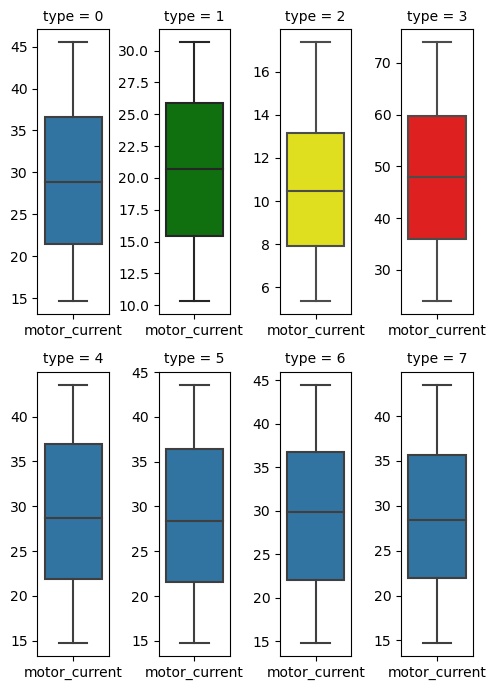

In [23]:
box_plot_per_type(test_data, "motor_current")

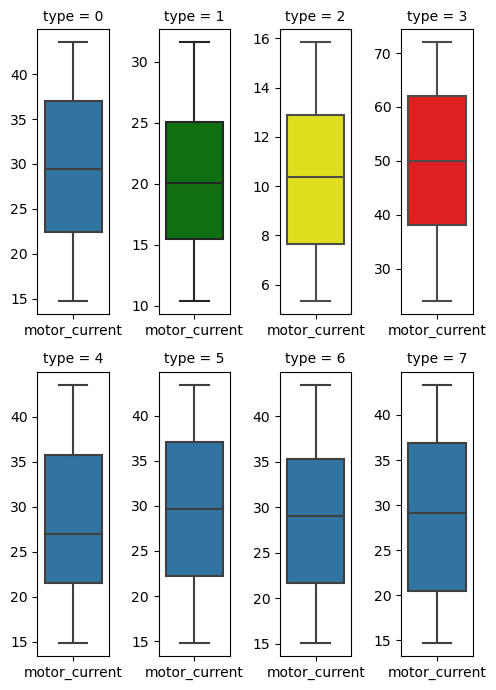

In [24]:
box_plot_per_type(train_data, "motor_current")

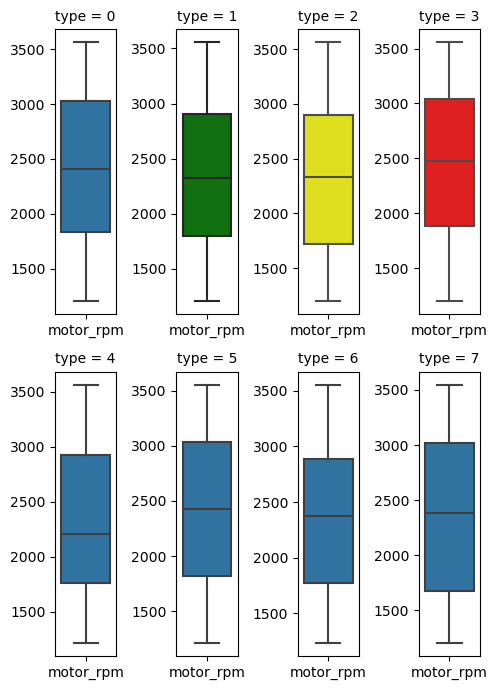

In [25]:
box_plot_per_type(train_data, "motor_rpm")

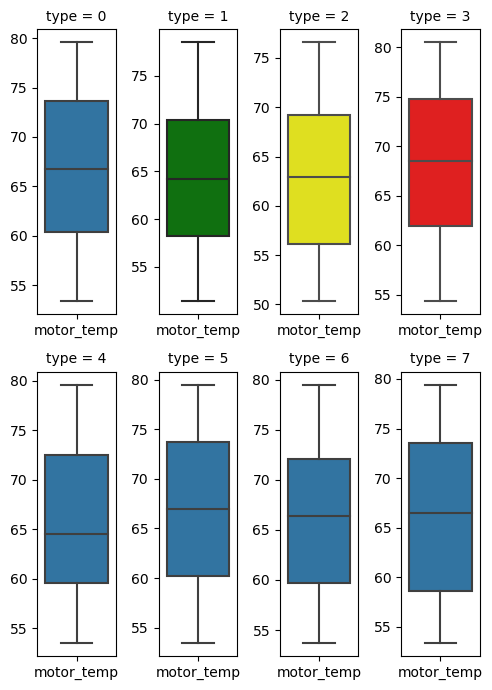

In [26]:
box_plot_per_type(train_data, "motor_temp")

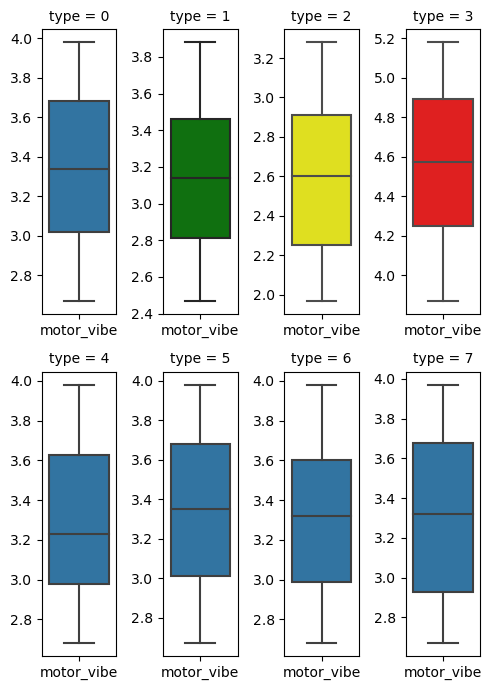

In [27]:
box_plot_per_type(train_data, "motor_vibe")

out_pressure 특성은 특이하게도 train_data에서는 전부 0.7입니다. 즉 정상인 장치는 전부 out_pressure가 0.7이라 봐도 무방할 정도로 한정된 값을 가집니다.

In [28]:
train_data['out_pressure'].describe()

count    2.463000e+03
mean     7.000000e-01
std      2.964897e-14
min      7.000000e-01
25%      7.000000e-01
50%      7.000000e-01
75%      7.000000e-01
max      7.000000e-01
Name: out_pressure, dtype: float64

하지만 test_data에서는 0.7이 아닌 값도 존재합니다. out_pressure가 0.7이 아닌 장비는 유심히 살펴봐야겠네요.

In [29]:
test_data[test_data['out_pressure'] != 0.7]['out_pressure']

4917    0.60
4918    0.60
4919    0.54
4920    0.50
4921    0.50
4922    0.49
4923    0.49
Name: out_pressure, dtype: float64

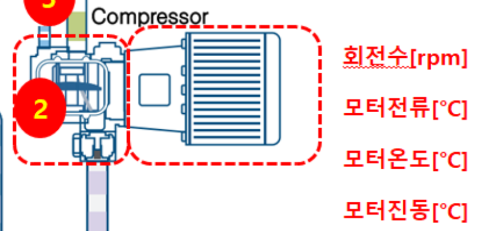

마력의 크기 순서는 다음과 같습니다.

설비 번호 2 < 설비 번호 1 < 설비 번호 0, 4, 5, 6, 7 < 설비 번호 3 


마력이 크면 클 수록 air_inflow는 커지며 motor_current, motor_rpm, motor_vibe 또한 커지는 것을 볼 수 있습니다. 이 특성들은 확연하게 커지는 것을 볼 수 있으며 다른 특성들은 type에 따라 달라지긴 하지만 type = 3와 type 0, 4, 5, 6, 7과는 크게 달라지는 것은 없어 보입니다.

box_plot을 통해 마력에 따라 특성이 달라지는 것을 보았으니 type으로 data를 나누어 특성간 상관계수 분석을 진행하겠습니다.

In [30]:
# train_data 분리

for i in range(8):
  globals()['train_data{}'.format(i)] = train_data[train_data['type'] == i]

# test_data 분리
for i in range(8):
  globals()['test_data{}'.format(i)] = test_data[test_data['type'] == i]

# sum_data 분리
for i in range(8):
  globals()['sum_data{}'.format(i)] = sum_data[sum_data['type'] == i]

In [31]:
# data 확인
train_data0

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0          1.59         41.00           0.7          20.53     1680.0   
1          2.97         59.28           0.7          38.40     3142.0   
2          1.91         45.29           0.7          24.73     2023.0   
3          2.37         51.33           0.7          30.63     2506.0   
4          1.90         45.21           0.7          24.65     2017.0   
..          ...           ...           ...            ...        ...   
427        1.32         37.49           0.7          17.10     1399.0   
428        1.80         43.85           0.7          23.32     1908.0   
429        2.79         56.99           0.7          36.17     2959.0   
430        2.25         49.79           0.7          29.13     2383.0   
431        1.52         40.15           0.7          19.70     1612.0   

     motor_temp  motor_vibe  type data_type  
0         58.67        2.93     0     train  
1         74.91        3.75     0     train  
2         62.48        3.12     0     train  
3         67.84        3.39     0     train  
4         62.41        3.12     0     train  
..          ...         ...   ...       ...  
427       55.54        2.78     0     train  
428       61.20        3.06     0     train  
429       72.88        3.64     0     train  
430       66.48        3.32     0     train  
431       57.91        2.90     0     train  

[432 rows x 9 columns]

이제 다른 특성들간의 상관계수를 분석할 수 있도록 함수를 지정해보겠습니다.

In [32]:
def plot_corr(data, name1, name2):
  plt.figure(figsize=(7,5))
  correlation = data[name1].corr(data[name2])
  j = 0
  color = ['green', 'yellow', 'red']
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type'] == i]
    if i == 1 or i == 2 or i == 3:
      sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue')
  plt.title('correlation: ' + str(np.round(correlation, 2)), fontsize=20)
  plt.xlabel(name1, fontsize=12)
  plt.ylabel(name2, fontsize=12)
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  plt.show()

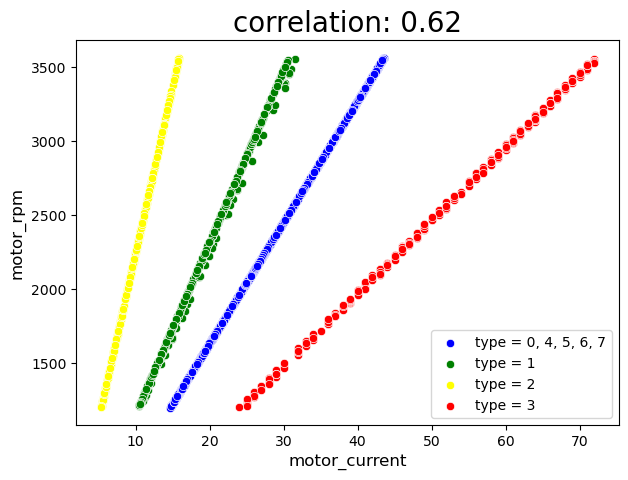

In [33]:
# train_data에서 모터 전류와 모터 회전수간의 관계
plot_corr(train_data, 'motor_current', 'motor_rpm')

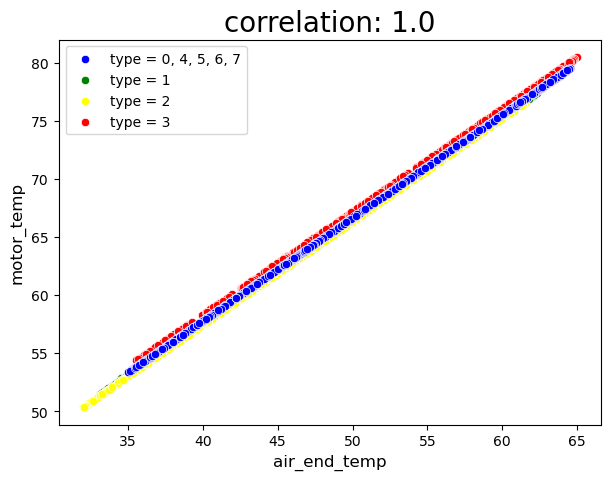

In [34]:
# train_data에서 공기 말단 온도와 모터 온도간의 관계
plot_corr(train_data, 'air_end_temp', 'motor_temp')

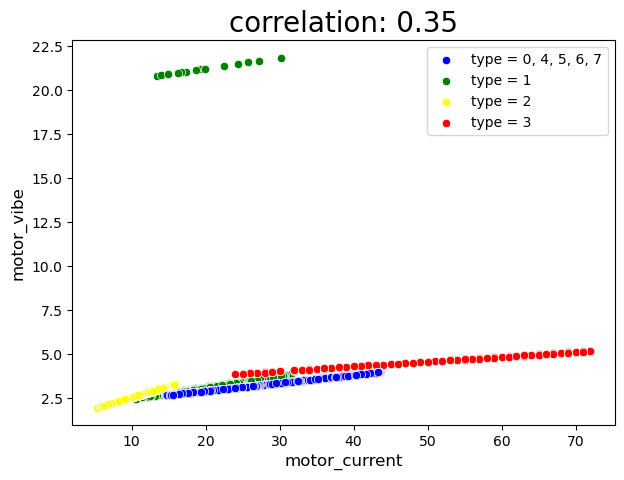

In [35]:
# train_data에서 모터 전류와 모터 진동간의 관계
plot_corr(train_data, 'motor_current','motor_vibe')

모터 전류와 모터 진동간의 관계 그래프인데, 유난히 모터 진동이 큰 저 값들이 신경쓰입니다.

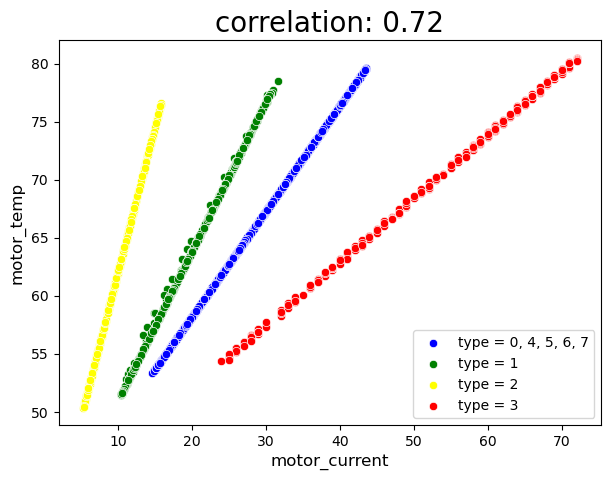

In [36]:
# train_data에서 모터 전류와 모터 온도간의 관계
plot_corr(train_data, 'motor_current','motor_temp')

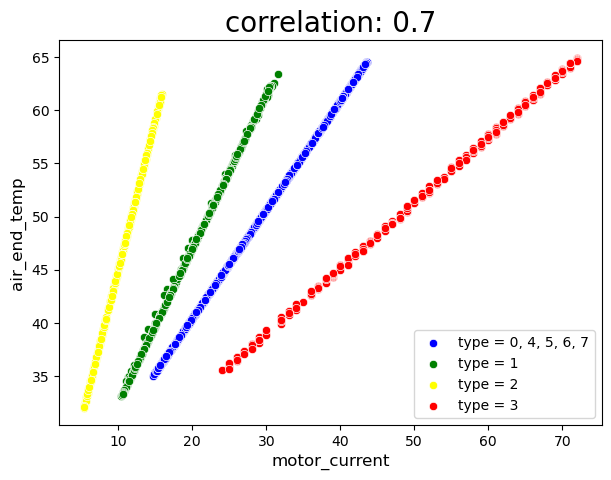

In [37]:
# train_data에서 모터 전류와 공기 말단 온도간의 관계
plot_corr(train_data, 'motor_current','air_end_temp')

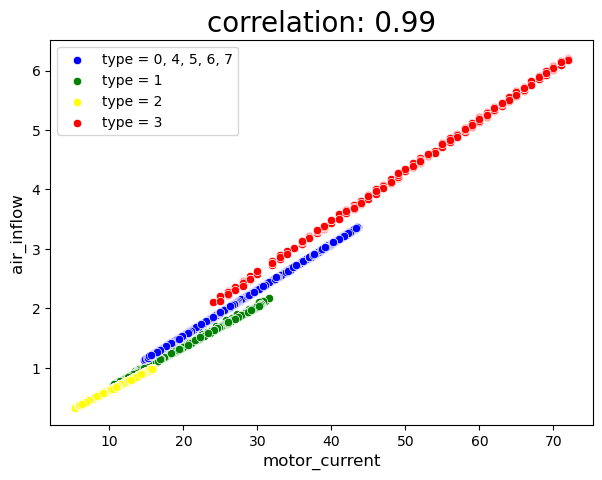

In [38]:
# train_data에서 모터 전류와 공기 흡입 유량간의 관계
plot_corr(train_data, 'motor_current','air_inflow')

<font color="red">엄청난 선형관계를 볼 수 있습니다.</font>

motor_current(모터 전류)가 증가하면 증가할수록 motor_vibe(모터 진동), motor_temp(모터 온도), motor_rpm(모터 회전수), air_inflow(공기 흡입 유량)이 증가하는 것을 볼 수 있습니다.

---
이제 이상치가 포함된 test_data를 확인해보겠습니다.

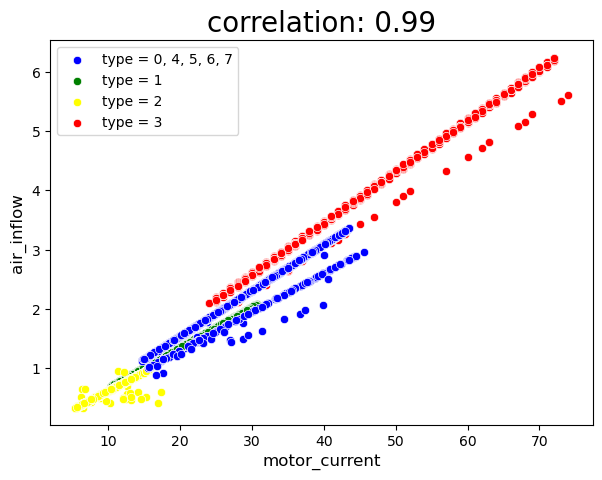

In [39]:
# test_data에서 모터 전류와 모터 진동간의 관계
plot_corr(test_data, 'motor_current', 'air_inflow')

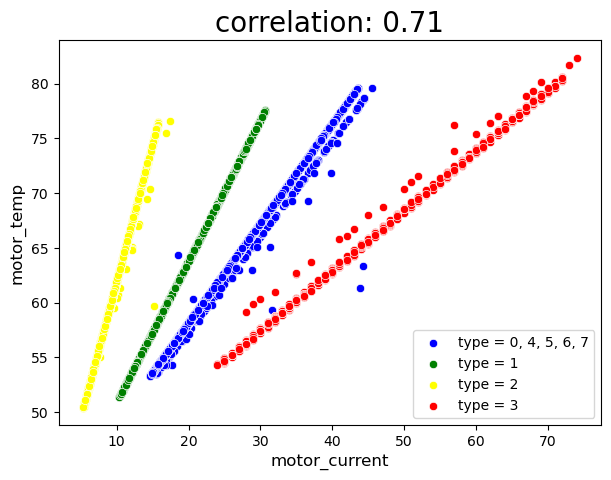

In [40]:
plot_corr(test_data, 'motor_current', 'motor_temp')

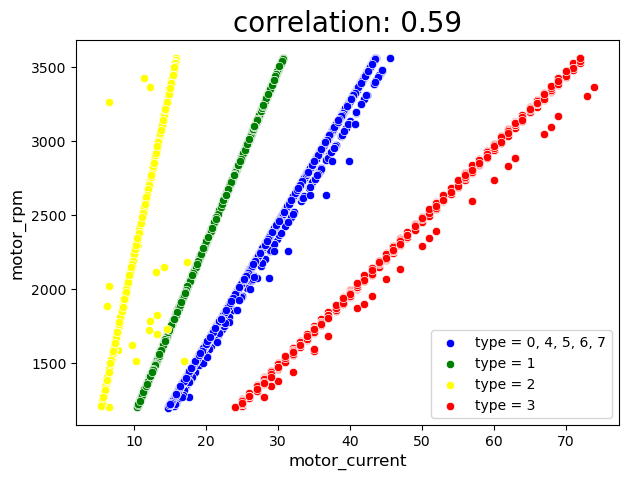

In [41]:
plot_corr(test_data, 'motor_current', 'motor_rpm')

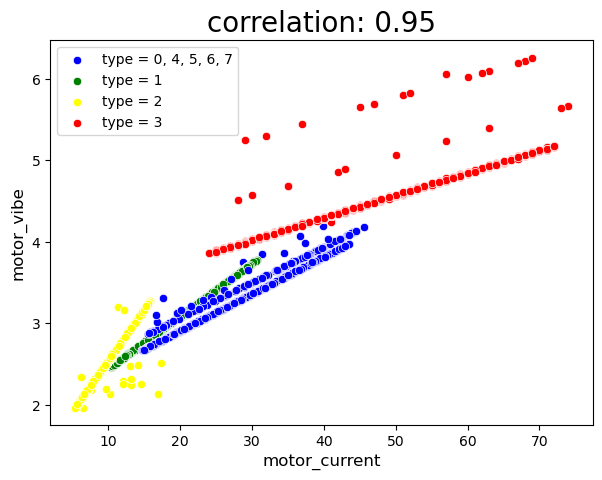

In [42]:
plot_corr(test_data, 'motor_current', 'motor_vibe')

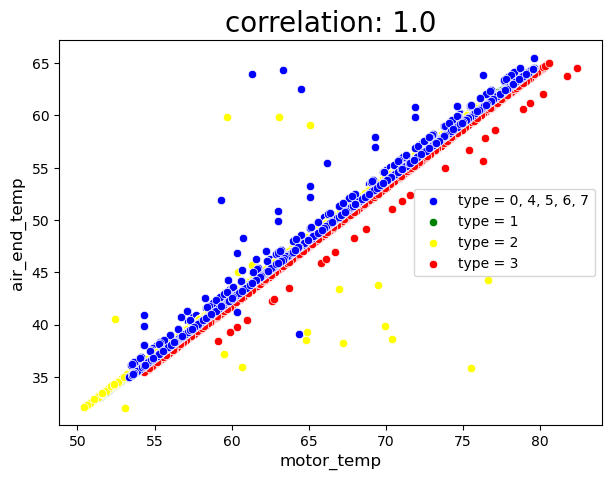

In [43]:
plot_corr(test_data, 'motor_temp', 'air_end_temp')

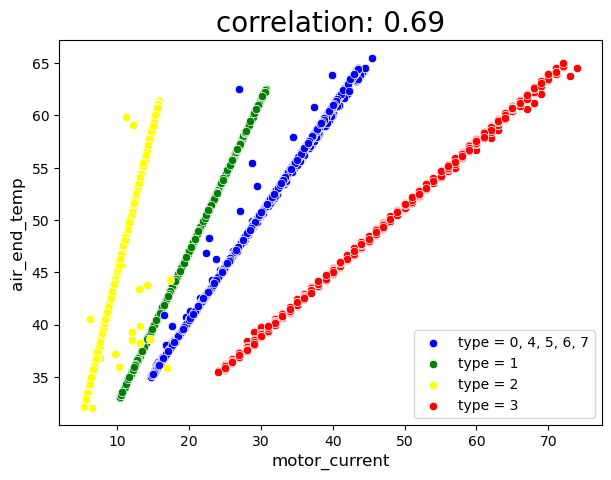

In [44]:
plot_corr(test_data, 'motor_current', 'air_end_temp')

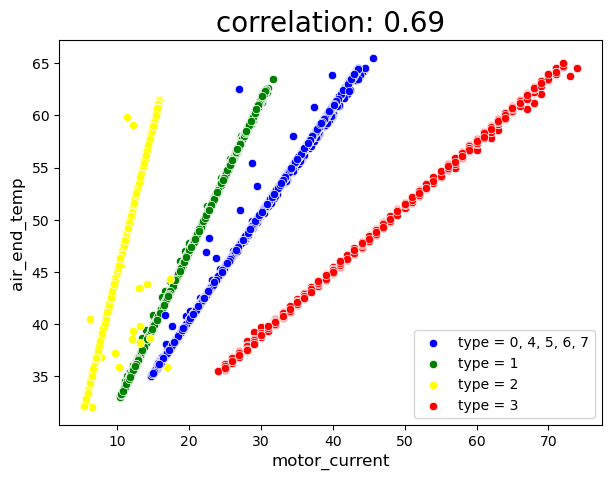

In [45]:
plot_corr(sum_data, 'motor_current', 'air_end_temp')

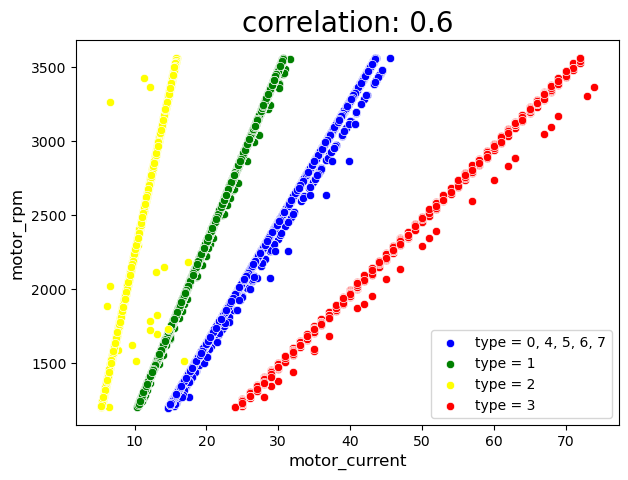

In [46]:
plot_corr(sum_data, 'motor_current', 'motor_rpm')

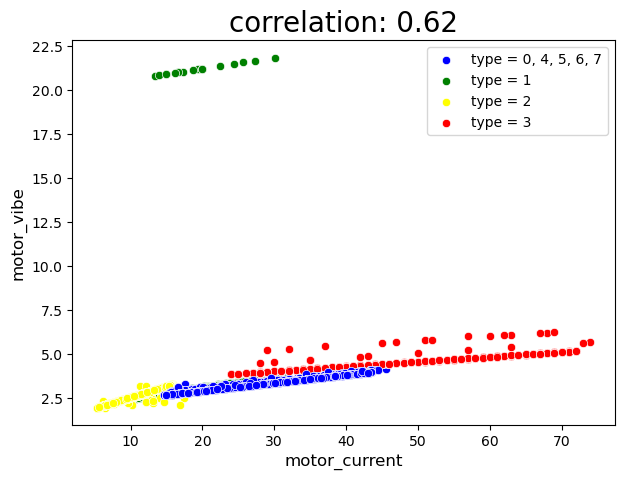

In [42]:
plot_corr(sum_data, 'motor_current', 'motor_vibe')

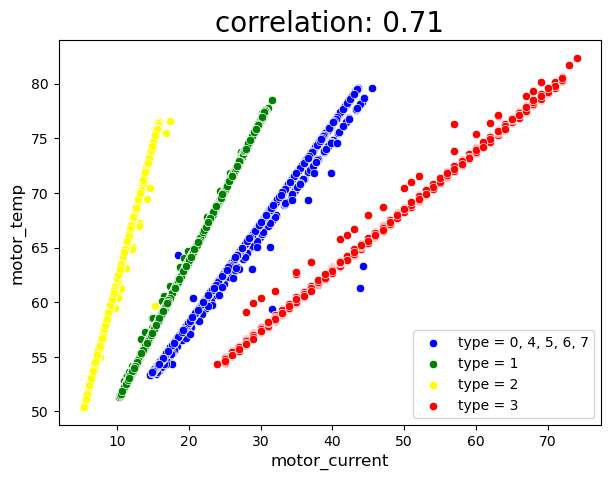

In [43]:
plot_corr(sum_data, 'motor_current', 'motor_temp')

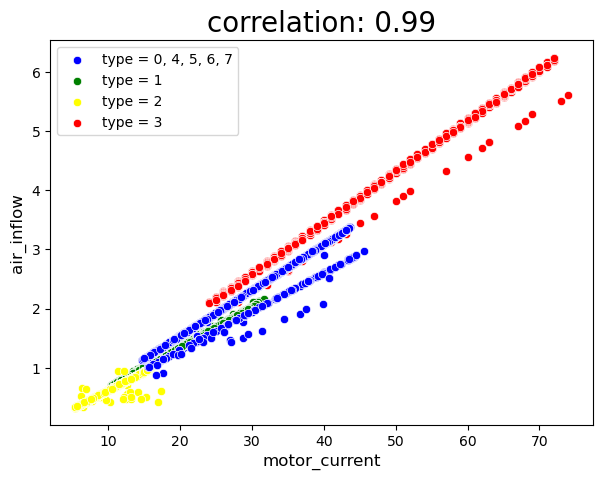

In [44]:
plot_corr(sum_data, 'motor_current', 'air_inflow')

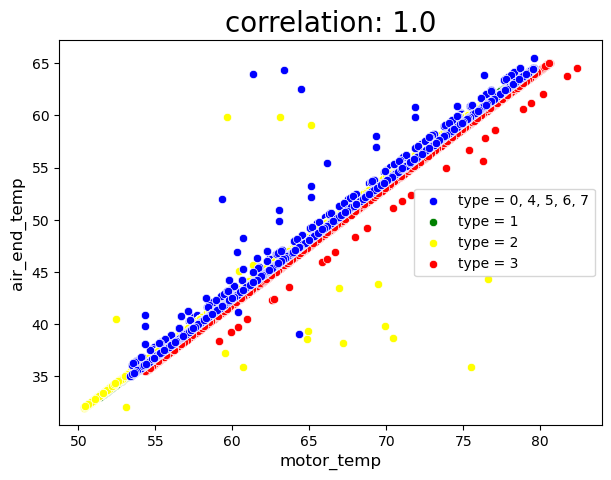

In [45]:
plot_corr(sum_data, 'motor_temp', 'air_end_temp')

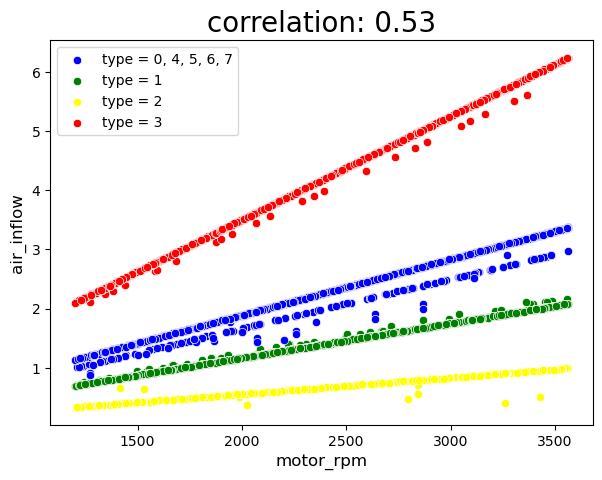

In [46]:
plot_corr(sum_data, 'motor_rpm', 'air_inflow')

## 비교해보기

In [47]:
sum_data['motor_rpm/motor_current'] = sum_data['motor_rpm'] / sum_data['motor_current']
sum_data['air_inflow/motor_current'] = sum_data['air_inflow'] / sum_data['motor_current'] 
sum_data

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0         0        1.59         41.00           0.7          20.53     1680.0   
1         1        2.97         59.28           0.7          38.40     3142.0   
2         2        1.91         45.29           0.7          24.73     2023.0   
3         3        2.37         51.33           0.7          30.63     2506.0   
4         4        1.90         45.21           0.7          24.65     2017.0   
...     ...         ...           ...           ...            ...        ...   
9847   7384        2.12         48.08           0.7          27.45     2246.0   
9848   7385        1.48         39.63           0.7          19.19     1570.0   
9849   7386        1.56         40.61           0.7          20.15     1649.0   
9850   7387        1.59         40.99           0.7          20.52     1679.0   
9851   7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
9847       64.96        3.25     7      test                81.821494   
9848       57.44        2.87     7      test                81.813445   
9849       58.32        2.92     7      test                81.836228   
9850       58.66        2.93     7      test                81.822612   
9851       60.01        3.00     7      test                81.826443   

      air_inflow/motor_current  
0                     0.077448  
1                     0.077344  
2                     0.077234  
3                     0.077375  
4                     0.077079  
...                        ...  
9847                  0.077231  
9848                  0.077124  
9849                  0.077419  
9850                  0.077485  
9851                  0.077238  

[9852 rows x 12 columns]

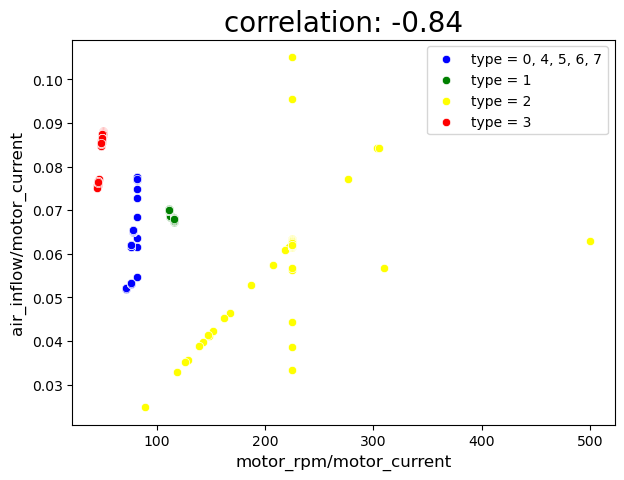

In [48]:
plot_corr(sum_data, 'motor_rpm/motor_current', 'air_inflow/motor_current')

In [49]:
train_data['motor_rpm/motor_current'] = train_data['motor_rpm'] / train_data['motor_current']
train_data['air_inflow/motor_current'] = train_data['air_inflow'] / train_data['motor_current'] 
train_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
2458       66.84        3.34     7     train                81.815103   
2459       63.94        3.20     7     train                81.814730   
2460       53.99        2.70     7     train                81.806368   
2461       54.22        2.71     7     train                81.841432   
2462       71.99        3.60     7     train                81.813015   

      air_inflow/motor_current  
0                     0.077448  
1                     0.077344  
2                     0.077234  
3                     0.077375  
4                     0.077079  
...                        ...  
2458                  0.077210  
2459                  0.077449  
2460                  0.077323  
2461                  0.077366  
2462                  0.077295  

[2463 rows x 11 columns]

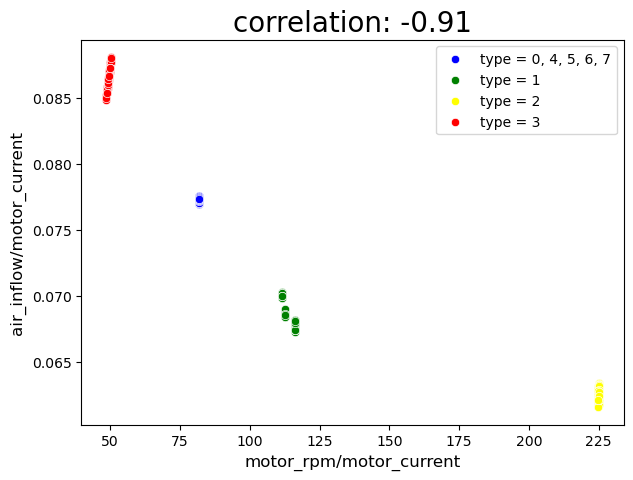

In [50]:
plot_corr(train_data, 'motor_rpm/motor_current', 'air_inflow/motor_current')

In [51]:
test_data['motor_rpm/motor_current'] = test_data['motor_rpm'] / test_data['motor_current']
test_data['air_inflow/motor_current'] = test_data['air_inflow'] / test_data['motor_current'] 

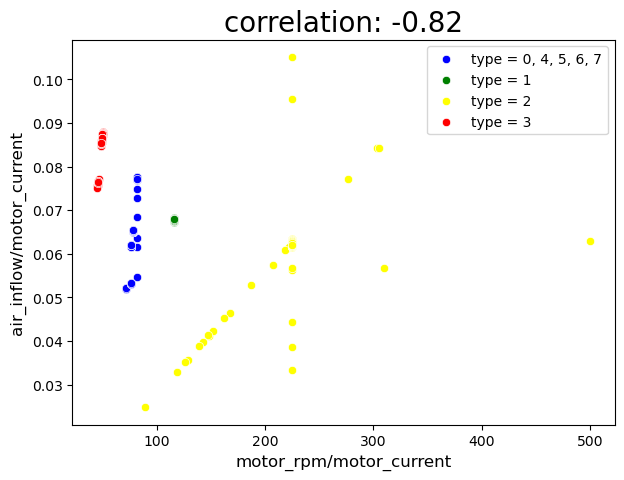

In [52]:
plot_corr(test_data, 'motor_rpm/motor_current', 'air_inflow/motor_current')

특성을 합쳐서 보도록 하겠습니다.

In [53]:
# air_and_temp
train_data['new'] = train_data['air_inflow'] * train_data['air_end_temp'] * train_data['motor_current'] * train_data['motor_rpm'] * train_data['motor_temp'] * train_data['motor_vibe']

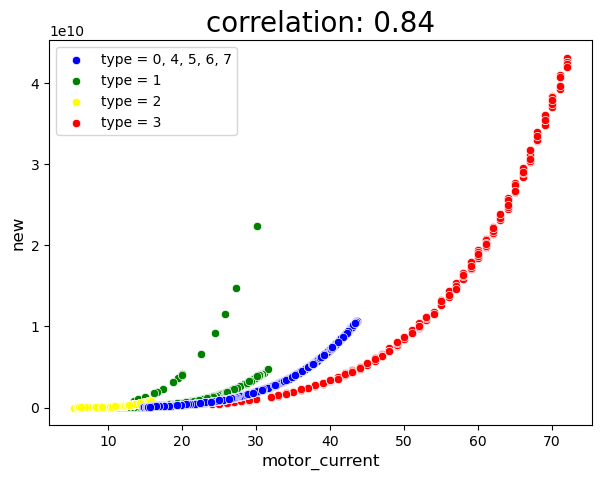

In [54]:
plot_corr(train_data, "motor_current", "new")

In [55]:
# air_and_temp
test_data['new'] = test_data['air_inflow'] * test_data['air_end_temp'] * test_data['motor_current'] * test_data['motor_rpm'] * test_data['motor_temp'] * test_data['motor_vibe']

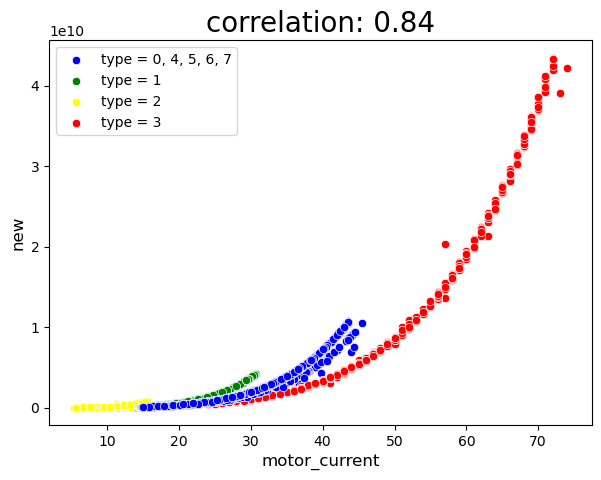

In [56]:
plot_corr(test_data, 'motor_current', 'new')

특성을 곱해서 보았더니 너무 스케일이 커서 분석이 어려워집니다. 따라서 특성을 합치지 않고 그대로 진행하였습니다.

In [57]:
train_data.drop(columns=['new'], inplace=True)

In [58]:
test_data.drop(columns=['new'], inplace=True)

상관도를 한 눈에 볼 수 있도록 정리하겠습니다.

In [59]:
# 상관도 표 함수
def corr_matrix(data):
  plt.figure(figsize=(7,5))
  mask = np.zeros_like(data.corr(), dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  g = sns.heatmap(data.corr(), cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True, annot_kws={"size": 10}, fmt=".2f", square=True,
                  cbar_kws={"shrink":.7})
  g.set_xticklabels(g.get_xmajorticklabels(), fontsize=10)
  g.set_yticklabels(g.get_xmajorticklabels(), fontsize=10)
  plt.show()

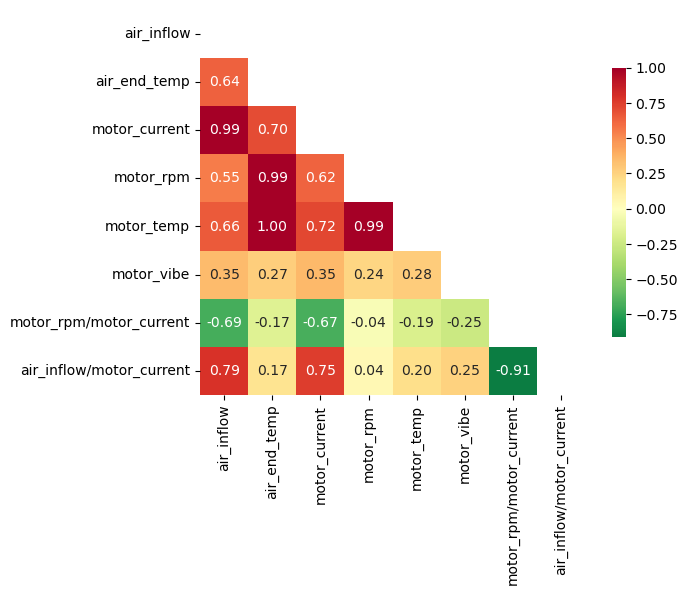

In [60]:
corr_matrix(train_data.drop(columns=['out_pressure','type']))

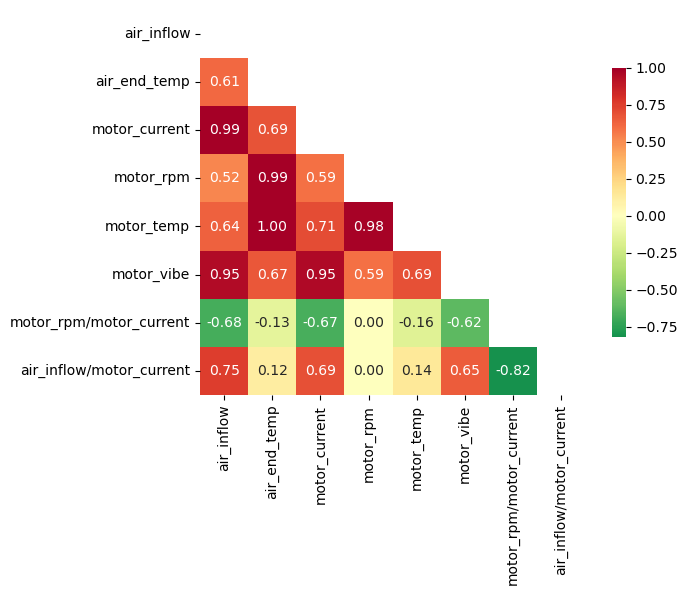

In [61]:
corr_matrix(test_data.drop(columns=['out_pressure','type']))

마력에 따라 상관도가 달라질 수 있으니 type별로 분리하여 상관도를 한 눈에 보도록 하겠습니다.

In [62]:
# type별 분리
for i in range(8):
  globals()['data_{}'.format(i)] = train_data[train_data['type'] == i]
data_0

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0          1.59         41.00           0.7          20.53     1680.0   
1          2.97         59.28           0.7          38.40     3142.0   
2          1.91         45.29           0.7          24.73     2023.0   
3          2.37         51.33           0.7          30.63     2506.0   
4          1.90         45.21           0.7          24.65     2017.0   
..          ...           ...           ...            ...        ...   
427        1.32         37.49           0.7          17.10     1399.0   
428        1.80         43.85           0.7          23.32     1908.0   
429        2.79         56.99           0.7          36.17     2959.0   
430        2.25         49.79           0.7          29.13     2383.0   
431        1.52         40.15           0.7          19.70     1612.0   

     motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0         58.67        2.93     0     train                81.831466   
1         74.91        3.75     0     train                81.822917   
2         62.48        3.12     0     train                81.803478   
3         67.84        3.39     0     train                81.815214   
4         62.41        3.12     0     train                81.825558   
..          ...         ...   ...       ...                      ...   
427       55.54        2.78     0     train                81.812865   
428       61.20        3.06     0     train                81.818182   
429       72.88        3.64     0     train                81.808128   
430       66.48        3.32     0     train                81.805699   
431       57.91        2.90     0     train                81.827411   

     air_inflow/motor_current  
0                    0.077448  
1                    0.077344  
2                    0.077234  
3                    0.077375  
4                    0.077079  
..                        ...  
427                  0.077193  
428                  0.077187  
429                  0.077136  
430                  0.077240  
431                  0.077157  

[432 rows x 11 columns]

In [63]:
# 상관도 표 함수
def subplot_corr_matrix(data):
  f, axs = plt.subplots(4,2,figsize=(10,12))
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type']==i].drop(columns=['out_pressure', 'type'])
    mask = np.zeros_like(globals()['data{}'.format(i)].corr(), dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    g = sns.heatmap(globals()['data{}'.format(i)].corr(), cmap='RdYlGn_r', vmax=1,vmin=0,  mask=mask, center=0, annot=True, annot_kws={"size":10},
                    fmt=".2f", square=True, ax=axs[int(i/2), i%2], cbar_kws={"shrink":.7})
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize=4)
    g.set_yticklabels(g.get_xmajorticklabels(), fontsize=4)
    axs[int(i/2), i%2].set_title('type={}'.format(i),size=4)
  plt.tight_layout()
  plt.show()

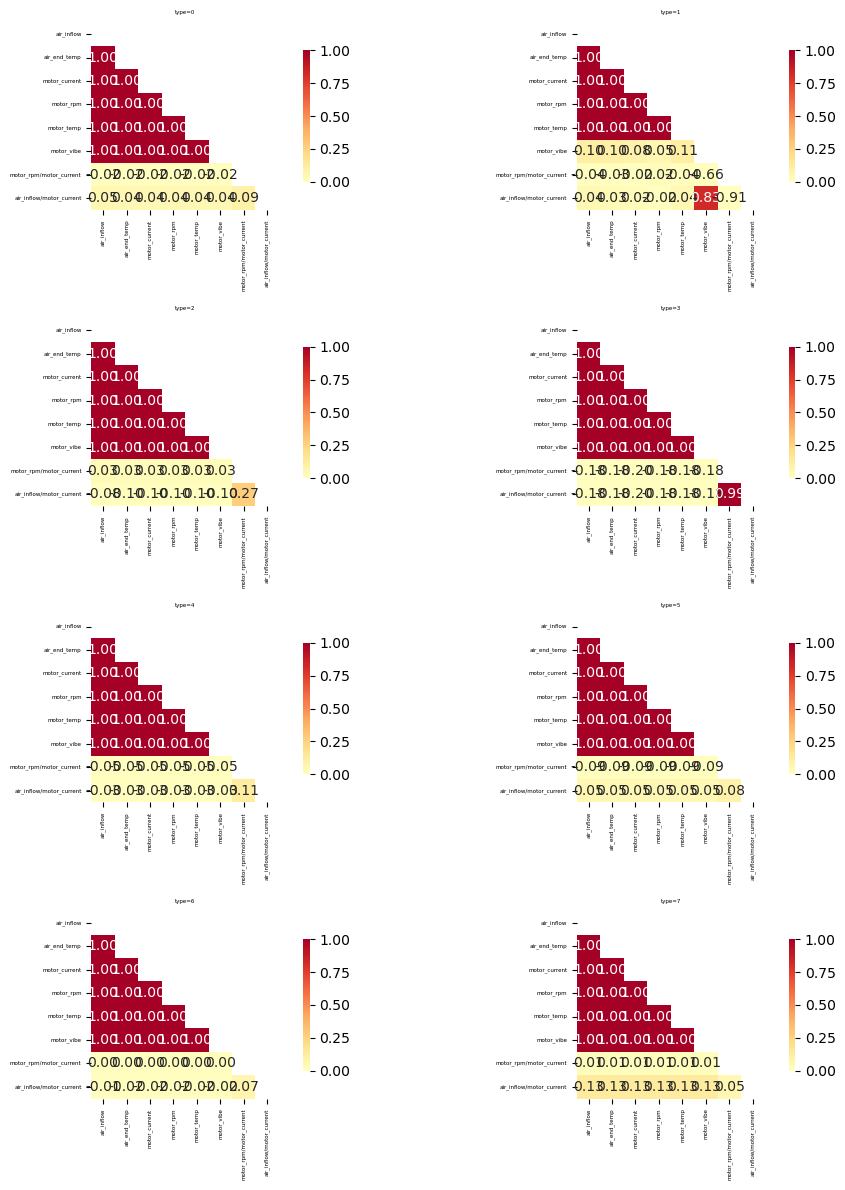

In [64]:
subplot_corr_matrix(train_data)

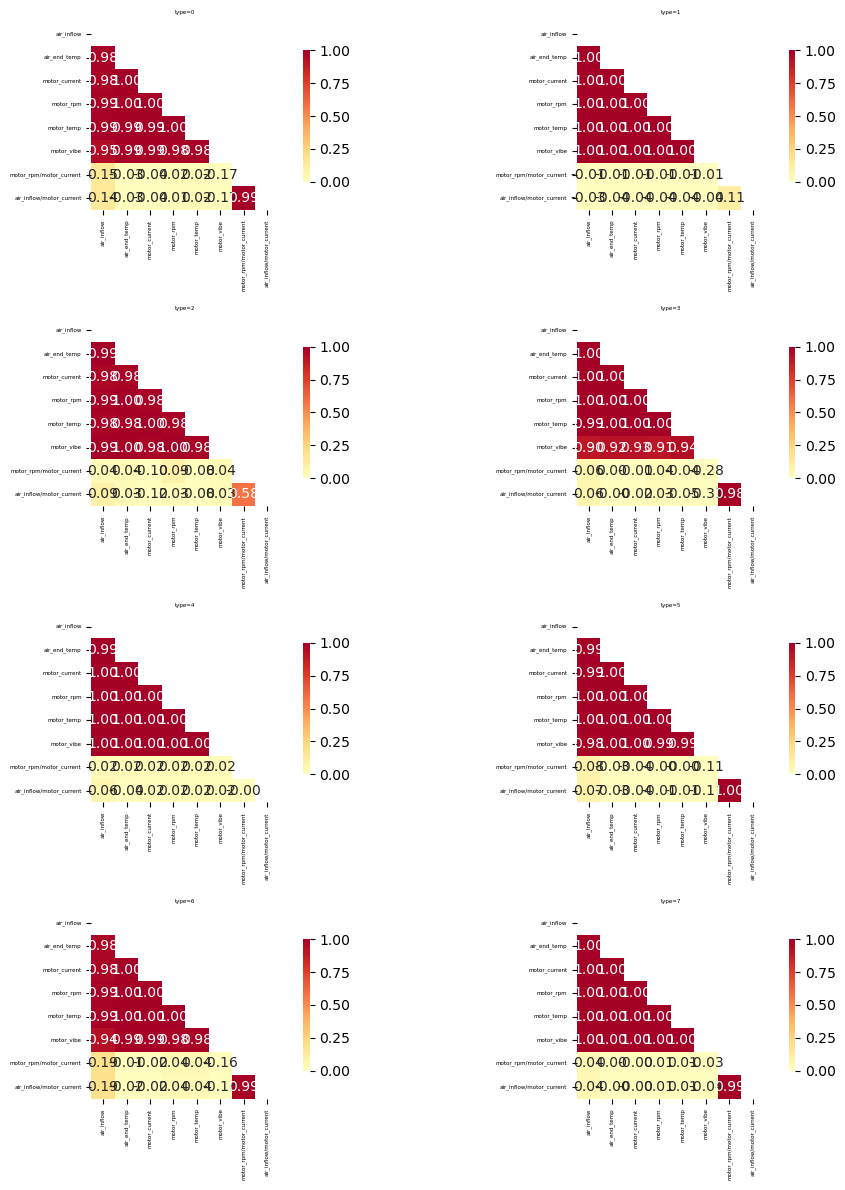

In [65]:
subplot_corr_matrix(test_data)

상관도 분석은 type별로 나눠서 분석하면 안되겠군요. 너무 차이가 나지 않습니다.

In [66]:
for i in range(8):
  globals()['test_data_{}'.format(i)] = test_data[test_data['type'] == i]

In [67]:
def plot_corr_train_test(types, data1, data2, name1, name2):
  # plt.figure(figsize=(7,5))
  # fig, ax = plt.subplots()
  # color = ['green', 'yellow', 'red']
  sns.scatterplot(data=data1, x=name1, y=name2, color='red')
  plt.xlim([72, 82])
  plt.ylim([0.05, 0.08])
  # ax2 = ax.twinx()
  # sns.scatterplot(data = data2, x=name1, y=name2, color='red', ax = ax )
  plt.title('type = {}'.format(types) ,fontsize=20)
  plt.xlabel(name1, fontsize=12)
  plt.ylabel(name2, fontsize=12)
  plt.show()

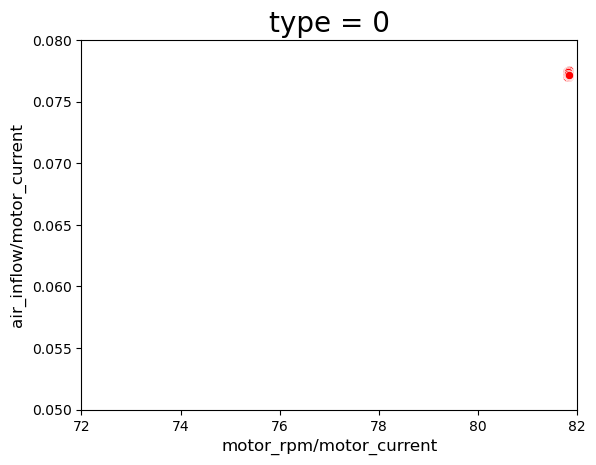

In [68]:
plot_corr_train_test(0, data_0, test_data_0, 'motor_rpm/motor_current', 'air_inflow/motor_current')

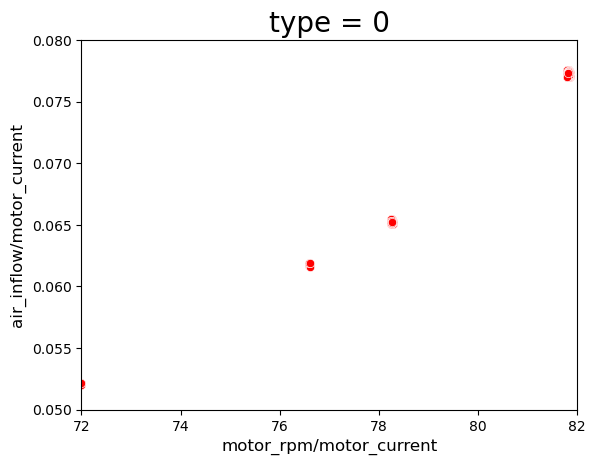

In [69]:
plot_corr_train_test(0, test_data_0, data_0, 'motor_rpm/motor_current', 'air_inflow/motor_current')

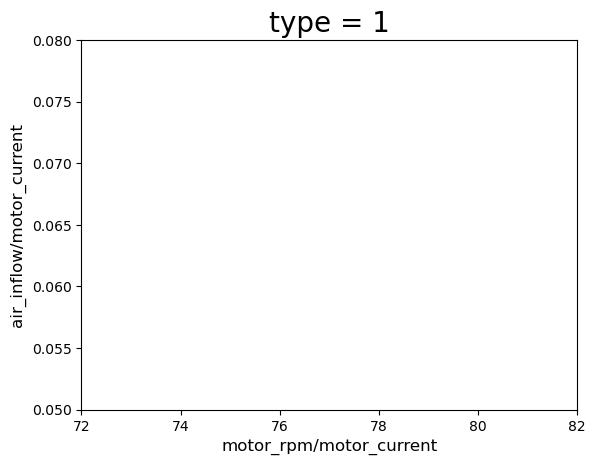

In [70]:
plot_corr_train_test(1, data_1, test_data_1, 'motor_rpm/motor_current', 'air_inflow/motor_current')

In [71]:
train_data['motor_current/horse_power'] = np.NaN
test_data['motor_current/horse_power'] = np.NaN
def split_data(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['motor_current/horse_power'][i] = data['motor_current'][i] / (20)
    elif data['type'][i] == 2:
      data['motor_current/horse_power'][i] = data['motor_current'][i] / (10)
    elif data['type'][i] == 3:
      data['motor_current/horse_power'][i] = data['motor_current'][i] / (50)
    else:
      data['motor_current/horse_power'][i] = data['motor_current'][i] / (30)

In [72]:
train_data['motor_current*motor_rpm/horse_power'] = np.NaN
test_data['motor_current*motor_rpm/horse_power'] = np.NaN
def split_data2(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['motor_current*motor_rpm/horse_power'][i] = data['motor_current'][i] * data['motor_rpm'][i] / (20)
    elif data['type'][i] == 2:
      data['motor_current*motor_rpm/horse_power'][i] = data['motor_current'][i] * data['motor_rpm'][i] / (10)
    elif data['type'][i] == 3:
      data['motor_current*motor_rpm/horse_power'][i] = data['motor_current'][i] * data['motor_rpm'][i] / (50)
    else:
      data['motor_current*motor_rpm/horse_power'][i] = data['motor_current'][i] * data['motor_rpm'][i] / (30)

In [73]:
train_data['air_inflow/horse_power'] = np.NaN
test_data['air_inflow/horse_power'] = np.NaN
def split_data3(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['air_inflow/horse_power'][i] = data['air_inflow'][i] / (20)
    elif data['type'][i] == 2:
      data['air_inflow/horse_power'][i] = data['air_inflow'][i] / (10)
    elif data['type'][i] == 3:
      data['air_inflow/horse_power'][i] = data['air_inflow'][i] / (50)
    else:
      data['air_inflow/horse_power'][i] = data['air_inflow'][i] / (30)

In [74]:
train_data['motor_rpm/horse_power'] = np.NaN
test_data['motor_rpm/horse_power'] = np.NaN
def split_data4(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['motor_rpm/horse_power'][i] = data['motor_rpm'][i] / (20)
    elif data['type'][i] == 2:
      data['motor_rpm/horse_power'][i] = data['motor_rpm'][i] / (10)
    elif data['type'][i] == 3:
      data['motor_rpm/horse_power'][i] = data['motor_rpm'][i] / (50)
    else:
      data['motor_rpm/horse_power'][i] = data['motor_rpm'][i] / (30)

In [75]:
train_data['air_inflow/horse_power2'] = np.NaN
test_data['air_inflow/horse_power2'] = np.NaN
def split_data5(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['air_inflow/horse_power2'][i] = data['air_inflow'][i] / (4)
    elif data['type'][i] == 2:
      data['air_inflow/horse_power2'][i] = data['air_inflow'][i] / (1)
    elif data['type'][i] == 3:
      data['air_inflow/horse_power2'][i] = data['air_inflow'][i] / (25)
    else:
      data['air_inflow/horse_power2'][i] = data['air_inflow'][i] / (9)

In [76]:
train_data['air_inflow/motor_rpm'] = np.NaN
test_data['air_inflow/motor_rpm'] = np.NaN
def split_data6(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['air_inflow/motor_rpm'][i] = data['air_inflow'][i] / data['motor_rpm'][i]
    elif data['type'][i] == 2:
      data['air_inflow/motor_rpm'][i] = data['air_inflow'][i] / data['motor_rpm'][i]
    elif data['type'][i] == 3:
      data['air_inflow/motor_rpm'][i] = data['air_inflow'][i] / data['motor_rpm'][i]
    else:
      data['air_inflow/motor_rpm'][i] = data['air_inflow'][i] / data['motor_rpm'][i]

In [77]:
train_data['motor_vibe/motor_rpm'] = np.NaN
test_data['motor_vibe/motor_rpm'] = np.NaN
def split_data7(data):
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data['motor_vibe/motor_rpm'][i] = data['motor_vibe'][i] / data['motor_rpm'][i]
    elif data['type'][i] == 2:
      data['motor_vibe/motor_rpm'][i] = data['motor_vibe'][i] / data['motor_rpm'][i]
    elif data['type'][i] == 3:
      data['motor_vibe/motor_rpm'][i] = data['motor_vibe'][i] / data['motor_rpm'][i]
    else:
      data['motor_vibe/motor_rpm'][i] = data['motor_vibe'][i] / data['motor_rpm'][i]

In [78]:
def custom_split_data(data, name1, name2):
  data[name1+'/'+name2] = np.NaN
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data[name1+'/'+name2][i] = data[name1][i] / data[name2][i]
    elif data['type'][i] == 2:
      data[name1+'/'+name2][i] = data[name1][i] / data[name2][i]
    elif data['type'][i] == 3:
      data[name1+'/'+name2][i] = data[name1][i] / data[name2][i]
    else:
      data[name1+'/'+name2][i] = data[name1][i] / data[name2][i]
  return data

In [79]:
def custom_split_data_horse(data, name1):
  data[name1+'/horse_power'] = np.NaN
  for i in tqdm(range(len(data))):
    if data['type'][i] == 1:
      data[name1+'/horse_power'][i] = data[name1][i] / 20
    elif data['type'][i] == 2:
      data[name1+'/horse_power'][i] = data[name1][i] / 10
    elif data['type'][i] == 3:
      data[name1+'/horse_power'][i] = data[name1][i] / 50
    else:
      data[name1+'/horse_power'][i] = data[name1][i] / 30
  return data

In [80]:
train_data = custom_split_data_horse(train_data, 'air_inflow/motor_rpm')
test_data = custom_split_data_horse(test_data, 'air_inflow/motor_rpm')
train_data

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
2458       66.84        3.34     7     train                81.815103   
2459       63.94        3.20     7     train                81.814730   
2460       53.99        2.70     7     train                81.806368   
2461       54.22        2.71     7     train                81.841432   
2462       71.99        3.60     7     train                81.813015   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                        NaN   
1                     0.077344                        NaN   
2                     0.077234                        NaN   
3                     0.077375                        NaN   
4                     0.077079                        NaN   
...                        ...                        ...   
2458                  0.077210                        NaN   
2459                  0.077449                        NaN   
2460                  0.077323                        NaN   
2461                  0.077366                        NaN   
2462                  0.077295                        NaN   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                                     NaN                     NaN   
1                                     NaN                     NaN   
2                                     NaN                     NaN   
3                                     NaN                     NaN   
4                                     NaN                     NaN   
...                                   ...                     ...   
2458                                  NaN                     NaN   
2459                                  NaN                     NaN   
2460                                  NaN                     NaN   
2461                                  NaN                     NaN   
2462                                  NaN                     NaN   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                       NaN                      NaN                   NaN   
1                       NaN                      NaN                   NaN   
2                       NaN                      NaN                   NaN   
3                       NaN                      NaN                   NaN   
4                       NaN                      NaN                   NaN   
...                     ...                      ...                   ...   
2458                    NaN                      NaN                   NaN   
2459                    NaN                      NaN  

In [81]:
split_data(train_data)
split_data(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [82]:
split_data2(train_data)
split_data2(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [83]:
split_data3(train_data)
split_data3(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [84]:
split_data4(train_data)
split_data4(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [85]:
split_data5(train_data)
split_data5(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [86]:
split_data6(train_data)
split_data6(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [87]:
split_data7(train_data)
split_data7(test_data)

  0%|          | 0/2463 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

In [88]:
train_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2458        2.28         50.20           0.7          29.53     2416.0   
2459        2.04         46.94           0.7          26.34     2155.0   
2460        1.19         35.74           0.7          15.39     1259.0   
2461        1.21         36.00           0.7          15.64     1280.0   
2462        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
2458       66.84        3.34     7     train                81.815103   
2459       63.94        3.20     7     train                81.814730   
2460       53.99        2.70     7     train                81.806368   
2461       54.22        2.71     7     train                81.841432   
2462       71.99        3.60     7     train                81.813015   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
2458                  0.077210                   0.984333   
2459                  0.077449                   0.878000   
2460                  0.077323                   0.513000   
2461                  0.077366                   0.521333   
2462                  0.077295                   1.173000   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
2458                          2378.149333                0.076000   
2459                          1892.090000                0.068000   
2460                           645.867000                0.039667   
2461                           667.306667                0.040333   
2462                          3377.067000                0.090667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
2458              80.533333                 0.253333              0.000944   
2459              71.833333                 0.226667  

In [89]:
def sub_plot_corr(data,data2,  name1, name2):
  plt.figure(figsize=(10,5))
  correlation = data[name1].corr(data[name2])
  j = 0
  color = ['green', 'yellow', 'red']
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type'] == i]
    plt.subplot(1,2,1)
    if i == 1 or i == 2 or i == 3:
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue')
  g.set_title("train_data", size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  j = 0
  for i in range(8):
    globals()['data{}'.format(i)] = data2[data2['type'] == i]
    plt.subplot(1,2,2)
    if i == 1 or i == 2 or i == 3:
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue') 
  g2.set_title("test_data", size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  plt.tight_layout()
  plt.show()

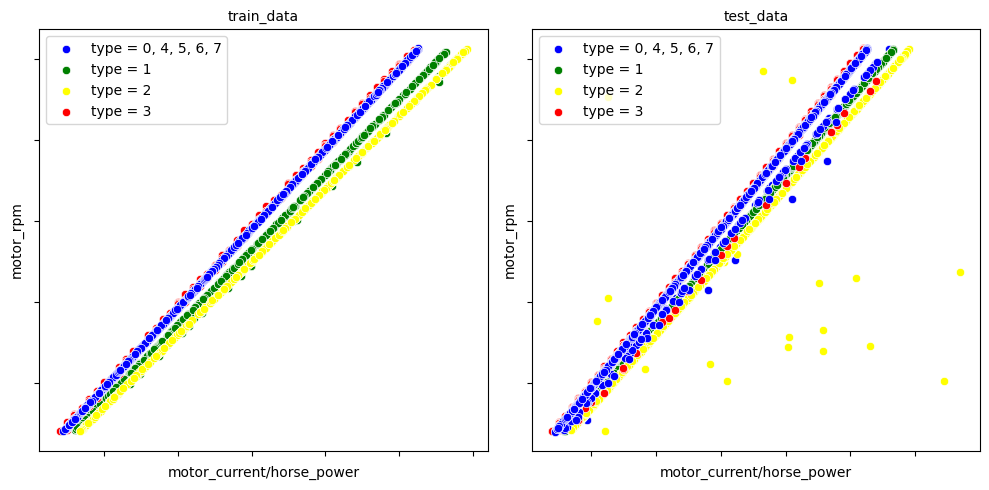

In [90]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'motor_rpm')

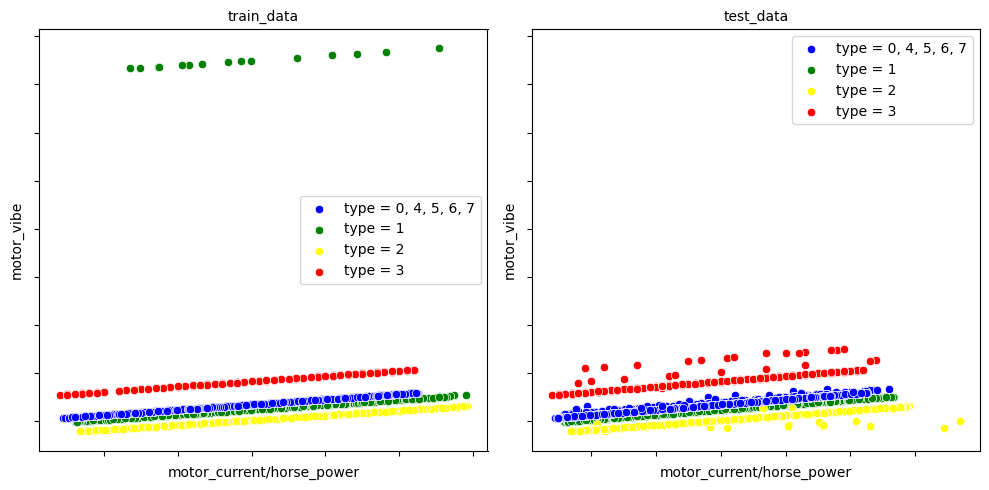

In [91]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'motor_vibe')

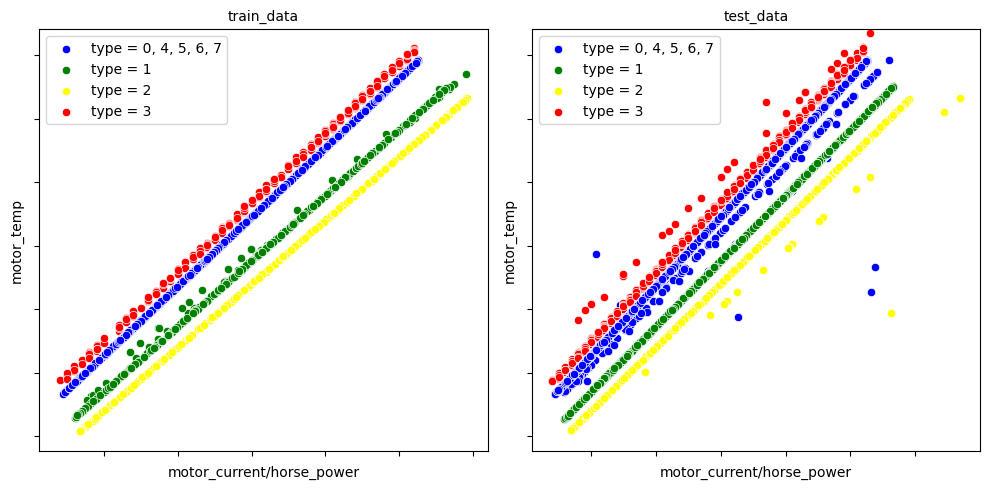

In [92]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'motor_temp')

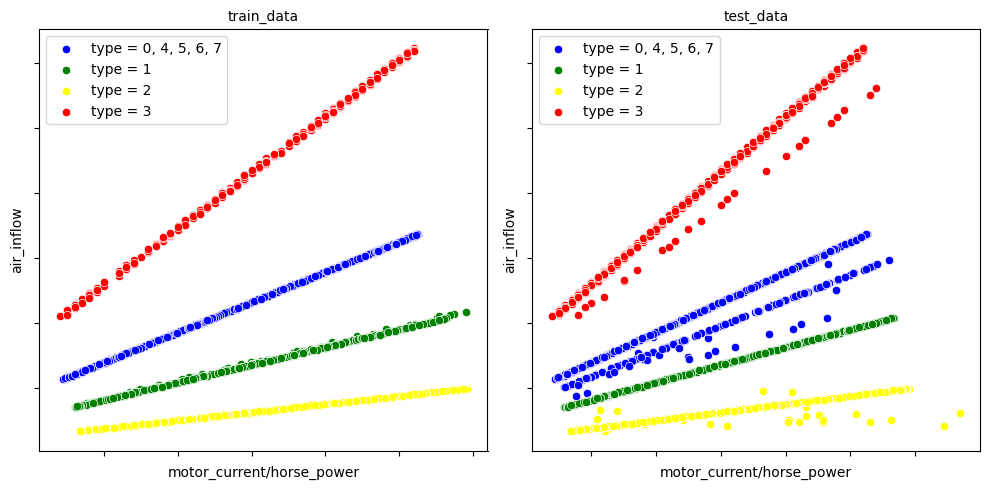

In [93]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'air_inflow')

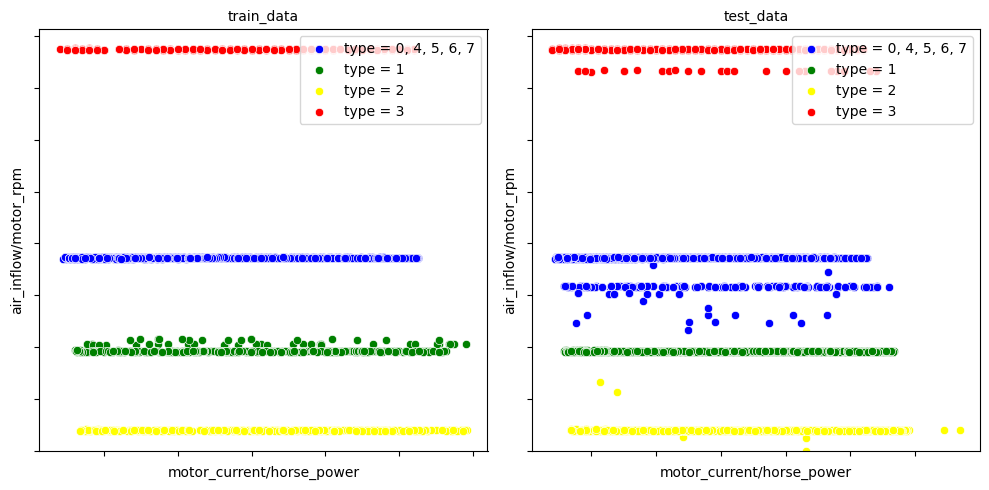

In [94]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'air_inflow/motor_rpm')

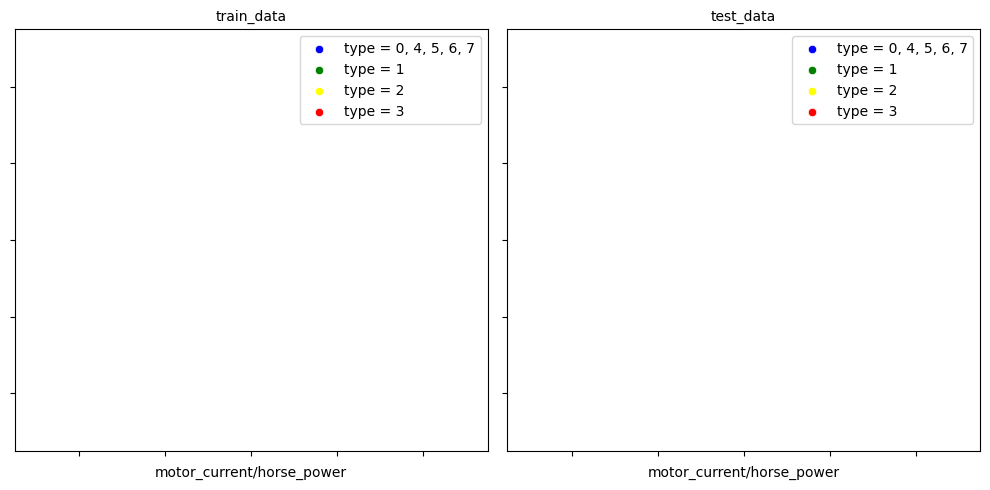

In [95]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'air_inflow/motor_rpm/horse_power')

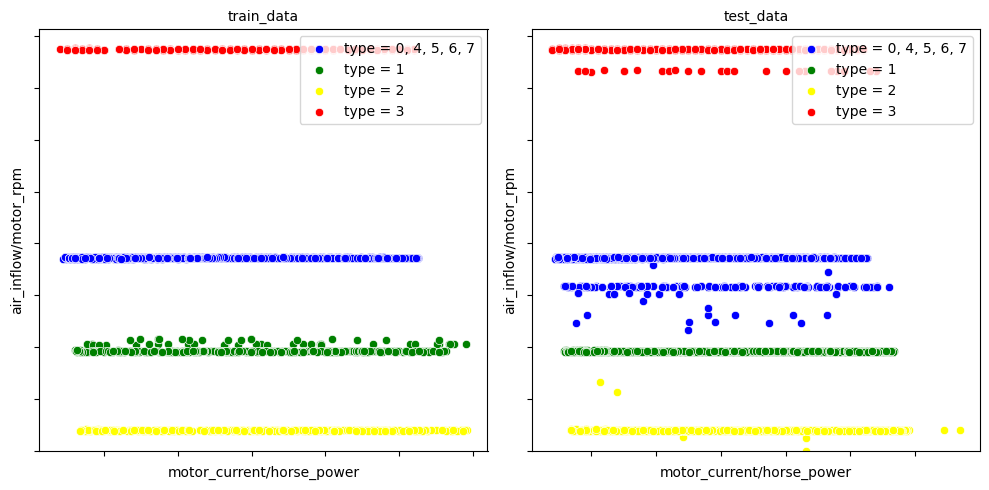

In [96]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'air_inflow/motor_rpm')

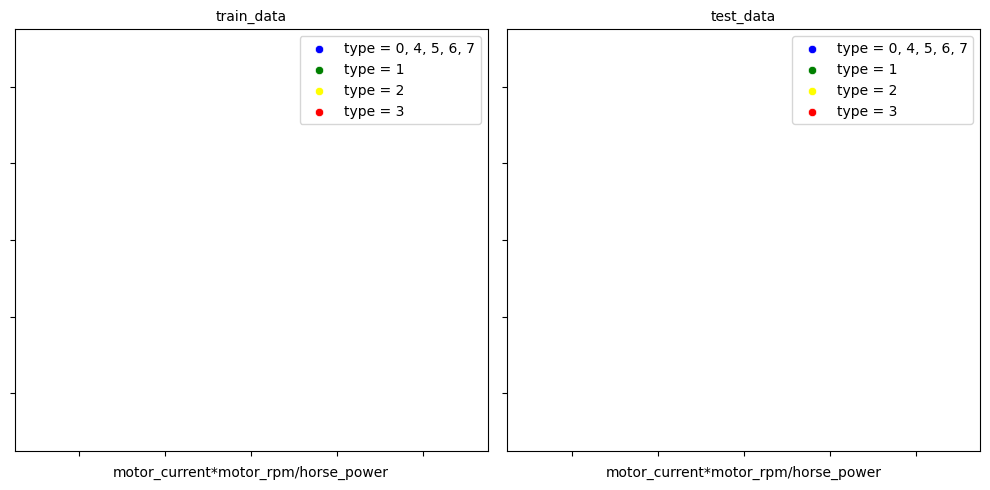

In [97]:
sub_plot_corr(train_data, test_data, 'motor_current*motor_rpm/horse_power', 'air_inflow/motor_rpm/horse_power')

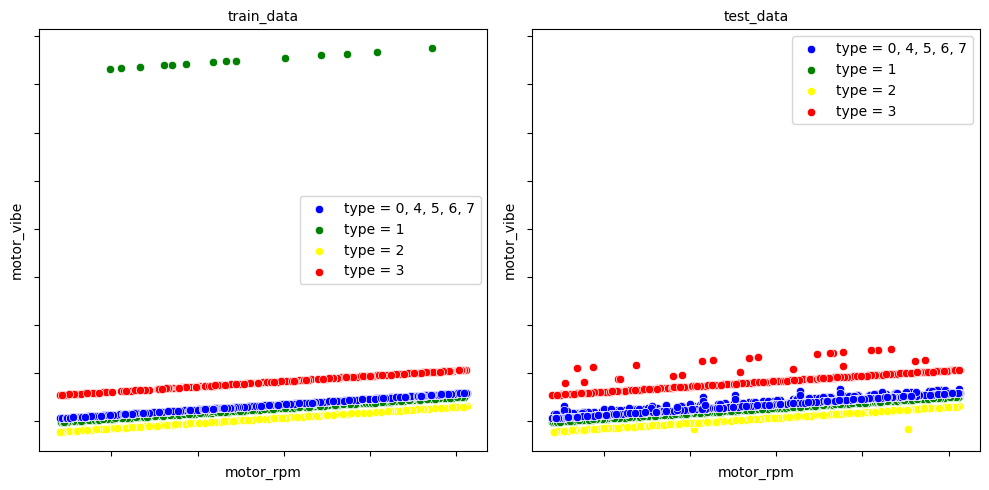

In [98]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'motor_vibe')

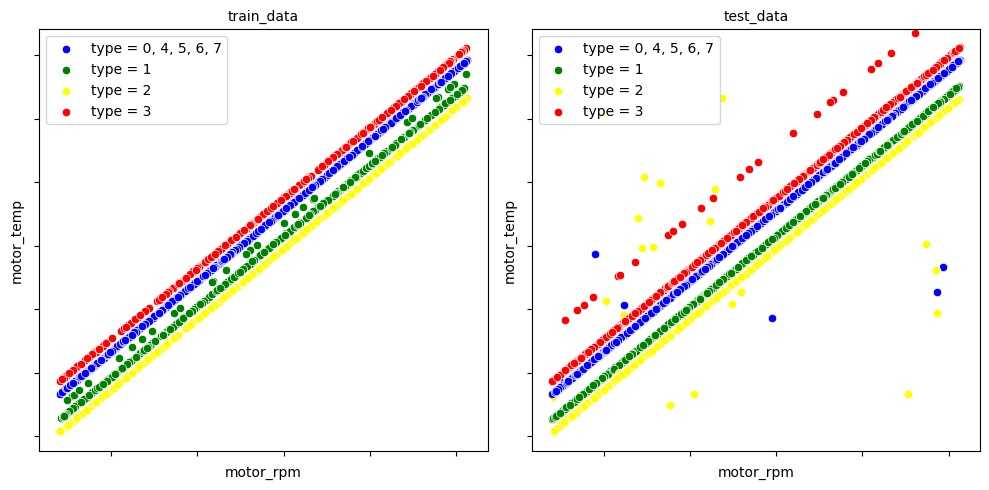

In [99]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'motor_temp')

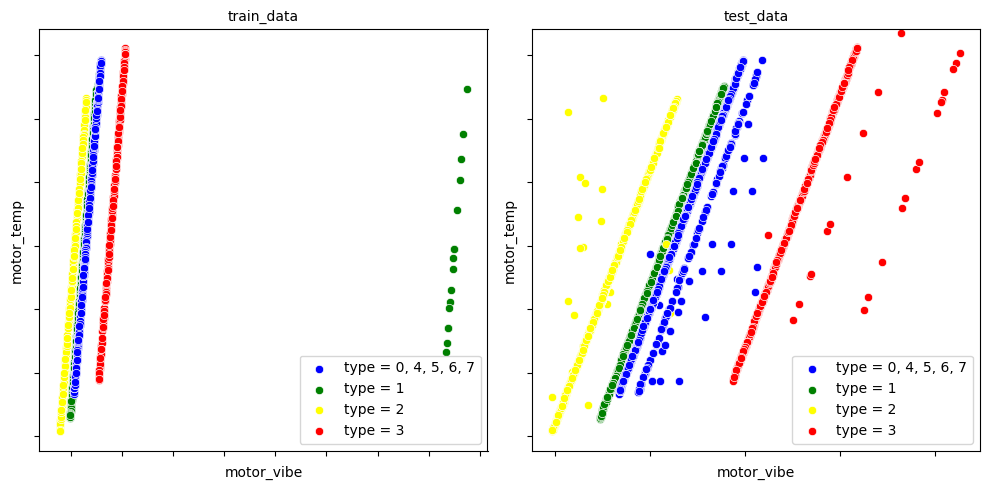

In [100]:
sub_plot_corr(train_data, test_data, 'motor_vibe', 'motor_temp')

type = 1에서 motor_vibe가 과도하게 많은 data가 많아보입니다. 정상치라고 하지만 test_data에서는 이와 같은 값을 가진 data가 없어보이므로 제거하겠습니다.

In [101]:
train_data = train_data[train_data['motor_vibe']<=20].reset_index(drop=True)
train_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2442        2.28         50.20           0.7          29.53     2416.0   
2443        2.04         46.94           0.7          26.34     2155.0   
2444        1.19         35.74           0.7          15.39     1259.0   
2445        1.21         36.00           0.7          15.64     1280.0   
2446        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
2442       66.84        3.34     7     train                81.815103   
2443       63.94        3.20     7     train                81.814730   
2444       53.99        2.70     7     train                81.806368   
2445       54.22        2.71     7     train                81.841432   
2446       71.99        3.60     7     train                81.813015   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
2442                  0.077210                   0.984333   
2443                  0.077449                   0.878000   
2444                  0.077323                   0.513000   
2445                  0.077366                   0.521333   
2446                  0.077295                   1.173000   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
2442                          2378.149333                0.076000   
2443                          1892.090000                0.068000   
2444                           645.867000                0.039667   
2445                           667.306667                0.040333   
2446                          3377.067000                0.090667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
2442              80.533333                 0.253333              0.000944   
2443              71.833333                 0.226667  

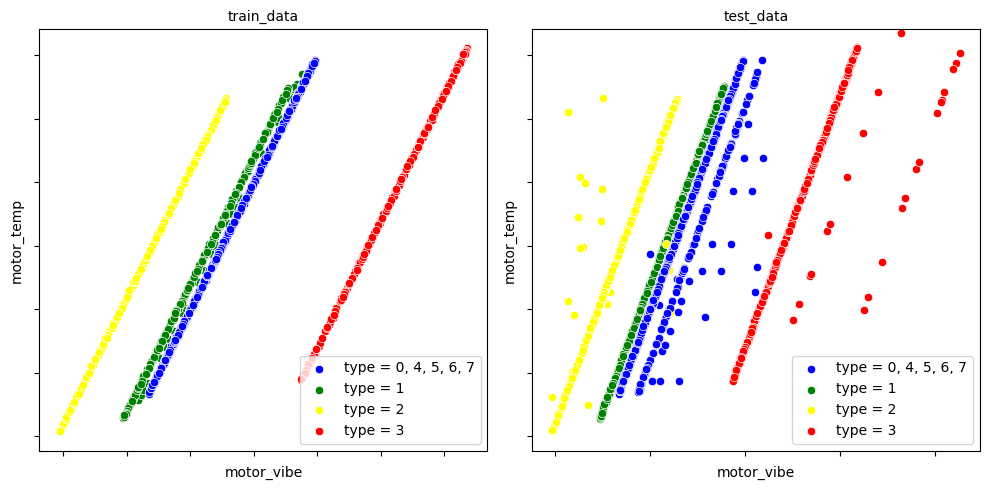

In [102]:
sub_plot_corr(train_data, test_data, 'motor_vibe', 'motor_temp')

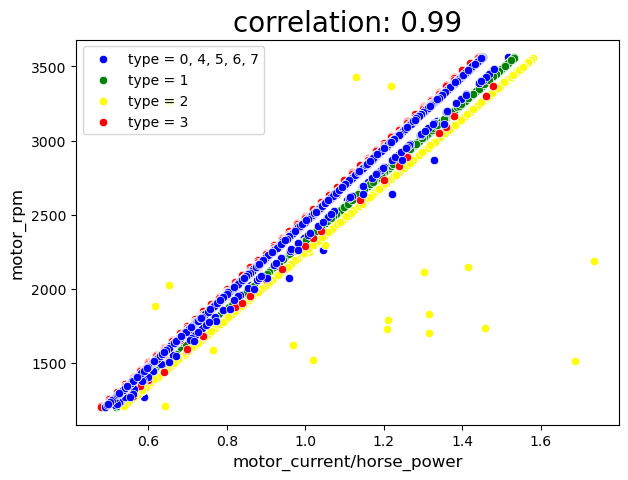

In [103]:
plot_corr(test_data, 'motor_current/horse_power', 'motor_rpm')

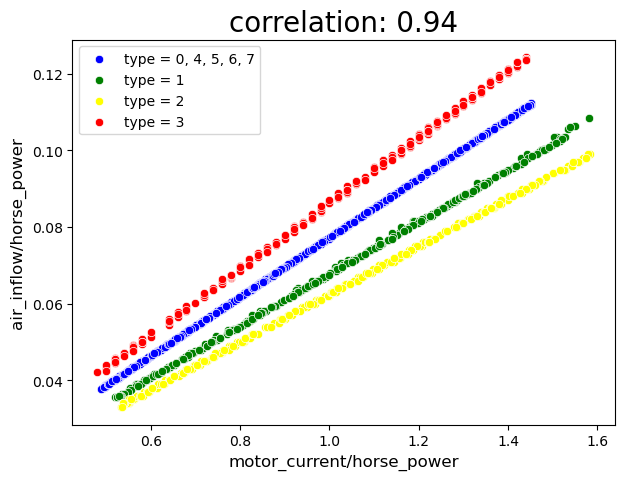

In [104]:
plot_corr(train_data, 'motor_current/horse_power', 'air_inflow/horse_power')

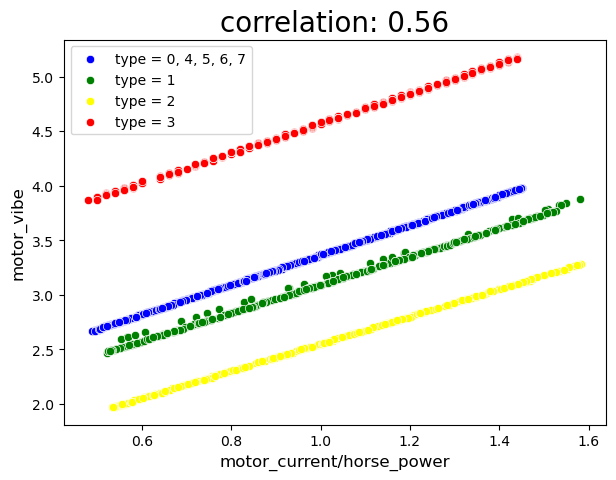

In [105]:
plot_corr(train_data, 'motor_current/horse_power', 'motor_vibe')

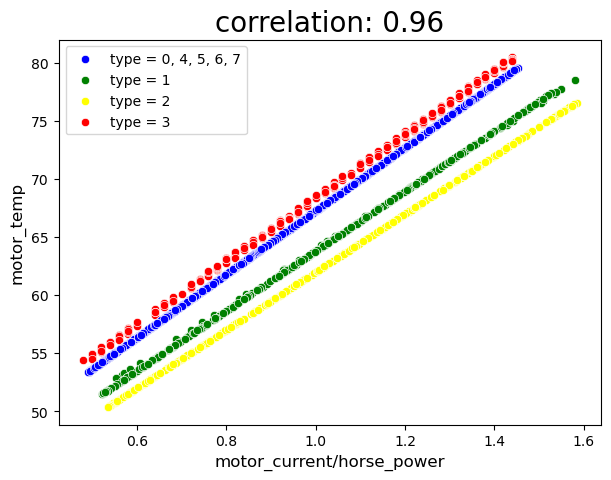

In [106]:
plot_corr(train_data, 'motor_current/horse_power', 'motor_temp')

# 문제 정의

고장이라는 것의 정의가 필요한 시점입니다. 

설비 고장을 다음과 같이 정의할 수 있습니다.
1. 성능이 나쁠 때
2. 진동, 온도, 회전이 평소보다 과도할 때

1번 성능이 나쁠 때가 거의 많아보입니다. 진동, 온도, 회전이 과도하더라도 공기 흡입 유량이 그만큼 많아진다면 성능이 좋은 것으로 볼 수 있기 때문입니다. 한 번 확인해보겠습니다.

## rpm당 공기 흡입량

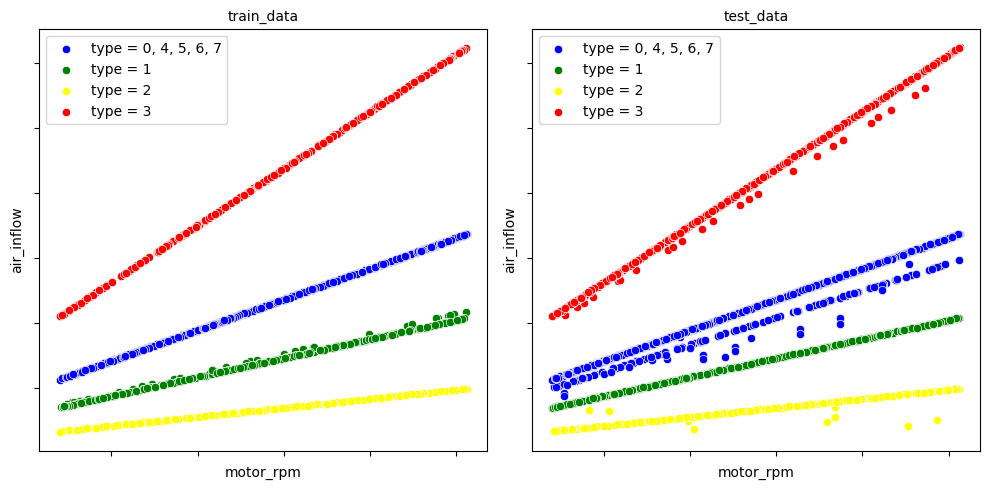

In [107]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'air_inflow')

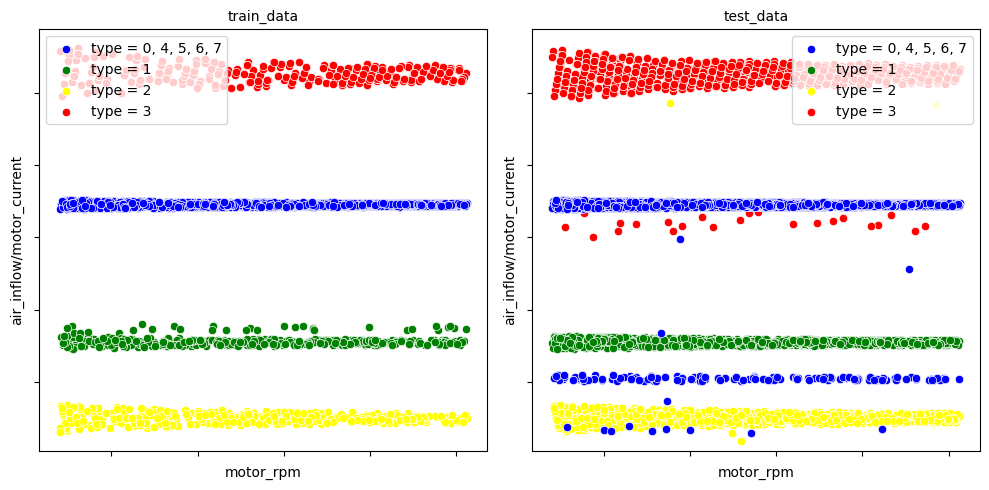

In [108]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'air_inflow/motor_current')

## 전류당 진동

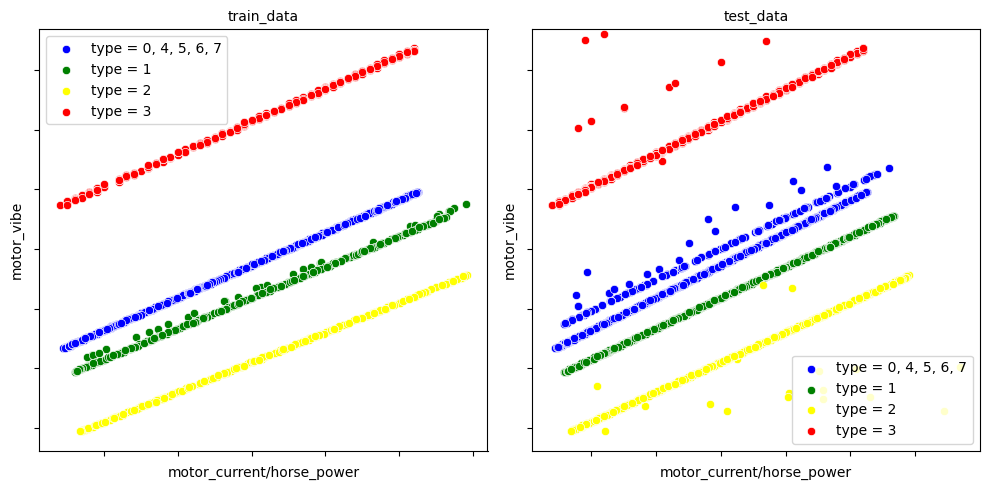

In [109]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'motor_vibe')

## 전류당 온도

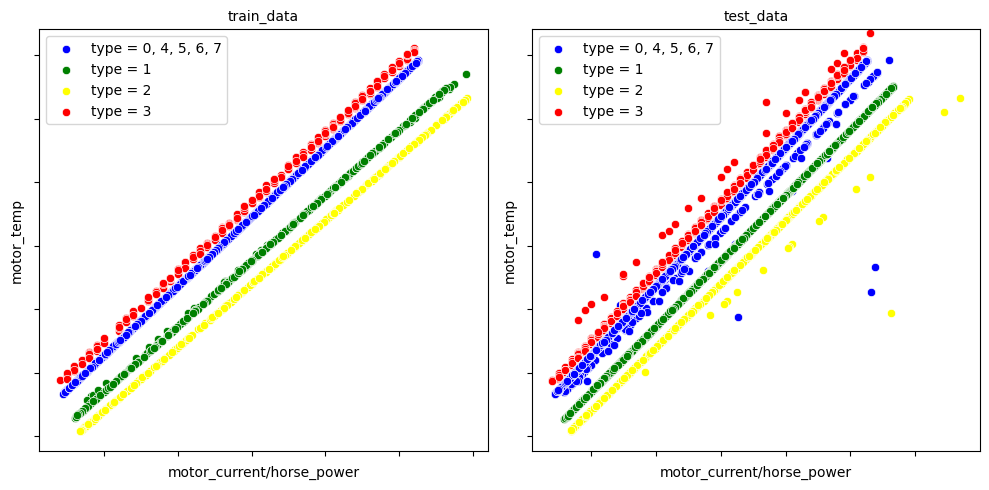

In [110]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'motor_temp')

## 모터온도당 말단 온도

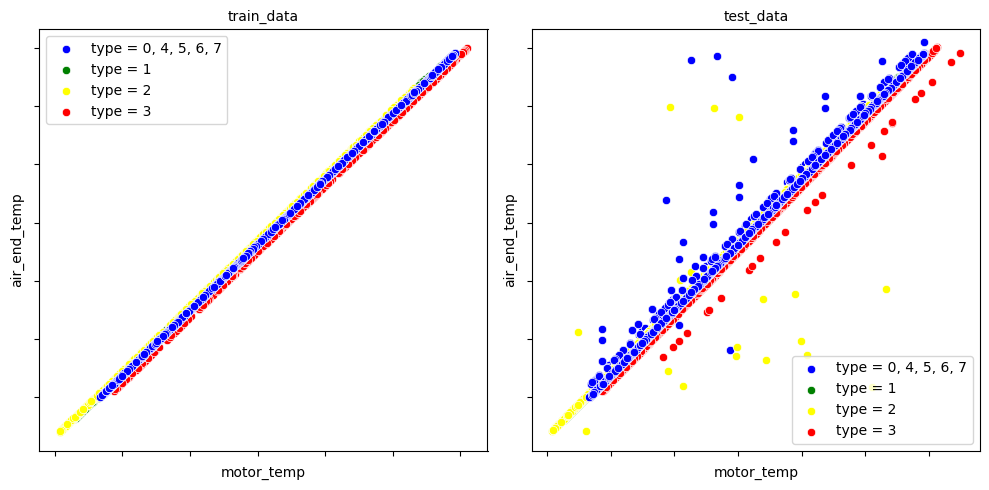

In [111]:
sub_plot_corr(train_data, test_data, 'motor_temp', 'air_end_temp')

## 모터 전류당 말단 온도

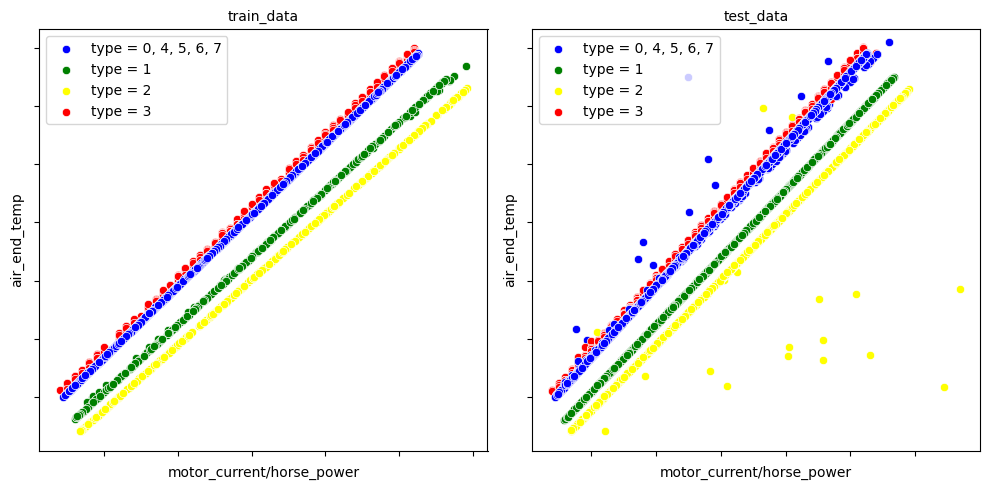

In [112]:
sub_plot_corr(train_data, test_data, 'motor_current/horse_power', 'air_end_temp')

In [113]:
train_data = custom_split_data(train_data, 'motor_current', 'motor_rpm')
test_data = custom_split_data(test_data, 'motor_current', 'motor_rpm')

  0%|          | 0/2447 [00:00<?, ?it/s]

  0%|          | 0/7389 [00:00<?, ?it/s]

## rpm당 전류

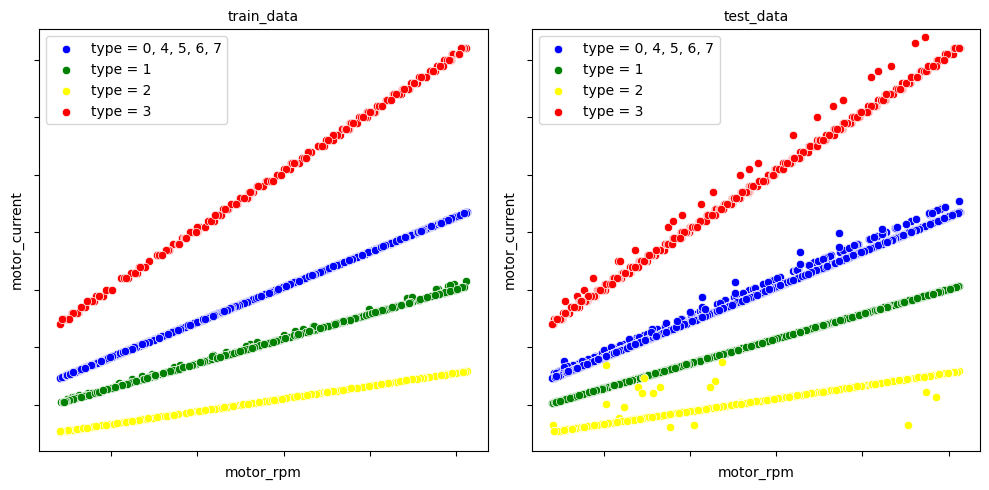

In [114]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'motor_current')

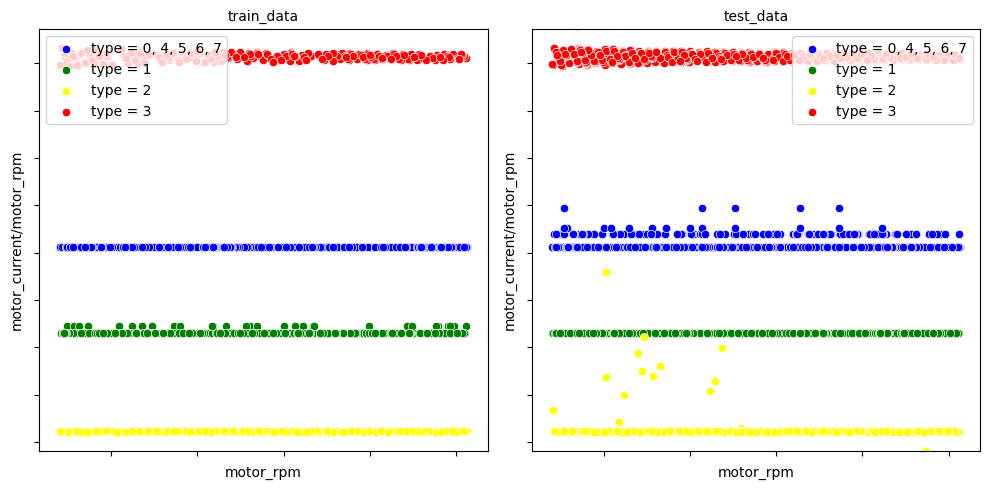

In [115]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'motor_current/motor_rpm')

In [116]:
train_data[train_data['out_pressure']!=0.7]

Empty DataFrame
Columns: [air_inflow, air_end_temp, out_pressure, motor_current, motor_rpm, motor_temp, motor_vibe, type, motor_rpm/motor_current, air_inflow/motor_current, motor_current/horse_power, motor_current*motor_rpm/horse_power, air_inflow/horse_power, motor_rpm/horse_power, air_inflow/horse_power2, air_inflow/motor_rpm, motor_vibe/motor_rpm, air_inflow/motor_rpm/horse_power, motor_current/motor_rpm]
Index: []

In [117]:
test_data[test_data['out_pressure']!=0.7]

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
4917        3.09         60.88          0.60          39.97     3270.0   
4918        2.95         59.09          0.60          38.22     3127.0   
4919        1.90         45.09          0.54          24.53     2007.0   
4920        2.66         55.16          0.50          34.38     2813.0   
4921        2.39         51.68          0.50          30.97     2534.0   
4922        1.46         39.35          0.49          18.92     1548.0   
4923        2.85         57.75          0.49          36.91     3020.0   

      motor_temp  motor_vibe  type  motor_rpm/motor_current  \
4917       76.33        3.82     4                81.811359   
4918       74.74        3.74     4                81.815803   
4919       62.30        3.12     4                81.818182   
4920       71.26        3.56     4                81.820826   
4921       68.16        3.41     4                81.821117   
4922       57.20        2.86     4                81.818182   
4923       73.56        3.68     4                81.820645   

      air_inflow/motor_current  motor_current/horse_power  \
4917                  0.077308                   1.332333   
4918                  0.077185                   1.274000   
4919                  0.077456                   0.817667   
4920                  0.077371                   1.146000   
4921                  0.077171                   1.032333   
4922                  0.077167                   0.630667   
4923                  0.077215                   1.230333   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
4917                          4356.730000                0.103000   
4918                          3983.798000                0.098333   
4919                          1641.057000                0.063333   
4920                          3223.698000                0.088667   
4921                          2615.932667                0.079667   
4922                           976.272000                0.048667   
4923                          3715.606667                0.095000   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
4917             109.000000                 0.343333              0.000945   
4918             104.233333                 0.327778              0.000943   
4919              66.900000                 0.211111              0.000947   
4920              93.766667                 0.295556              0.000946   
4921              84.466667                 0.265556              0.000943   
4922              51.600000                 0.162222              0.000943   
4923             100.666667                 0.316667              0.000944   

      motor_vibe/motor_rpm  air_inflow/motor_rpm/horse_power  \
4917              0.001168                               NaN   
4918              0.001196                               NaN   
4919              0.001555                               NaN   
4920              0.001266                               NaN   
4921              0.001346                               NaN   
4922              0.001848                               NaN   
4923              0.001219                               NaN   

      motor_current/motor_rpm  
4917                 0.012223  
4918                 0.012223  
4919                 0.012222  
4920                 0.012222  
4921                 0.012222  
4922                 0.012222  
4923                 0.012222

out_pressure이 0.7이 아닌 것은 검은색으로 표현해서 다시 plot해보겠습니다.

In [118]:
test_data[test_data['type']==4]

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
4419        2.20         49.14           0.7          28.49     2331.0   
4420        2.02         46.78           0.7          26.18     2142.0   
4421        1.57         40.78           0.7          20.31     1662.0   
4422        2.45         52.36           0.7          31.64     2589.0   
4423        1.90         45.20           0.7          24.64     2016.0   
...          ...           ...           ...            ...        ...   
5332        2.53         53.45           0.7          32.71     2676.0   
5333        2.54         53.65           0.7          32.90     2692.0   
5334        2.16         48.56           0.7          27.93     2285.0   
5335        1.76         43.26           0.7          22.75     1861.0   
5336        2.36         51.29           0.7          30.59     2503.0   

      motor_temp  motor_vibe  type  motor_rpm/motor_current  \
4419       65.90        3.30     4                81.818182   
4420       63.80        3.19     4                81.818182   
4421       58.47        2.92     4                81.831610   
4422       68.77        3.44     4                81.826802   
4423       62.40        3.12     4                81.818182   
...          ...         ...   ...                      ...   
5332       69.73        3.49     4                81.809844   
5333       69.91        3.50     4                81.823708   
5334       65.39        3.27     4                81.811672   
5335       60.68        3.03     4                81.802198   
5336       67.81        3.39     4                81.824126   

      air_inflow/motor_current  motor_current/horse_power  \
4419                  0.077220                   0.949667   
4420                  0.077158                   0.872667   
4421                  0.077302                   0.677000   
4422                  0.077434                   1.054667   
4423                  0.077110                   0.821333   
...                        ...                        ...   
5332                  0.077346                   1.090333   
5333                  0.077204                   1.096667   
5334                  0.077336                   0.931000   
5335                  0.077363                   0.758333   
5336                  0.077149                   1.019667   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
4419                          2213.673000                0.073333   
4420                          1869.252000                0.067333   
4421                          1125.174000                0.052333   
4422                          2730.532000                0.081667   
4423                          1655.808000                0.063333   
...                                   ...                     ...   
5332                          2917.732000                0.084333   
5333                          2952.226667                0.084667   
5334                          2127.335000                0.072000   
5335                          1411.258333                0.058667   
5336                          2552.225667                0.078667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
4419              77.700000                 0.244444              0.000944   
4420              71.400000                 0.224444              0.000943   
4421              55.400000                 0.174444              0.000945   
4422              86.300000                 0.272222              0.000946   
4423              67.200000                 0.211111              0.000942   
...                     ...                      ...                   ...   
5332              89.200000                 0.281111              0.000945   
5333              89.733333                 0.282222              0.000944   
5334              76.166667                 0.240000              0.000945   
5335              

In [106]:
def sub_plot_corr_plus(data,data2,  name1, name2):
  plt.figure(figsize=(10,5))
  correlation = data[name1].corr(data[name2])
  j = 0
  color = ['green', 'yellow', 'red']
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type'] == i]
    plt.subplot(1,2,1)
    if i == 1 or i == 2 or i == 3:
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue')
  g.set_title("train_data", size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  j = 0
  for i in range(8):
    globals()['data{}'.format(i)] = data2[data2['type'] == i]
    plt.subplot(1,2,2)
    if i == 1 or i == 2 or i == 3:
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue') 
  data_ = data4[data4['out_pressure']!=0.7] 
  g2 = sns.scatterplot(data=data_, x=name1, y=name2, color='black') 
  g2.set_title("test_data", size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  plt.tight_layout()
  plt.show()

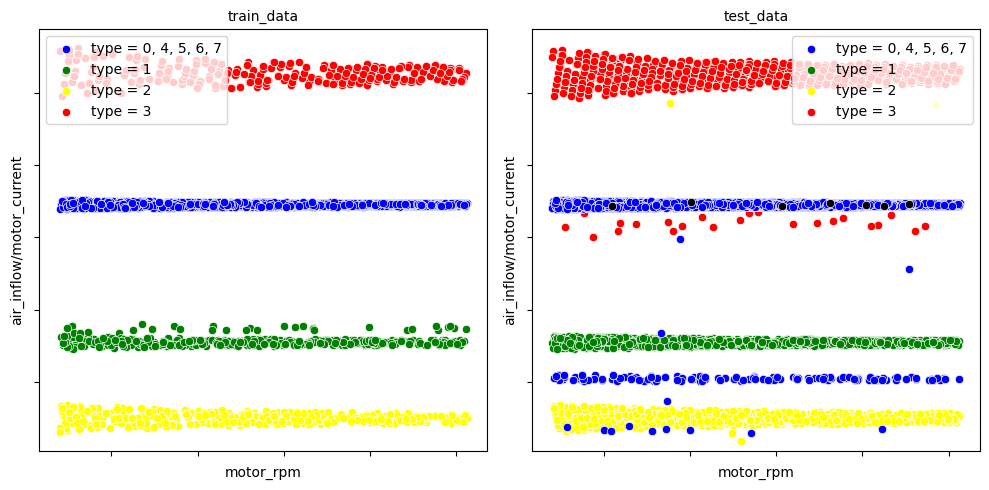

In [107]:
sub_plot_corr_plus(train_data, test_data, 'motor_rpm', 'air_inflow/motor_current')

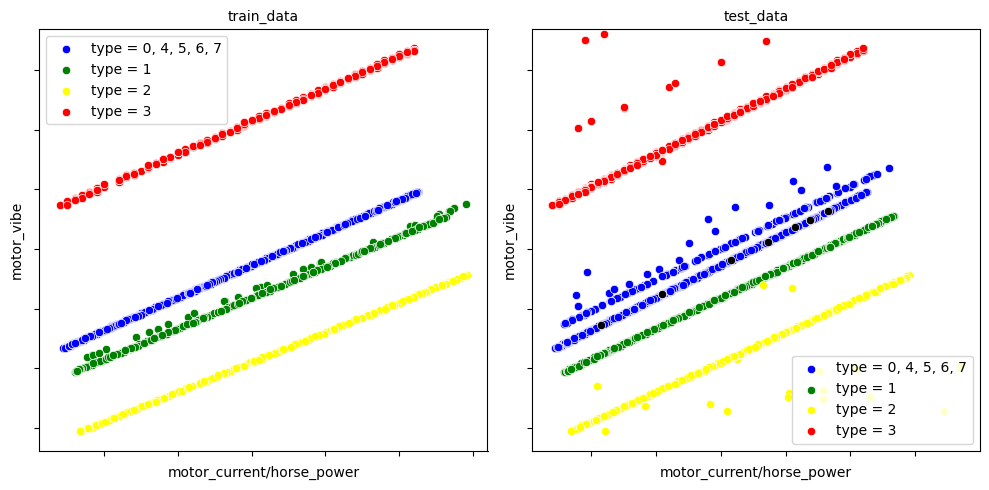

In [121]:
sub_plot_corr_plus(train_data, test_data, 'motor_current/horse_power', 'motor_vibe')

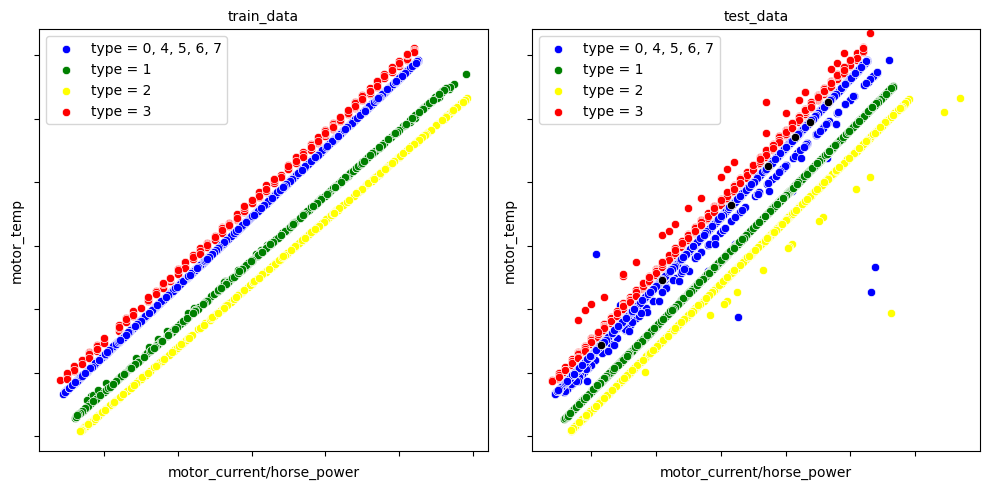

In [122]:
sub_plot_corr_plus(train_data, test_data, 'motor_current/horse_power', 'motor_temp')

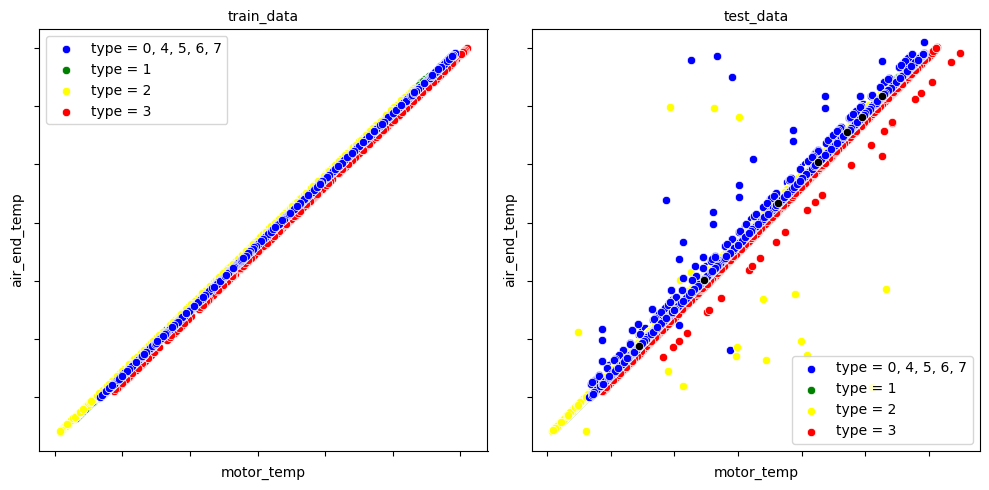

In [123]:
sub_plot_corr_plus(train_data, test_data, 'motor_temp', 'air_end_temp')

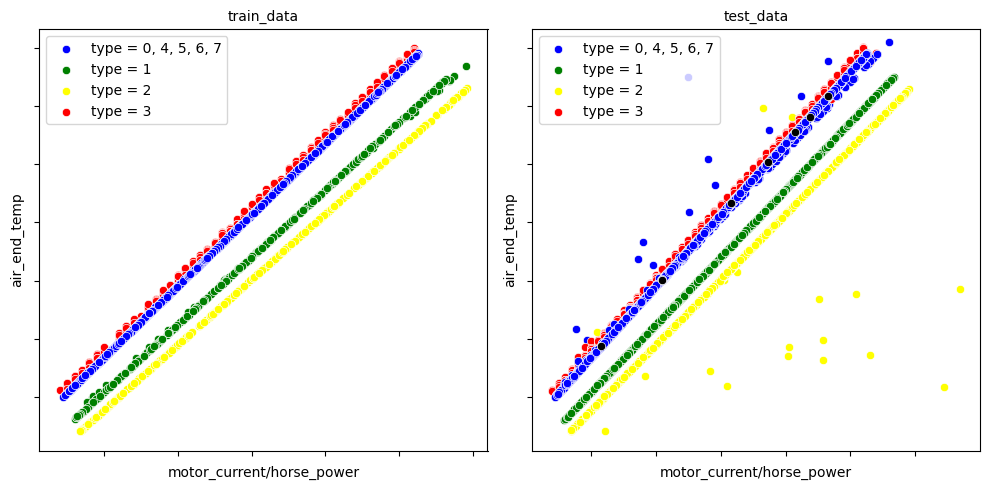

In [124]:
sub_plot_corr_plus(train_data, test_data, 'motor_current/horse_power', 'air_end_temp')

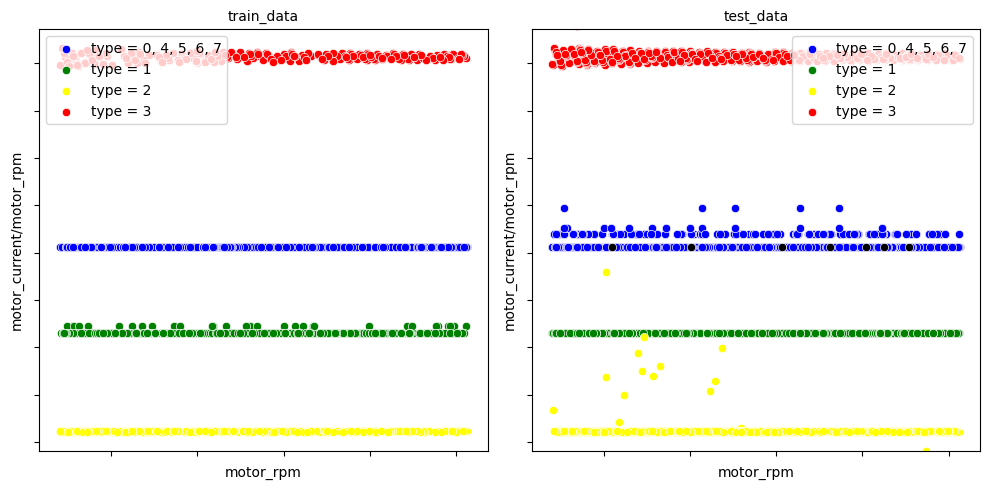

In [125]:
sub_plot_corr_plus(train_data, test_data, 'motor_rpm', 'motor_current/motor_rpm')

type 0, 4, 5, 6, 7도 나눠서 표현해보겠습니다.

In [108]:
def sub_plot_corr_plus2(data,data2,  name1, name2):
  plt.figure(figsize=(10,5))
  correlation = data[name1].corr(data[name2])
  k = 0
  j = 0
  color = ['green', 'yellow', 'red']
  color2 = ['#03ffee','#003ea1','#0b9630','#7e02ab','#a1790d']
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type'] == i]
    plt.subplot(1,2,1)
    if i == 1 or i == 2 or i == 3:
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color2[k]) 
      k += 1
  g.set_title("train_data", size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = 0','type = 1', 'type = 2','type = 3', 'type = 4', 'type = 5', 'type = 6', 'type = 7'])
  j = 0
  k = 0
  for i in range(8):
    globals()['data{}'.format(i)] = data2[data2['type'] == i]
    plt.subplot(1,2,2)
    if i == 1 or i == 2 or i == 3:
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color2[k]) 
      k += 1
  g2.set_title("test_data", size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = 0','type = 1', 'type = 2','type = 3', 'type = 4', 'type = 5', 'type = 6', 'type = 7'])
  plt.tight_layout()
  plt.show()

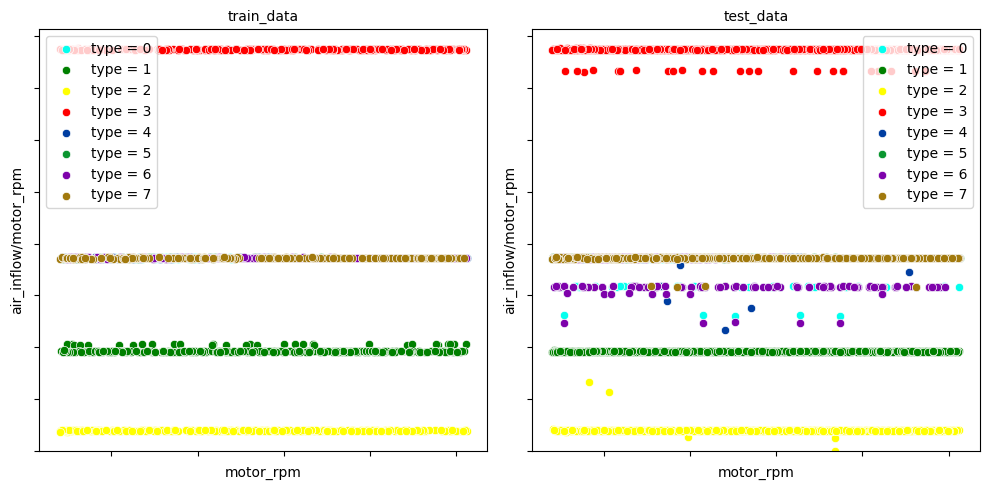

In [127]:
sub_plot_corr_plus2(train_data, test_data, 'motor_rpm', 'air_inflow/motor_rpm')

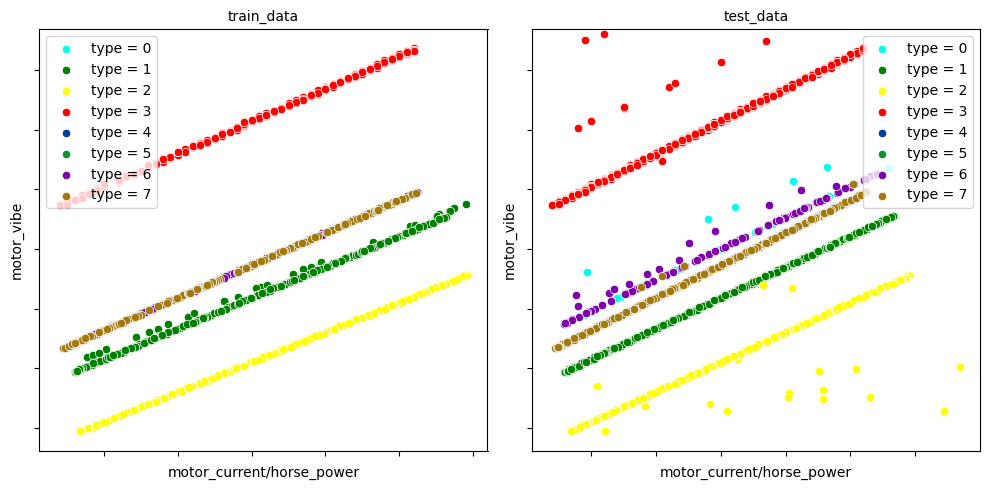

In [128]:
sub_plot_corr_plus2(train_data, test_data, 'motor_current/horse_power', 'motor_vibe')

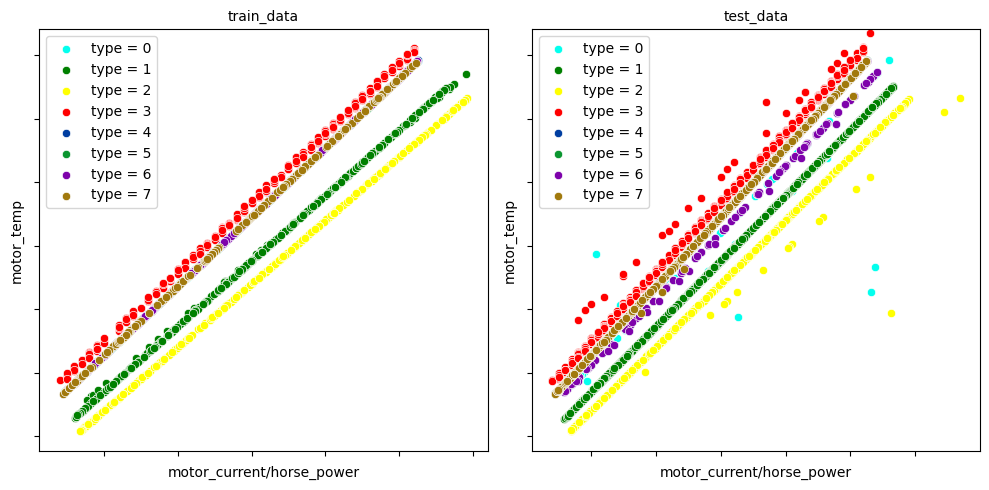

In [129]:
sub_plot_corr_plus2(train_data, test_data, 'motor_current/horse_power', 'motor_temp')

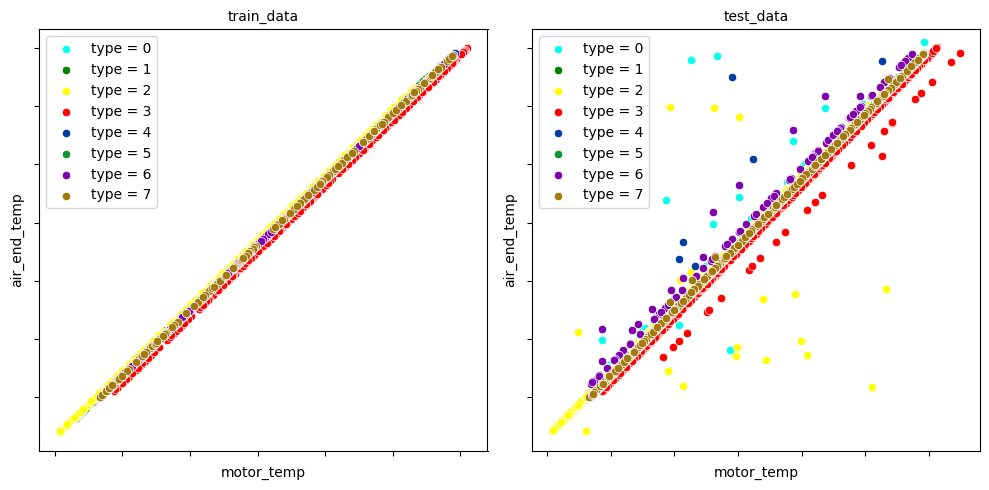

In [130]:
sub_plot_corr_plus2(train_data, test_data, 'motor_temp', 'air_end_temp')

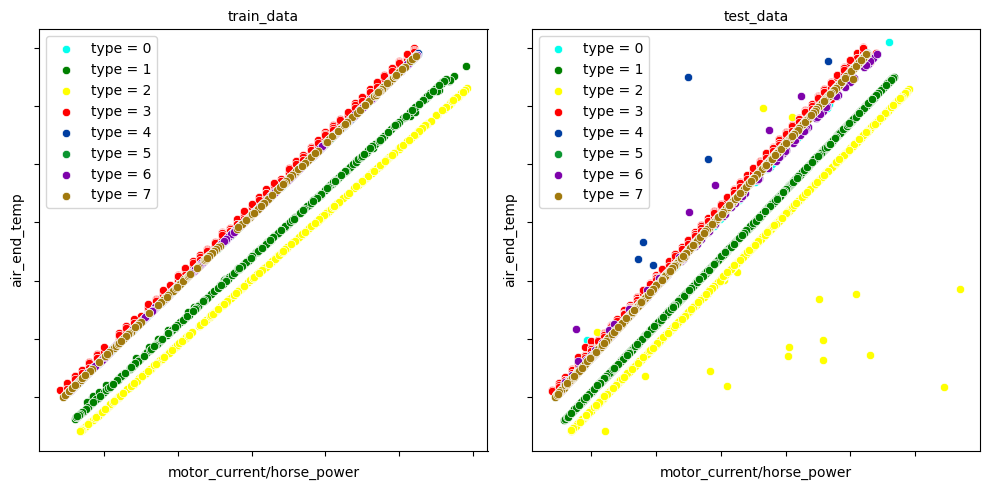

In [131]:
sub_plot_corr_plus2(train_data, test_data, 'motor_current/horse_power', 'air_end_temp')

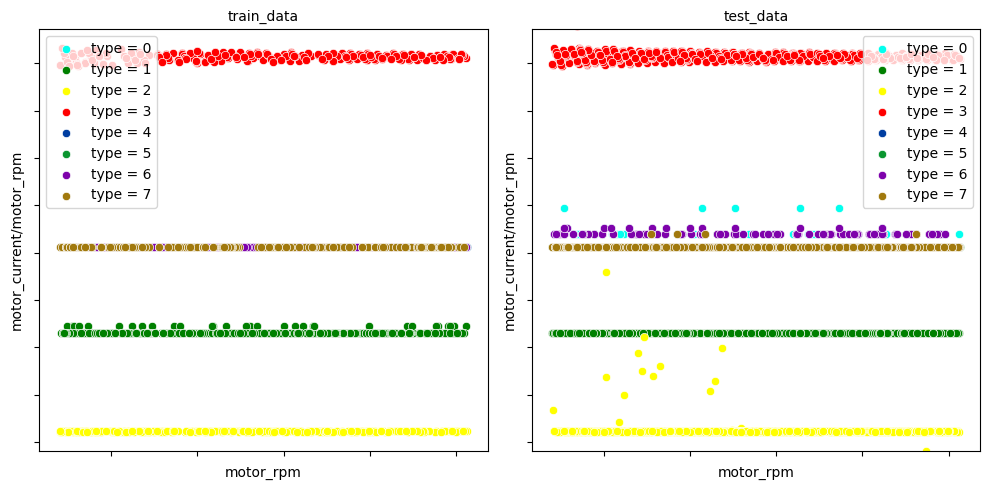

In [132]:
sub_plot_corr_plus2(train_data, test_data, 'motor_rpm', 'motor_current/motor_rpm')

# 비지도학습

마력별로 나눠서 데이터를 표현해보겠습니다.

In [109]:
train_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           1.59         41.00           0.7          20.53     1680.0   
1           2.97         59.28           0.7          38.40     3142.0   
2           1.91         45.29           0.7          24.73     2023.0   
3           2.37         51.33           0.7          30.63     2506.0   
4           1.90         45.21           0.7          24.65     2017.0   
...          ...           ...           ...            ...        ...   
2442        2.28         50.20           0.7          29.53     2416.0   
2443        2.04         46.94           0.7          26.34     2155.0   
2444        1.19         35.74           0.7          15.39     1259.0   
2445        1.21         36.00           0.7          15.64     1280.0   
2446        2.72         55.99           0.7          35.19     2879.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
2442       66.84        3.34     7     train                81.815103   
2443       63.94        3.20     7     train                81.814730   
2444       53.99        2.70     7     train                81.806368   
2445       54.22        2.71     7     train                81.841432   
2446       71.99        3.60     7     train                81.813015   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
2442                  0.077210                   0.984333   
2443                  0.077449                   0.878000   
2444                  0.077323                   0.513000   
2445                  0.077366                   0.521333   
2446                  0.077295                   1.173000   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
2442                          2378.149333                0.076000   
2443                          1892.090000                0.068000   
2444                           645.867000                0.039667   
2445                           667.306667                0.040333   
2446                          3377.067000                0.090667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
2442              80.533333                 0.253333              0.000944   
2443              71.833333                 0.226667  

In [110]:
test_data

air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0           2.51         53.28           0.7          32.54     2662.0   
1           2.66         55.24           0.7          34.45     2819.0   
2           1.72         42.74           0.7          22.23     1819.0   
3           2.20         49.15           0.7          28.50     2332.0   
4           2.06         47.28           0.7          26.67     2182.0   
...          ...           ...           ...            ...        ...   
7384        2.12         48.08           0.7          27.45     2246.0   
7385        1.48         39.63           0.7          19.19     1570.0   
7386        1.56         40.61           0.7          20.15     1649.0   
7387        1.59         40.99           0.7          20.52     1679.0   
7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          69.58        3.48     0      test                81.807007   
1          71.32        3.57     0      test                81.828737   
2          60.21        3.01     0      test                81.826361   
3          65.91        3.30     0      test                81.824561   
4          64.24        3.21     0      test                81.814773   
...          ...         ...   ...       ...                      ...   
7384       64.96        3.25     7      test                81.821494   
7385       57.44        2.87     7      test                81.813445   
7386       58.32        2.92     7      test                81.836228   
7387       58.66        2.93     7      test                81.822612   
7388       60.01        3.00     7      test                81.826443   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077136                   1.084667   
1                     0.077213                   1.148333   
2                     0.077373                   0.741000   
3                     0.077193                   0.950000   
4                     0.077240                   0.889000   
...                        ...                        ...   
7384                  0.077231                   0.915000   
7385                  0.077124                   0.639667   
7386                  0.077419                   0.671667   
7387                  0.077485                   0.684000   
7388                  0.077238                   0.733667   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             2887.382667                0.083667   
1                             3237.151667                0.088667   
2                             1347.879000                0.057333   
3                             2215.400000                0.073333   
4                             1939.798000                0.068667   
...                                   ...                     ...   
7384                          2055.090000                0.070667   
7385                          1004.276667                0.049333   
7386                          1107.578333                0.052000   
7387                          1148.436000                0.053000   
7388                          1321.333667                0.056667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 88.733333                 0.278889              0.000943   
1                 93.966667                 0.295556              0.000944   
2                 60.633333                 0.191111              0.000946   
3                 77.733333                 0.244444              0.000943   
4                 72.733333                 0.228889              0.000944   
...                     ...                      ...                   ...   
7384              74.866667                 0.235556              0.000944   
7385              52.333333                 0.164444  

In [111]:
sum_data = pd.concat([train_data, test_data]).reset_index()
sum_data

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0         0        1.59         41.00           0.7          20.53     1680.0   
1         1        2.97         59.28           0.7          38.40     3142.0   
2         2        1.91         45.29           0.7          24.73     2023.0   
3         3        2.37         51.33           0.7          30.63     2506.0   
4         4        1.90         45.21           0.7          24.65     2017.0   
...     ...         ...           ...           ...            ...        ...   
9831   7384        2.12         48.08           0.7          27.45     2246.0   
9832   7385        1.48         39.63           0.7          19.19     1570.0   
9833   7386        1.56         40.61           0.7          20.15     1649.0   
9834   7387        1.59         40.99           0.7          20.52     1679.0   
9835   7388        1.70         42.51           0.7          22.01     1801.0   

      motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0          58.67        2.93     0     train                81.831466   
1          74.91        3.75     0     train                81.822917   
2          62.48        3.12     0     train                81.803478   
3          67.84        3.39     0     train                81.815214   
4          62.41        3.12     0     train                81.825558   
...          ...         ...   ...       ...                      ...   
9831       64.96        3.25     7      test                81.821494   
9832       57.44        2.87     7      test                81.813445   
9833       58.32        2.92     7      test                81.836228   
9834       58.66        2.93     7      test                81.822612   
9835       60.01        3.00     7      test                81.826443   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
9831                  0.077231                   0.915000   
9832                  0.077124                   0.639667   
9833                  0.077419                   0.671667   
9834                  0.077485                   0.684000   
9835                  0.077238                   0.733667   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
9831                          2055.090000                0.070667   
9832                          1004.276667                0.049333   
9833                          1107.578333                0.052000   
9834                          1148.436000                0.053000   
9835                          1321.333667                0.056667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
9831              74.866667                 0.23

In [112]:
for i in range(8):
  globals()['test_data_{}'.format(i)] = test_data[test_data['type'] == i].reset_index()
for i in range(8):
  globals()['train_data_{}'.format(i)] = train_data[train_data['type'] == i].reset_index()
for i in range(8):
  globals()['sum_data_{}'.format(i)] = sum_data[sum_data['type'] == i].reset_index()

In [113]:
sum_data_0

level_0  index  air_inflow  air_end_temp  out_pressure  motor_current  \
0           0      0        1.59         41.00           0.7          20.53   
1           1      1        2.97         59.28           0.7          38.40   
2           2      2        1.91         45.29           0.7          24.73   
3           3      3        2.37         51.33           0.7          30.63   
4           4      4        1.90         45.21           0.7          24.65   
...       ...    ...         ...           ...           ...            ...   
1723     3738   1291        1.29         37.05           0.7          16.67   
1724     3739   1292        3.16         61.79           0.7          40.86   
1725     3740   1293        1.23         36.28           0.7          15.91   
1726     3741   1294        1.18         35.68           0.7          15.33   
1727     3742   1295        2.38         51.48           0.7          30.78   

      motor_rpm  motor_temp  motor_vibe  type  ... motor_rpm/motor_current  \
0        1680.0       58.67        2.93     0  ...               81.831466   
1        3142.0       74.91        3.75     0  ...               81.822917   
2        2023.0       62.48        3.12     0  ...               81.803478   
3        2506.0       67.84        3.39     0  ...               81.815214   
4        2017.0       62.41        3.12     0  ...               81.825558   
...         ...         ...         ...   ...  ...                     ...   
1723     1364.0       55.16        2.76     0  ...               81.823635   
1724     3343.0       77.14        3.86     0  ...               81.815957   
1725     1302.0       54.47        2.72     0  ...               81.835324   
1726     1254.0       53.93        2.70     0  ...               81.800391   
1727     2518.0       67.98        3.40     0  ...               81.806368   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
1723                  0.077385                   0.555667   
1724                  0.077337                   1.362000   
1725                  0.077310                   0.530333   
1726                  0.076973                   0.511000   
1727                  0.077323                   1.026000   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
1723                           757.929333                0.043000   
1724                          4553.166000                0.105333   
1725                           690.494000                0.041000   
1726                           640.794000                0.039333   
1727                          2583.468000                0.079333   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
1723        

In [138]:
train_data_0

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0        0        1.59         41.00           0.7          20.53     1680.0   
1        1        2.97         59.28           0.7          38.40     3142.0   
2        2        1.91         45.29           0.7          24.73     2023.0   
3        3        2.37         51.33           0.7          30.63     2506.0   
4        4        1.90         45.21           0.7          24.65     2017.0   
..     ...         ...           ...           ...            ...        ...   
427    427        1.32         37.49           0.7          17.10     1399.0   
428    428        1.80         43.85           0.7          23.32     1908.0   
429    429        2.79         56.99           0.7          36.17     2959.0   
430    430        2.25         49.79           0.7          29.13     2383.0   
431    431        1.52         40.15           0.7          19.70     1612.0   

     motor_temp  motor_vibe  type  motor_rpm/motor_current  \
0         58.67        2.93     0                81.831466   
1         74.91        3.75     0                81.822917   
2         62.48        3.12     0                81.803478   
3         67.84        3.39     0                81.815214   
4         62.41        3.12     0                81.825558   
..          ...         ...   ...                      ...   
427       55.54        2.78     0                81.812865   
428       61.20        3.06     0                81.818182   
429       72.88        3.64     0                81.808128   
430       66.48        3.32     0                81.805699   
431       57.91        2.90     0                81.827411   

     air_inflow/motor_current  motor_current/horse_power  \
0                    0.077448                   0.684333   
1                    0.077344                   1.280000   
2                    0.077234                   0.824333   
3                    0.077375                   1.021000   
4                    0.077079                   0.821667   
..                        ...                        ...   
427                  0.077193                   0.570000   
428                  0.077187                   0.777333   
429                  0.077136                   1.205667   
430                  0.077240                   0.971000   
431                  0.077157                   0.656667   

     motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                            1149.680000                0.053000   
1                            4021.760000                0.099000   
2                            1667.626333                0.063667   
3                            2558.626000                0.079000   
4                            1657.301667                0.063333   
..                                   ...                     ...   
427                           797.430000                0.044000   
428                          1483.152000                0.060000   
429                          3567.567667                0.093000   
430                          2313.893000                0.075000   
431                          1058.546667                0.050667   

     motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                56.000000                 0.176667              0.000946   
1               104.733333                 0.330000              0.000945   
2                67.433333                 0.212222              0.000944   
3                83.533333                 0.263333              0.000946   
4                67.233333                 0.211111              0.000942   
..                     ...                      ...                   ...   
427              46.633333                 0.146667              0.000944   
428              63.600000                 0.200000              0.000943   
429              98.633333                 0.310000              0.0

In [139]:
test_data_0

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0         0        2.51         53.28           0.7          32.54     2662.0   
1         1        2.66         55.24           0.7          34.45     2819.0   
2         2        1.72         42.74           0.7          22.23     1819.0   
3         3        2.20         49.15           0.7          28.50     2332.0   
4         4        2.06         47.28           0.7          26.67     2182.0   
...     ...         ...           ...           ...            ...        ...   
1291   1291        1.29         37.05           0.7          16.67     1364.0   
1292   1292        3.16         61.79           0.7          40.86     3343.0   
1293   1293        1.23         36.28           0.7          15.91     1302.0   
1294   1294        1.18         35.68           0.7          15.33     1254.0   
1295   1295        2.38         51.48           0.7          30.78     2518.0   

      motor_temp  motor_vibe  type  motor_rpm/motor_current  \
0          69.58        3.48     0                81.807007   
1          71.32        3.57     0                81.828737   
2          60.21        3.01     0                81.826361   
3          65.91        3.30     0                81.824561   
4          64.24        3.21     0                81.814773   
...          ...         ...   ...                      ...   
1291       55.16        2.76     0                81.823635   
1292       77.14        3.86     0                81.815957   
1293       54.47        2.72     0                81.835324   
1294       53.93        2.70     0                81.800391   
1295       67.98        3.40     0                81.806368   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077136                   1.084667   
1                     0.077213                   1.148333   
2                     0.077373                   0.741000   
3                     0.077193                   0.950000   
4                     0.077240                   0.889000   
...                        ...                        ...   
1291                  0.077385                   0.555667   
1292                  0.077337                   1.362000   
1293                  0.077310                   0.530333   
1294                  0.076973                   0.511000   
1295                  0.077323                   1.026000   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             2887.382667                0.083667   
1                             3237.151667                0.088667   
2                             1347.879000                0.057333   
3                             2215.400000                0.073333   
4                             1939.798000                0.068667   
...                                   ...                     ...   
1291                           757.929333                0.043000   
1292                          4553.166000                0.105333   
1293                           690.494000                0.041000   
1294                           640.794000                0.039333   
1295                          2583.468000                0.079333   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 88.733333                 0.278889              0.000943   
1                 93.966667                 0.295556              0.000944   
2                 60.633333                 0.191111              0.000946   
3                 77.733333                 0.244444              0.000943   
4                 72.733333                 0.228889              0.000944   
...                     ...                      ...                   ...   
1291              45.466667                 0.143333              0.000946   
1292             111.433333                 0.351111              0.000945   
1293        

In [114]:
def sub_plot_type(data1, data2, type1, name1, name2):
  plt.figure(figsize=(10,5))
  color = ['#03ffee', 'green', 'yellow', 'red', '#003ea1','#0b9630','#7e02ab','#a1790d']
  plt.subplot(1,2,1)
  g = sns.scatterplot(data=data1, x=name1, y=name2, color=color[type1])
  g.set_title('test_data', size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = '+str(type1)])

  plt.subplot(1,2,2)
  g2 = sns.scatterplot(data=data2, x=name1, y=name2, color=color[type1])
  g2.set_title('train_data', size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = '+str(type1)])
  plt.tight_layout()
  plt.show()

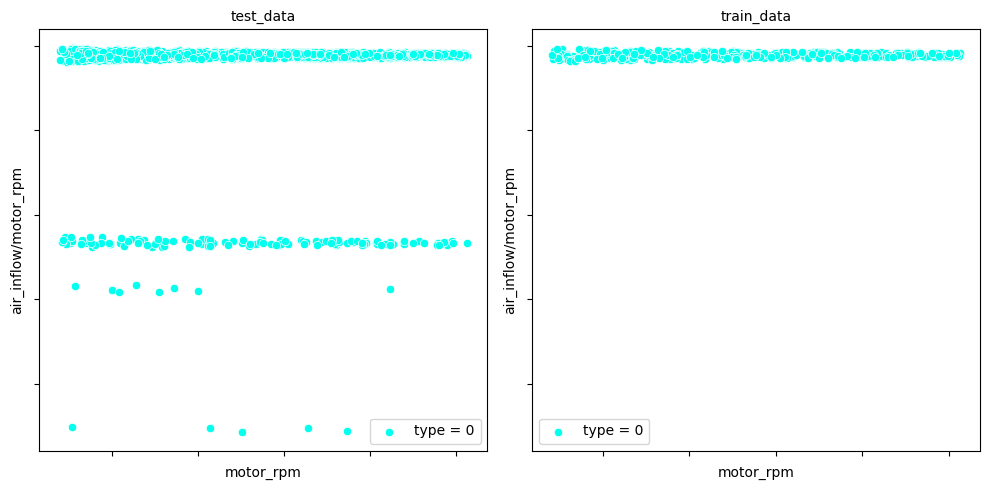

In [115]:
sub_plot_type(test_data_0, train_data_0, 0, 'motor_rpm', 'air_inflow/motor_rpm')

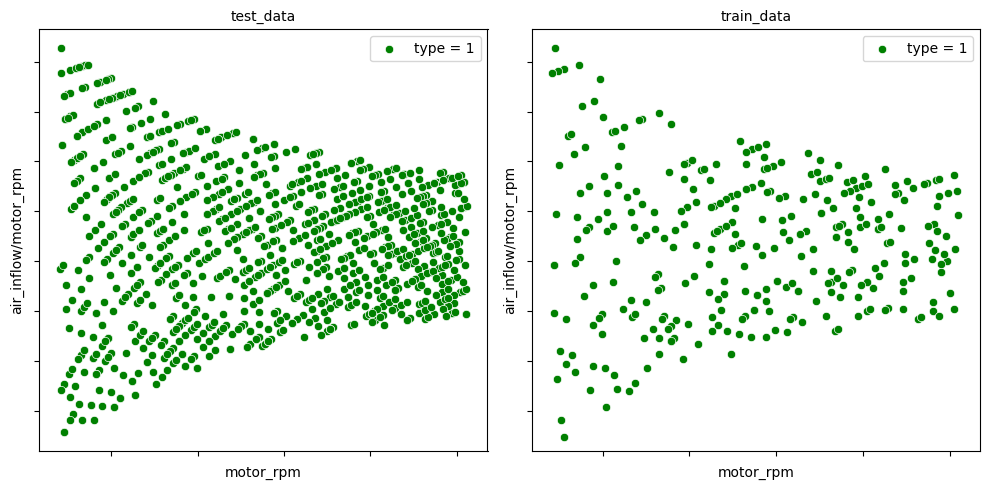

In [116]:
sub_plot_type(test_data_1, train_data_1, 1, 'motor_rpm', 'air_inflow/motor_rpm')

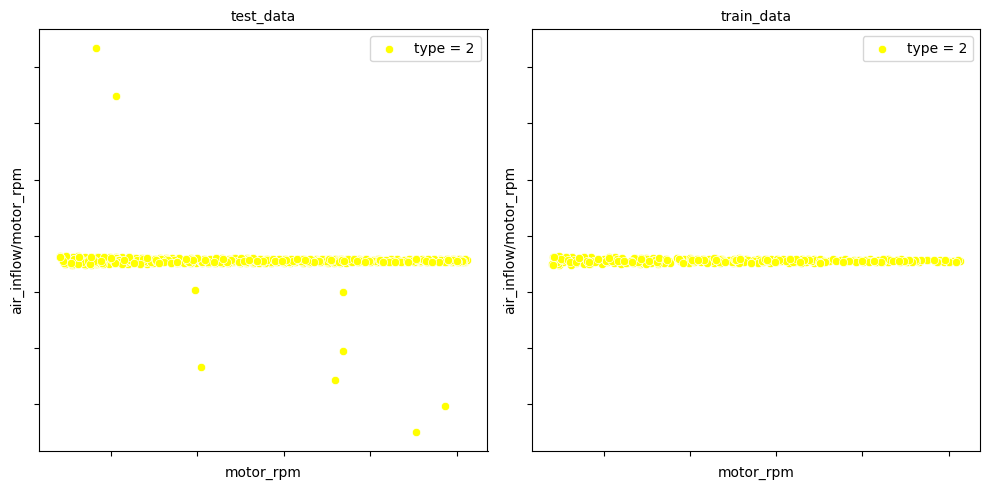

In [117]:
sub_plot_type(test_data_2, train_data_2, 2, 'motor_rpm', 'air_inflow/motor_rpm')

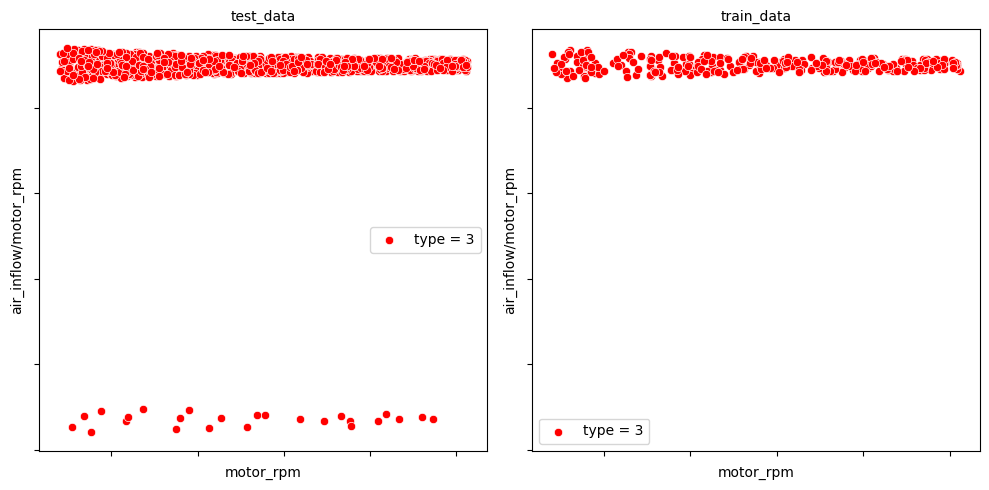

In [118]:
sub_plot_type(sum_data_3, train_data_3, 3, 'motor_rpm', 'air_inflow/motor_rpm')

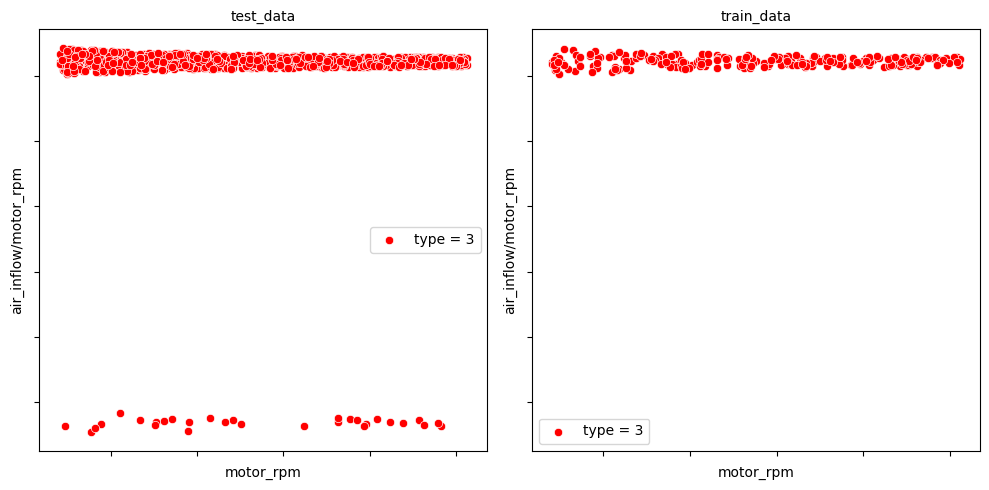

In [119]:
sub_plot_type(sum_data_5, train_data_5, 3, 'motor_rpm', 'air_inflow/motor_rpm')

In [123]:
X = sum_data_3['motor_rpm']
y = sum_data_3['air_inflow/motor_rpm']

In [124]:
z = np.empty((len(X),len(y)))

In [125]:
z[:,0] = X
z[:,1] = y

In [126]:
from sklearn.cluster import KMeans
k = 2 
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(z)

In [127]:
y_pred

array([0, 0, 1, ..., 0, 0, 1])

In [128]:
sum_data_3['pred'] = y_pred
sum_data_3

level_0  index  air_inflow  air_end_temp  out_pressure  motor_current  \
0        1151   1151        4.73         54.30           0.7           55.0   
1        1152   1152        5.65         60.83           0.7           65.0   
2        1153   1153        2.45         37.99           0.7           28.0   
3        1154   1154        5.86         62.33           0.7           68.0   
4        1155   1155        4.43         52.15           0.7           51.0   
...       ...    ...         ...           ...           ...            ...   
1219     6861   4414        4.99         56.15           0.7           58.0   
1220     6862   4415        3.16         43.06           0.7           37.0   
1221     6863   4416        4.56         53.04           0.7           53.0   
1222     6864   4417        6.23         65.00           0.7           72.0   
1223     6865   4418        2.39         37.58           0.7           28.0   

      motor_rpm  motor_temp  motor_vibe  type  ... air_inflow/motor_current  \
0        2704.0       71.04        4.70     3  ...                 0.086000   
1        3226.0       76.84        4.99     3  ...                 0.086923   
2        1399.0       56.54        3.98     3  ...                 0.087500   
3        3346.0       78.18        5.06     3  ...                 0.086176   
4        2532.0       69.13        4.61     3  ...                 0.086863   
...         ...         ...         ...   ...  ...                      ...   
1219     2852.0       72.69        4.78     3  ...                 0.086034   
1220     1805.0       61.06        4.20     3  ...                 0.085405   
1221     2603.0       69.92        4.65     3  ...                 0.086038   
1222     3560.0       80.56        5.18     3  ...                 0.086528   
1223     1366.0       56.18        3.96     3  ...                 0.085357   

      motor_current/horse_power  motor_current*motor_rpm/horse_power  \
0                          1.10                              2974.40   
1                          1.30                              4193.80   
2                          0.56                               783.44   
3                          1.36                              4550.56   
4                          1.02                              2582.64   
...                         ...                                  ...   
1219                       1.16                              3308.32   
1220                       0.74                              1335.70   
1221                       1.06                              2759.18   
1222                       1.44                              5126.40   
1223                       0.56                               764.96   

      air_inflow/horse_power  motor_rpm/horse_power  air_inflow/horse_power2  \
0                     0.0946                  54.08                   0.1892   
1                     0.1130                  64.52                   0.2260   
2                     0.0490                  27.98                   0.0980   
3                     0.1172                  66.92                   0.2344   
4                     0.0886                  50.64                   0.1772   
...                      ...                    ...                      ...   
1219                  0.0998                  57.04                   0.1996   
1220                  0.0632                  36.10                   0.1264   
1221                  0.0912                  52.06                   0.1824   
1222                  0.1246                  71.20                   0.2492   
1223                  0.0478                  27.32                   0.0956   

      air_inflow/motor_rpm  motor_vibe/motor_rpm  \
0                 0.001749              0.001738   
1                 0.001751              0.001547   
2                 0.001751              0.002845   
3                 0.001751              0.001512   
4                 0.00

In [129]:
def sub_plot_type_result(data1, data2, type1, name1, name2):
  plt.figure(figsize=(10,5))
  color = ['#03ffee', 'green', 'yellow', 'red', '#003ea1','#0b9630','#7e02ab','#a1790d']
  plt.subplot(1,2,1)
  g = sns.scatterplot(data=data1, x=name1, y=name2, color=color[type1])
  g.set_title('sum_data', size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = '+str(type1)])

  plt.subplot(1,2,2)
  g2 = sns.scatterplot(data=data2, x=name1, y=name2, color=color[type1])
  g2.set_title('pred_data', size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = '+str(type1)])
  plt.tight_layout()
  plt.show()

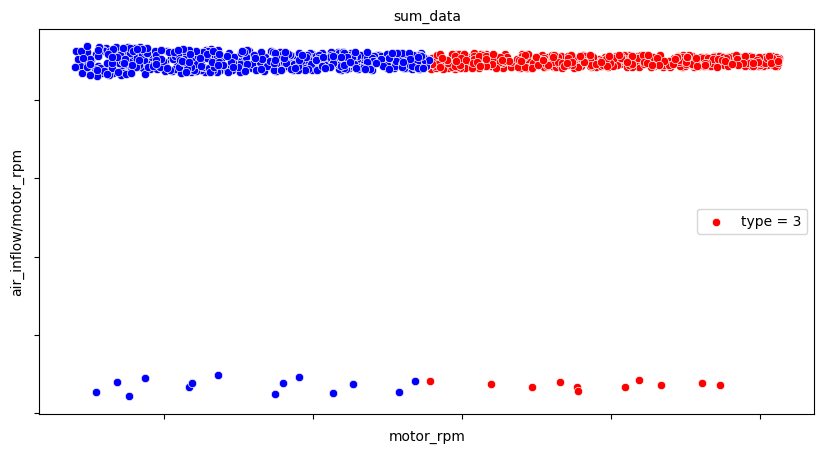

In [130]:
plt.figure(figsize=(10,5))
g = sns.scatterplot(data=sum_data_3, x='motor_rpm', y='air_inflow/motor_rpm', color='red')
data_ = sum_data_3[sum_data_3['pred'] == 1]
g = sns.scatterplot(data=data_, x='motor_rpm', y='air_inflow/motor_rpm', color='blue') 
g.set_title('sum_data', size=10)
g.set_xticklabels(g.get_xticklabels())
g.set_yticklabels(g.get_yticklabels())
plt.legend(labels=['type = 3'])

In [131]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
X = sum_data_4['motor_rpm']
y = sum_data_4['air_inflow/motor_rpm']
print(X.shape)
print(y.shape)

(1224,)
(1224,)


In [132]:
z= np.empty((len(X),len(y)))
z[:,0] = X
z[:,1] = y

In [133]:
scaler = MinMaxScaler(feature_range = (-1, 1))
X_scaled = scaler.fit_transform(z[:,0].reshape(-1,1))
y_scaled = scaler.fit_transform(z[:,1].reshape(-1,1))

In [134]:
z_scaled = np.empty((len(X_scaled),len(y_scaled)))
z_scaled[:,0] = X_scaled.reshape(1,-1)
z_scaled[:,1] = y_scaled.reshape(1,-1)

In [135]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=2, metric='euclidean')
dbscan.fit(z_scaled)

DBSCAN(eps=0.2, min_samples=2)

In [136]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [137]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1221, 1222, 1223], dtype=int64)

In [138]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ != 0
    # non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    # non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    # plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

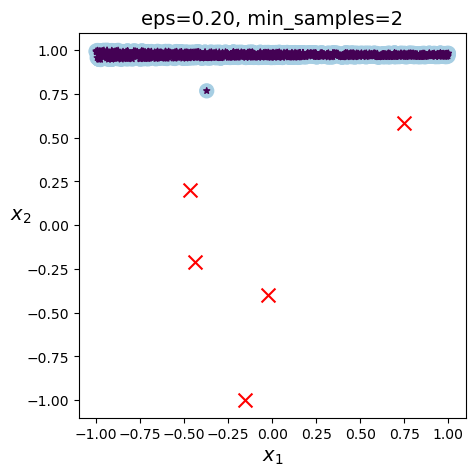

In [139]:
plt.figure(figsize=(5, 5))
plot_dbscan(dbscan, z_scaled, size=100)

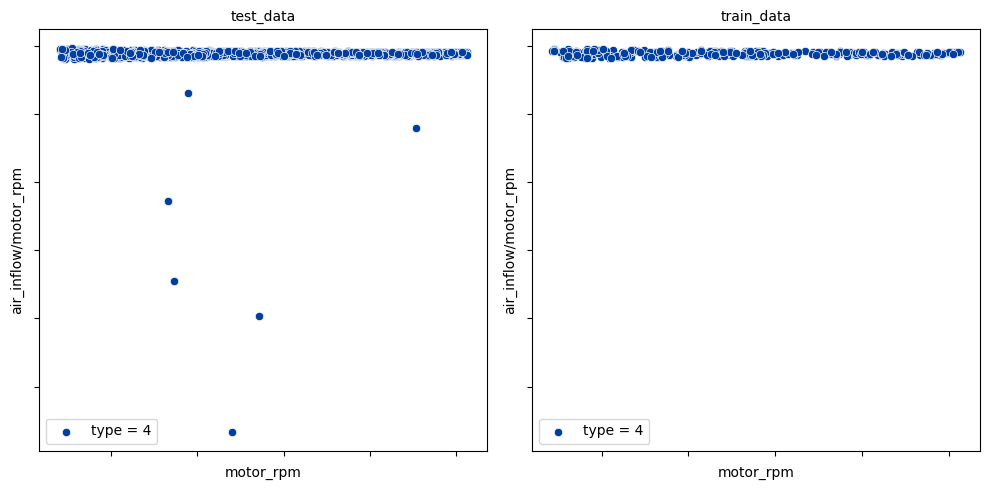

In [140]:
sub_plot_type(sum_data_4, train_data_4, 4, 'motor_rpm', 'air_inflow/motor_rpm')

In [143]:
train_data_power_30 = pd.concat([train_data_0, train_data_4, train_data_5, train_data_6, train_data_7]).reset_index()
train_data_power_20 = train_data_1
train_data_power_10 = train_data_2
train_data_power_50 = train_data_3
train_data_power_30['data_type']

0       train
1       train
2       train
3       train
4       train
        ...  
1417    train
1418    train
1419    train
1420    train
1421    train
Name: data_type, Length: 1422, dtype: object

In [165]:
train_data_power_50 

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0     1151        4.73         54.30           0.7           55.0     2704.0   
1     1152        5.65         60.83           0.7           65.0     3226.0   
2     1153        2.45         37.99           0.7           28.0     1399.0   
3     1154        5.86         62.33           0.7           68.0     3346.0   
4     1155        4.43         52.15           0.7           51.0     2532.0   
..     ...         ...           ...           ...            ...        ...   
301   1452        4.77         54.56           0.7           55.0     2725.0   
302   1453        5.51         59.86           0.7           64.0     3149.0   
303   1454        3.11         42.70           0.7           36.0     1776.0   
304   1455        5.46         59.51           0.7           63.0     3121.0   
305   1456        3.14         42.95           0.7           36.0     1796.0   

     motor_temp  motor_vibe  type  motor_rpm/motor_current  \
0         71.04        4.70     3                49.163636   
1         76.84        4.99     3                49.630769   
2         56.54        3.98     3                49.964286   
3         78.18        5.06     3                49.205882   
4         69.13        4.61     3                49.647059   
..          ...         ...   ...                      ...   
301       71.28        4.71     3                49.545455   
302       75.99        4.95     3                49.203125   
303       60.73        4.19     3                49.333333   
304       75.68        4.93     3                49.539683   
305       60.96        4.20     3                49.888889   

     air_inflow/motor_current  motor_current/horse_power  \
0                    0.086000                       1.10   
1                    0.086923                       1.30   
2                    0.087500                       0.56   
3                    0.086176                       1.36   
4                    0.086863                       1.02   
..                        ...                        ...   
301                  0.086727                       1.10   
302                  0.086094                       1.28   
303                  0.086389                       0.72   
304                  0.086667                       1.26   
305                  0.087222                       0.72   

     motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                                2974.40                  0.0946   
1                                4193.80                  0.1130   
2                                 783.44                  0.0490   
3                                4550.56                  0.1172   
4                                2582.64                  0.0886   
..                                   ...                     ...   
301                              2997.50                  0.0954   
302                              4030.72                  0.1102   
303                              1278.72                  0.0622   
304                              3932.46                  0.1092   
305                              1293.12                  0.0628   

     motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                    54.08                   0.1892              0.001749   
1                    64.52                   0.2260              0.001751   
2                    27.98                   0.0980              0.001751   
3                    66.92                   0.2344              0.001751   
4                    50.64                   0.1772              0.001750   
..                     ...                      ...                   ...   
301                  54.50                   0.1908              0.001750   
302                  62.98                   0.2204              0.001750   
303                  35.52                   0.1244              0.0

In [166]:
sum_data_4

level_0  index  air_inflow  air_end_temp  out_pressure  motor_current  \
0        1457   1457        1.20         35.93           0.7          15.57   
1        1458   1458        1.26         36.73           0.7          16.35   
2        1459   1459        2.48         52.85           0.7          32.12   
3        1460   1460        1.69         42.34           0.7          21.84   
4        1461   1461        1.95         45.81           0.7          25.24   
...       ...    ...         ...           ...           ...            ...   
1219     7779   5332        2.53         53.45           0.7          32.71   
1220     7780   5333        2.54         53.65           0.7          32.90   
1221     7781   5334        2.16         48.56           0.7          27.93   
1222     7782   5335        1.76         43.26           0.7          22.75   
1223     7783   5336        2.36         51.29           0.7          30.59   

      motor_rpm  motor_temp  motor_vibe  type  ...  air_inflow/motor_current  \
0        1274.0       54.16        2.71     4  ...                  0.077071   
1        1338.0       54.87        2.74     4  ...                  0.077064   
2        2628.0       69.20        3.46     4  ...                  0.077210   
3        1787.0       59.86        2.99     4  ...                  0.077381   
4        2065.0       62.94        3.15     4  ...                  0.077258   
...         ...         ...         ...   ...  ...                       ...   
1219     2676.0       69.73        3.49     4  ...                  0.077346   
1220     2692.0       69.91        3.50     4  ...                  0.077204   
1221     2285.0       65.39        3.27     4  ...                  0.077336   
1222     1861.0       60.68        3.03     4  ...                  0.077363   
1223     2503.0       67.81        3.39     4  ...                  0.077149   

      motor_current/horse_power  motor_current*motor_rpm/horse_power  \
0                      0.519000                           661.206000   
1                      0.545000                           729.210000   
2                      1.070667                          2813.712000   
3                      0.728000                          1300.936000   
4                      0.841333                          1737.353333   
...                         ...                                  ...   
1219                   1.090333                          2917.732000   
1220                   1.096667                          2952.226667   
1221                   0.931000                          2127.335000   
1222                   0.758333                          1411.258333   
1223                   1.019667                          2552.225667   

      air_inflow/horse_power  motor_rpm/horse_power  air_inflow/horse_power2  \
0                   0.040000              42.466667                 0.133333   
1                   0.042000              44.600000                 0.140000   
2                   0.082667              87.600000                 0.275556   
3                   0.056333              59.566667                 0.187778   
4                   0.065000              68.833333                 0.216667   
...                      ...                    ...                      ...   
1219                0.084333              89.200000                 0.281111   
1220                0.084667              89.733333                 0.282222   
1221                0.072000              76.166667                 0.240000   
1222                0.058667              62.033333                 0.195556   
1223                0.078667              83.433333                 0.262222   

      air_inflow/motor_rpm  motor_vibe/motor_rpm  \
0                 0.000942              0.002127   
1                 0.000942              0.002048   
2                 0.000944              0.001317   
3                 0.000946              0.001673   
4         

In [146]:
sum_data_power_30 = pd.concat([sum_data_0, sum_data_4, sum_data_5, sum_data_6, sum_data_7]).reset_index(drop=True)
sum_data_power_20 = sum_data_1
sum_data_power_10 = sum_data_2
sum_data_power_50 = sum_data_3
sum_data_power_30

level_0  index  air_inflow  air_end_temp  out_pressure  motor_current  \
0           0      0        1.59         41.00           0.7          20.53   
1           1      1        2.97         59.28           0.7          38.40   
2           2      2        1.91         45.29           0.7          24.73   
3           3      3        2.37         51.33           0.7          30.63   
4           4      4        1.90         45.21           0.7          24.65   
...       ...    ...         ...           ...           ...            ...   
5683     9831   7384        2.12         48.08           0.7          27.45   
5684     9832   7385        1.48         39.63           0.7          19.19   
5685     9833   7386        1.56         40.61           0.7          20.15   
5686     9834   7387        1.59         40.99           0.7          20.52   
5687     9835   7388        1.70         42.51           0.7          22.01   

      motor_rpm  motor_temp  motor_vibe  type  ... motor_rpm/motor_current  \
0        1680.0       58.67        2.93     0  ...               81.831466   
1        3142.0       74.91        3.75     0  ...               81.822917   
2        2023.0       62.48        3.12     0  ...               81.803478   
3        2506.0       67.84        3.39     0  ...               81.815214   
4        2017.0       62.41        3.12     0  ...               81.825558   
...         ...         ...         ...   ...  ...                     ...   
5683     2246.0       64.96        3.25     7  ...               81.821494   
5684     1570.0       57.44        2.87     7  ...               81.813445   
5685     1649.0       58.32        2.92     7  ...               81.836228   
5686     1679.0       58.66        2.93     7  ...               81.822612   
5687     1801.0       60.01        3.00     7  ...               81.826443   

      air_inflow/motor_current  motor_current/horse_power  \
0                     0.077448                   0.684333   
1                     0.077344                   1.280000   
2                     0.077234                   0.824333   
3                     0.077375                   1.021000   
4                     0.077079                   0.821667   
...                        ...                        ...   
5683                  0.077231                   0.915000   
5684                  0.077124                   0.639667   
5685                  0.077419                   0.671667   
5686                  0.077485                   0.684000   
5687                  0.077238                   0.733667   

      motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                             1149.680000                0.053000   
1                             4021.760000                0.099000   
2                             1667.626333                0.063667   
3                             2558.626000                0.079000   
4                             1657.301667                0.063333   
...                                   ...                     ...   
5683                          2055.090000                0.070667   
5684                          1004.276667                0.049333   
5685                          1107.578333                0.052000   
5686                          1148.436000                0.053000   
5687                          1321.333667                0.056667   

      motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                 56.000000                 0.176667              0.000946   
1                104.733333                 0.330000              0.000945   
2                 67.433333                 0.212222              0.000944   
3                 83.533333                 0.263333              0.000946   
4                 67.233333                 0.211111              0.000942   
...                     ...                      ...                   ...   
5683        

In [147]:
def sub_plot_power(data1, data2, data3, data4, name1, name2):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  g = sns.scatterplot(data=data1, x=name1, y=name2)
  g.set_title('sum_data', size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['sum_data'])

  plt.subplot(1,2,2)
  g2 = sns.scatterplot(data=data2, x=name1, y=name2)
  g2.set_title('train_data', size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=[''])
  plt.tight_layout()
  plt.show()

In [148]:
def sub_plot_power_all(data1, data2, data3, data4, name1, name2):
  plt.figure(figsize=(10,5))
  plt.subplot(2,2,1)
  g = sns.scatterplot(data=data1, x=name1, y=name2)
  g.set_title('power = 10', size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['sum_data'])

  plt.subplot(2,2,2)
  g2 = sns.scatterplot(data=data2, x=name1, y=name2)
  g2.set_title('power = 20', size=10)
  g2.set_xticklabels(g2.get_xticklabels())
  g2.set_yticklabels(g2.get_yticklabels())
  g2.set_ylim(g2.get_ylim())
  plt.legend(labels=['sum_data'])

  plt.subplot(2,2,3)
  g3 = sns.scatterplot(data=data3, x=name1, y=name2)
  g3.set_title('power = 30', size=10)
  g3.set_xticklabels(g3.get_xticklabels())
  g3.set_yticklabels(g3.get_yticklabels())
  g3.set_ylim(g3.get_ylim())
  plt.legend(labels=['sum_data'])

  plt.subplot(2,2,4)
  g4 = sns.scatterplot(data=data4, x=name1, y=name2)
  g4.set_title('power = 50', size=10)
  g4.set_xticklabels(g4.get_xticklabels())
  g4.set_yticklabels(g4.get_yticklabels())
  g4.set_ylim(g4.get_ylim())  
  plt.legend(labels=['sum_data'])
  plt.tight_layout()
  plt.show()

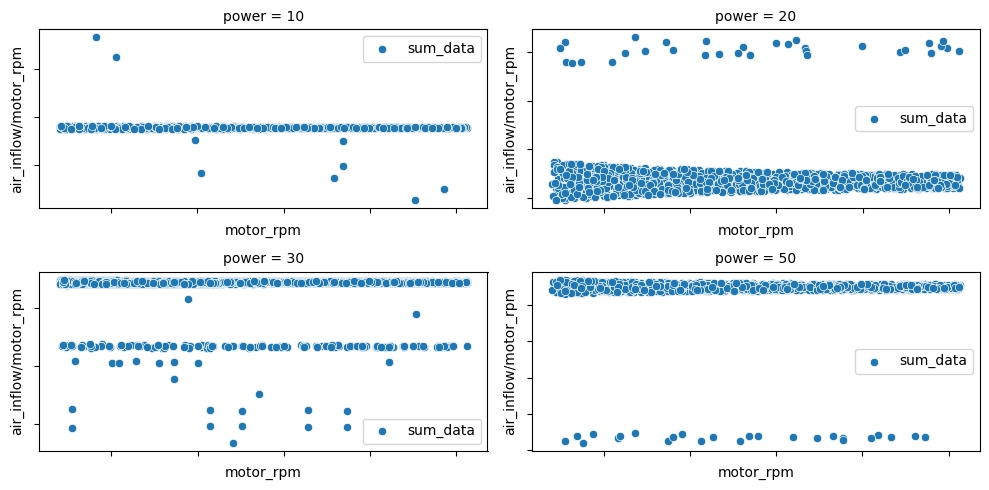

In [149]:
sub_plot_power_all(sum_data_power_10, sum_data_power_20, sum_data_power_30, sum_data_power_50, 'motor_rpm', 'air_inflow/motor_rpm')

In [150]:
from sklearn.cluster import DBSCAN
def train_dbscan(sum_data, x1, x2, eps=0.2, min_samples=7, metric='euclidean'):
    X = sum_data[x1]
    y = sum_data[x2]
    z_= np.empty((len(X),2))
    z_[:,0] = X
    z_[:,1] = y
    scaler_ = MinMaxScaler(feature_range = (-1, 1))
    X_scaled_ = scaler_.fit_transform(z_[:,0].reshape(-1,1))
    y_scaled_ = scaler_.fit_transform(z_[:,1].reshape(-1,1))
    z_scaled_ = np.empty((len(X_scaled_),2))
    z_scaled_[:,0] = X_scaled_.reshape(1,-1)
    z_scaled_[:,1] = y_scaled_.reshape(1,-1)
    #   print(pd.DataFrame(z_scaled_).info())
    dbscan_ = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    dbscan_.fit(z_scaled_)
    labels_ = dbscan_.labels_
    # labels_[labels_ != 0] = -1
    return dbscan_, z_scaled_, labels_

In [151]:
def plot_dbscan3(dbscan, X, size, show_xlabels=True, show_ylabels=True):
#     core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
#     core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = X['label'] != 0
    real_mask = X['label'] == 0
#     non_core_mask = ~(core_mask | anomalies_mask)

#     cores = dbscan.components_
    anomalies = X[anomalies_mask]
    real = X[real_mask]
#     non_cores = X[non_core_mask]
    
#     plt.scatter(cores[:, 0], cores[:, 1],
#                 c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(real['x1'], real['x2'], marker='*', s=20, c='purple')
    plt.scatter(anomalies['x1'], anomalies['x2'],
                c="r", marker="x", s=100)
#     plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [152]:
def plot_dbscan2(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ != 0
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [153]:
def plot_dbscan(dbscan, X, labels, size, show_xlabels=True, show_ylabels=True):
    # core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    # core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = labels == -1
    real_mask = labels == 0
    # non_core_mask = ~(core_mask | anomalies_mask)

    # cores = dbscan.components_
    anomalies = X[anomalies_mask]
    real = X[real_mask]
    # non_cores = X[non_core_mask]
    
    # plt.scatter(cores[:, 0], cores[:, 1],
    #             c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(real[:, 0], real[:, 1], marker='*', s=20, c='purple')
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    # plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [154]:
z_scaled

array([[-0.93985599,  0.95477794,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.88564168,  0.95327644,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20711563,  0.96734914,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.08343922,  0.97880991,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.44260906,  0.98188626,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10122829,  0.96155581,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [155]:
dbscan, z_scaled, labels1 = train_dbscan(sum_data_power_10, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.1)
dbscan2, z_scaled2, labels2 = train_dbscan(sum_data_power_20, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.3)
dbscan3, z_scaled3, labels3 = train_dbscan(sum_data_power_30, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.1)
dbscan4, z_scaled4, labels4 = train_dbscan(sum_data_power_50, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.3)

In [156]:
dbscan2, z_scaled2, labels2 = train_dbscan(sum_data_power_20, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.3)

In [157]:
dbscan3, z_scaled3, labels3 = train_dbscan(sum_data_power_30, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.1)

In [158]:
from sklearn.cluster import DBSCAN
dbscan4, z_scaled4, labels4 = train_dbscan(sum_data_power_50, 'motor_rpm', 'air_inflow/motor_rpm', eps=0.3, min_samples=2)

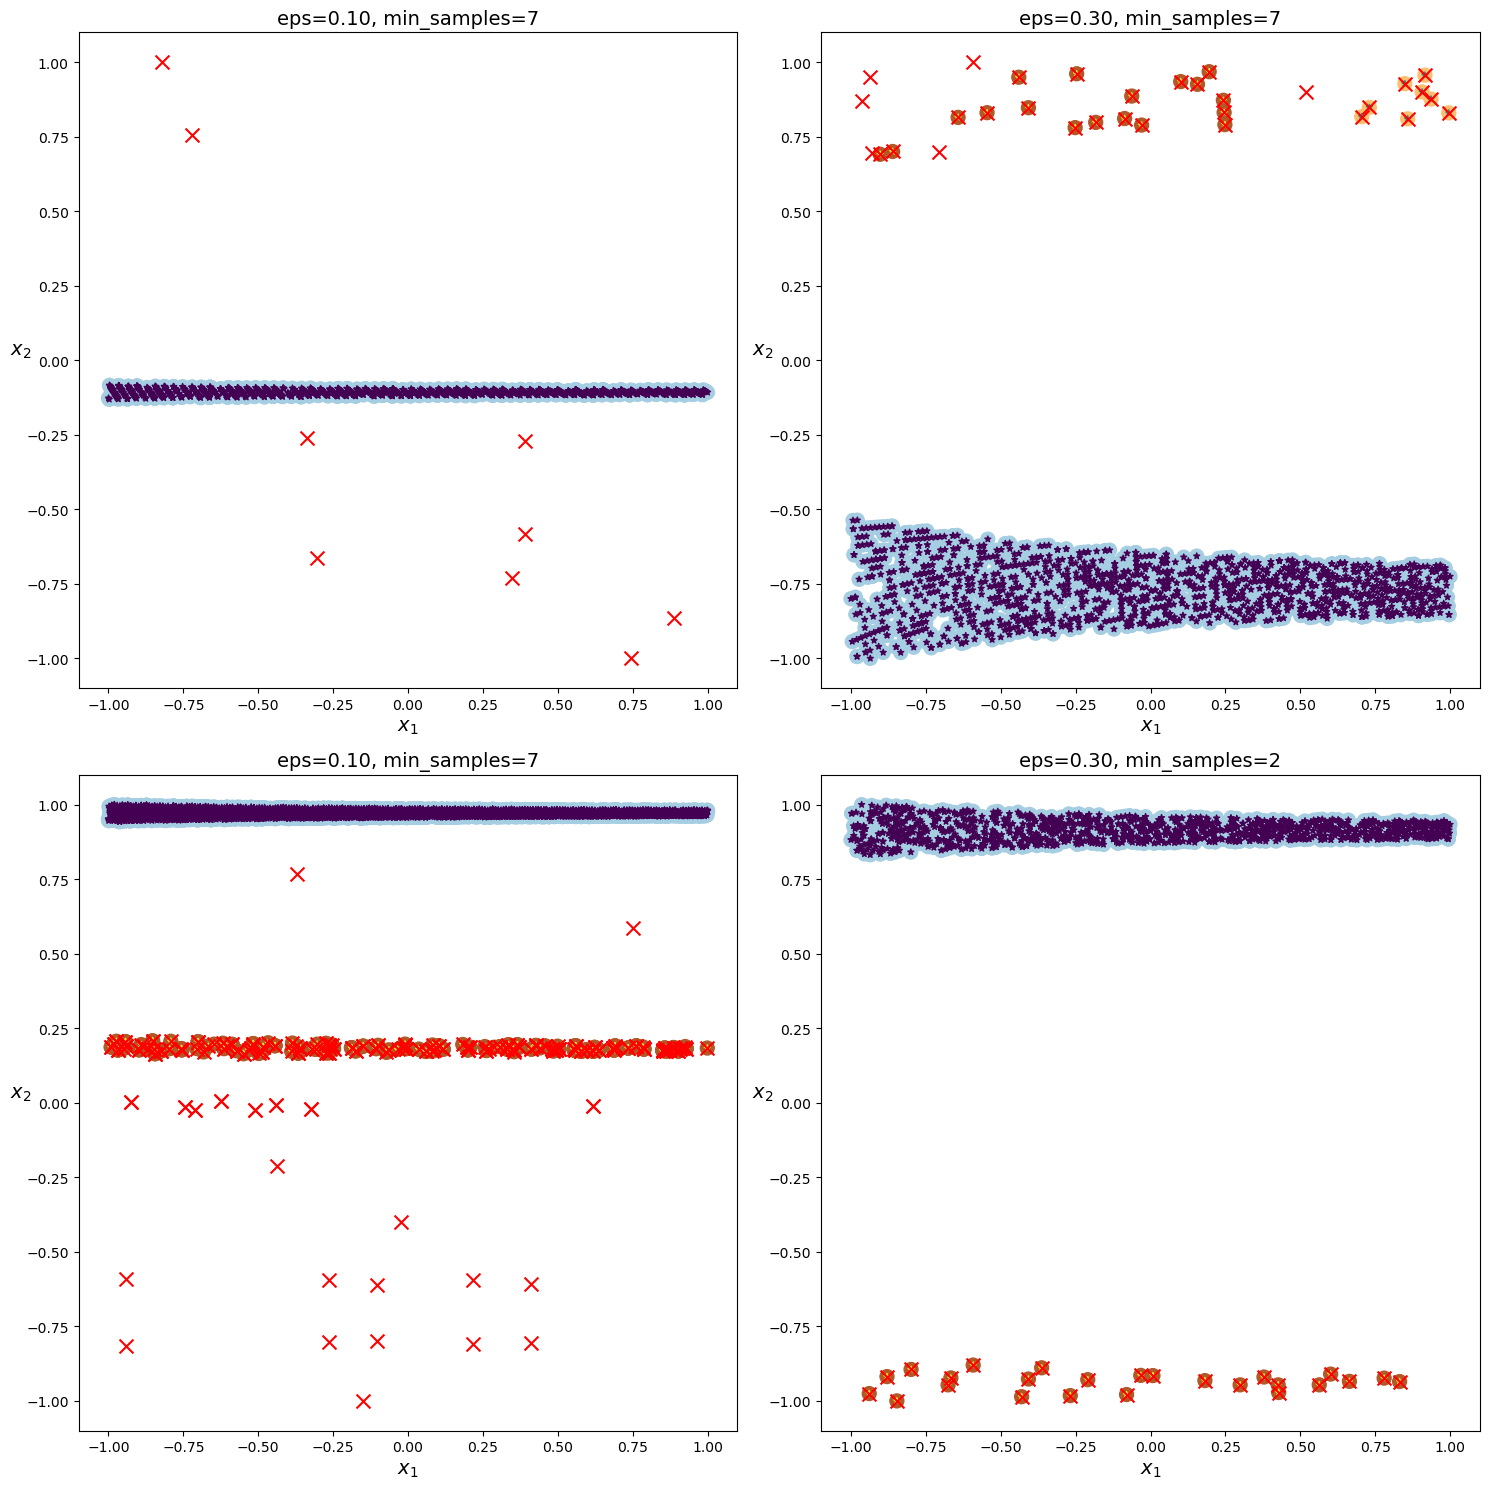

In [159]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plot_dbscan2(dbscan, z_scaled, size=100)

plt.subplot(2,2,2)
plot_dbscan2(dbscan2, z_scaled2, size=100)

plt.subplot(2,2,3)
plot_dbscan2(dbscan3,z_scaled3, size=100)

plt.subplot(2,2,4)
plot_dbscan2(dbscan4, z_scaled4, size=100)

plt.tight_layout()

In [295]:
real_data_power_10 = pd.concat([pd.DataFrame(z_scaled, columns=['x1', 'x2']),pd.DataFrame(dbscan.labels_, columns=['label']),
                                sum_data_power_10['index'],sum_data_power_10['data_type']], axis=1).reset_index(drop=True)
real_data_power_10['label'].unique()

array([ 0, -1], dtype=int64)

In [296]:
real_data_power_10

x1        x2  label  index data_type
0    -0.113088 -0.120360      0    785     train
1    -0.270648 -0.116733      0    786     train
2    -0.634900 -0.121015      0    787     train
3    -0.901737 -0.090749      0    788     train
4    -0.462939 -0.108049      0    789     train
...        ...       ...    ...    ...       ...
1459 -0.197798 -0.099713      0   3496      test
1460  0.900042 -0.102849      0   3497      test
1461  0.495129 -0.116283      0   3498      test
1462 -0.031766 -0.111522      0   3499      test
1463 -0.943244 -0.119600      0   3500      test

[1464 rows x 5 columns]

In [297]:
real_data_power_20 = pd.concat([pd.DataFrame(z_scaled2, columns=['x1', 'x2']),pd.DataFrame(dbscan2.labels_, columns=['label']),
                               sum_data_power_20['index'],sum_data_power_20['data_type']], axis=1).reset_index(drop=True)
real_data_power_20['label'].unique()

array([0, 2, 1], dtype=int64)

In [298]:
real_data_power_20

x1        x2  label  index data_type
0     0.501695 -0.855966      0    432     train
1    -0.116102 -0.744389      0    433     train
2    -0.079661 -0.877144      0    434     train
3     0.694068 -0.708924      0    435     train
4     0.421186 -0.746785      0    436     train
...        ...       ...    ...    ...       ...
1455 -0.555932 -0.641552      0   2398      test
1456 -0.496610 -0.674221      0   2399      test
1457  0.412712 -0.833147      0   2400      test
1458 -0.798305 -0.746785      0   2401      test
1459  0.329661 -0.681401      0   2402      test

[1460 rows x 5 columns]

In [299]:
real_data_power_30 = pd.concat([pd.DataFrame(z_scaled3, columns=['x1', 'x2']),pd.DataFrame(dbscan3.labels_, columns=['label']),
                               sum_data_power_30['index'],sum_data_power_30['data_type']], axis=1).reset_index(drop=True)
real_data_power_30['label'].unique()

array([ 0,  1, -1], dtype=int64)

In [300]:
real_data_power_50 = pd.concat([pd.DataFrame(z_scaled4, columns=['x1', 'x2']),pd.DataFrame(dbscan4.labels_, columns=['label']),
                                sum_data_power_50['index'],sum_data_power_50['data_type']], axis=1).reset_index(drop=True)
real_data_power_50['label'].unique()

array([0, 1], dtype=int64)

In [301]:
real_data_power_10[real_data_power_10['label'] != 0]['label'] = -1
real_data_power_20[real_data_power_20['label'] != 0]['label'] = -1
real_data_power_30[real_data_power_30['label'] != 0]['label'] = -1
real_data_power_50[real_data_power_50['label'] != 0]['label'] = -1
real_data_power_50['label'].unique()

array([0, 1], dtype=int64)

In [302]:
real_data_power_10['label'] = real_data_power_10['label'].apply(lambda x: -1 if x != 0 else x)
real_data_power_20['label'] = real_data_power_20['label'].apply(lambda x: -1 if x != 0 else x)
real_data_power_30['label'] = real_data_power_30['label'].apply(lambda x: -1 if x != 0 else x)
real_data_power_50['label'] = real_data_power_50['label'].apply(lambda x: -1 if x != 0 else x)

In [303]:
train_data_power_10

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0      785        0.62         45.11           0.7          10.00     2249.0   
1      786        0.57         42.79           0.7           9.17     2063.0   
2      787        0.45         37.41           0.7           7.26     1633.0   
3      788        0.37         33.48           0.7           5.86     1318.0   
4      789        0.51         39.95           0.7           8.16     1836.0   
..     ...         ...           ...           ...            ...        ...   
361   1146        0.68         47.55           0.7          10.86     2444.0   
362   1147        0.57         42.56           0.7           9.09     2045.0   
363   1148        0.80         53.11           0.7          12.84     2889.0   
364   1149        0.89         57.11           0.7          14.26     3209.0   
365   1150        0.39         34.65           0.7           6.28     1412.0   

     motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0         61.99        2.55     2     train               224.900000   
1         59.92        2.45     2     train               224.972737   
2         55.14        2.21     2     train               224.931129   
3         51.64        2.03     2     train               224.914676   
4         57.40        2.32     2     train               225.000000   
..          ...         ...   ...       ...                      ...   
361       64.16        2.66     2     train               225.046041   
362       59.72        2.44     2     train               224.972497   
363       69.10        2.91     2     train               225.000000   
364       72.66        3.08     2     train               225.035063   
365       52.69        2.08     2     train               224.840764   

     air_inflow/motor_current  motor_current/horse_power  \
0                    0.062000                      1.000   
1                    0.062159                      0.917   
2                    0.061983                      0.726   
3                    0.063140                      0.586   
4                    0.062500                      0.816   
..                        ...                        ...   
361                  0.062615                      1.086   
362                  0.062706                      0.909   
363                  0.062305                      1.284   
364                  0.062412                      1.426   
365                  0.062102                      0.628   

     motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                               2249.000                   0.062   
1                               1891.771                   0.057   
2                               1185.558                   0.045   
3                                772.348                   0.037   
4                               1498.176                   0.051   
..                                   ...                     ...   
361                             2654.184                   0.068   
362                             1858.905                   0.057   
363                             3709.476                   0.080   
364                             4576.034                   0.089   
365                              886.736                   0.039   

     motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                    224.9                     0.62              0.000276   
1                    206.3                     0.57              0.000276   
2                    163.3                     0.45              0.000276   
3                    131.8                     0.37              0.000281   
4                    183.6                     0.51              0.000278   
..                     ...                      ...                   ...   
361                  244.4                     0.68              0.000278   
362                  204.

In [304]:
real_data_power_30['label'].unique()

array([ 0, -1], dtype=int64)

dbscan으로 이상치 분류하고 그다음 비선형 SVM으로 예측함

In [305]:
def sub_plot_corr(data,data2,  name1, name2):
  plt.figure(figsize=(10,5))
  correlation = data[name1].corr(data[name2])
  j = 0
  color = ['green', 'yellow', 'red']
  for i in range(8):
    globals()['data{}'.format(i)] = data[data['type'] == i]
    plt.subplot(1,2,1)
    if i == 1 or i == 2 or i == 3:
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue')
  g.set_title("train_data", size=10)
  g.set_xticklabels(g.get_xticklabels())
  g.set_yticklabels(g.get_yticklabels())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  j = 0
  for i in range(8):
    globals()['data{}'.format(i)] = data2[data2['type'] == i]
    plt.subplot(1,2,2)
    if i == 1 or i == 2 or i == 3:
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color=color[j])
      j += 1
    else :
      g2 = sns.scatterplot(data=globals()['data{}'.format(i)], x=name1, y=name2, color='blue') 
  g2.set_title("test_data", size=10)
  g2.set_xticklabels(g.get_xticklabels())
  g2.set_yticklabels(g.get_yticklabels())
  g2.set_ylim(g.get_ylim())
  plt.legend(labels=['type = 0, 4, 5, 6, 7','type = 1', 'type = 2','type = 3'])
  plt.tight_layout()
  plt.show()

In [306]:
def sub_plot_corr2(train_data, test_data, name1, name2):
    g = sns.scatterplot(data=train_data, x=name1, y=name2, markers='*' )
    g = sns.scatterplot(data=test_data, x=name1, y=name2, s=20)
    g.set_title("train_data & test_data", size=10)
    g.set_xticklabels(g.get_xticklabels())
    g.set_yticklabels(g.get_yticklabels())
    plt.legend(labels=['train','test'])
    plt.show()

In [307]:
train_data_power_30 = pd.concat([train_data_0, train_data_4, train_data_5, train_data_6, train_data_7]).reset_index()
train_data_power_20 = train_data_1
train_data_power_10 = train_data_2
train_data_power_50 = train_data_3
test_data_power_30 = pd.concat([test_data_0, test_data_4, test_data_5, test_data_6, test_data_7]).reset_index()
test_data_power_20 = test_data_1
test_data_power_10 = test_data_2
test_data_power_50 = test_data_3
test_data_power_50

index  air_inflow  air_end_temp  out_pressure  motor_current  motor_rpm  \
0     3501        2.40         37.68           0.7           28.0     1374.0   
1     3502        2.84         40.81           0.7           33.0     1625.0   
2     3503        5.66         60.95           0.7           66.0     3236.0   
3     3504        2.92         41.34           0.7           34.0     1667.0   
4     3505        5.32         58.49           0.7           62.0     3039.0   
..     ...         ...           ...           ...            ...        ...   
913   4414        4.99         56.15           0.7           58.0     2852.0   
914   4415        3.16         43.06           0.7           37.0     1805.0   
915   4416        4.56         53.04           0.7           53.0     2603.0   
916   4417        6.23         65.00           0.7           72.0     3560.0   
917   4418        2.39         37.58           0.7           28.0     1366.0   

     motor_temp  motor_vibe  type data_type  motor_rpm/motor_current  \
0         56.27        3.96     3      test                49.071429   
1         59.06        4.10     3      test                49.242424   
2         76.96        5.00     3      test                49.030303   
3         59.52        4.13     3      test                49.029412   
4         74.77        4.89     3      test                49.016129   
..          ...         ...   ...       ...                      ...   
913       72.69        4.78     3      test                49.172414   
914       61.06        4.20     3      test                48.783784   
915       69.92        4.65     3      test                49.113208   
916       80.56        5.18     3      test                49.444444   
917       56.18        3.96     3      test                48.785714   

     air_inflow/motor_current  motor_current/horse_power  \
0                    0.085714                       0.56   
1                    0.086061                       0.66   
2                    0.085758                       1.32   
3                    0.085882                       0.68   
4                    0.085806                       1.24   
..                        ...                        ...   
913                  0.086034                       1.16   
914                  0.085405                       0.74   
915                  0.086038                       1.06   
916                  0.086528                       1.44   
917                  0.085357                       0.56   

     motor_current*motor_rpm/horse_power  air_inflow/horse_power  \
0                                 769.44                  0.0480   
1                                1072.50                  0.0568   
2                                4271.52                  0.1132   
3                                1133.56                  0.0584   
4                                3768.36                  0.1064   
..                                   ...                     ...   
913                              3308.32                  0.0998   
914                              1335.70                  0.0632   
915                              2759.18                  0.0912   
916                              5126.40                  0.1246   
917                               764.96                  0.0478   

     motor_rpm/horse_power  air_inflow/horse_power2  air_inflow/motor_rpm  \
0                    27.48                   0.0960              0.001747   
1                    32.50                   0.1136              0.001748   
2                    64.72                   0.2264              0.001749   
3                    33.34                   0.1168              0.001752   
4                    60.78                   0.2128              0.001751   
..                     ...                      ...                   ...   
913                  57.04                   0.1996              0.001750   
914                  36.1

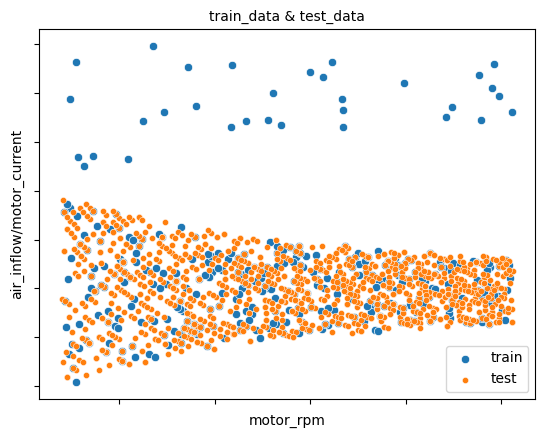

In [308]:
sub_plot_corr2(train_data_power_20, test_data_power_20, 'motor_rpm', 'air_inflow/motor_current')

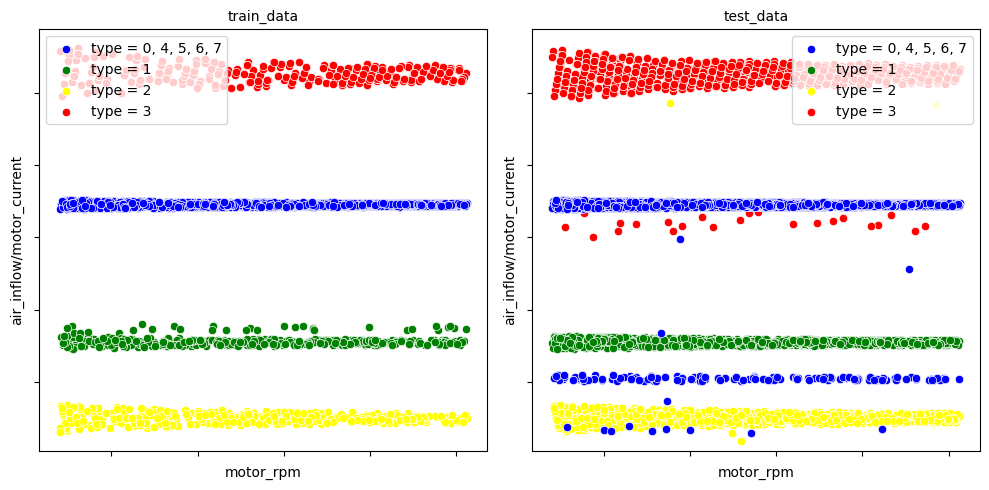

In [309]:
sub_plot_corr(train_data, test_data, 'motor_rpm', 'air_inflow/motor_current')

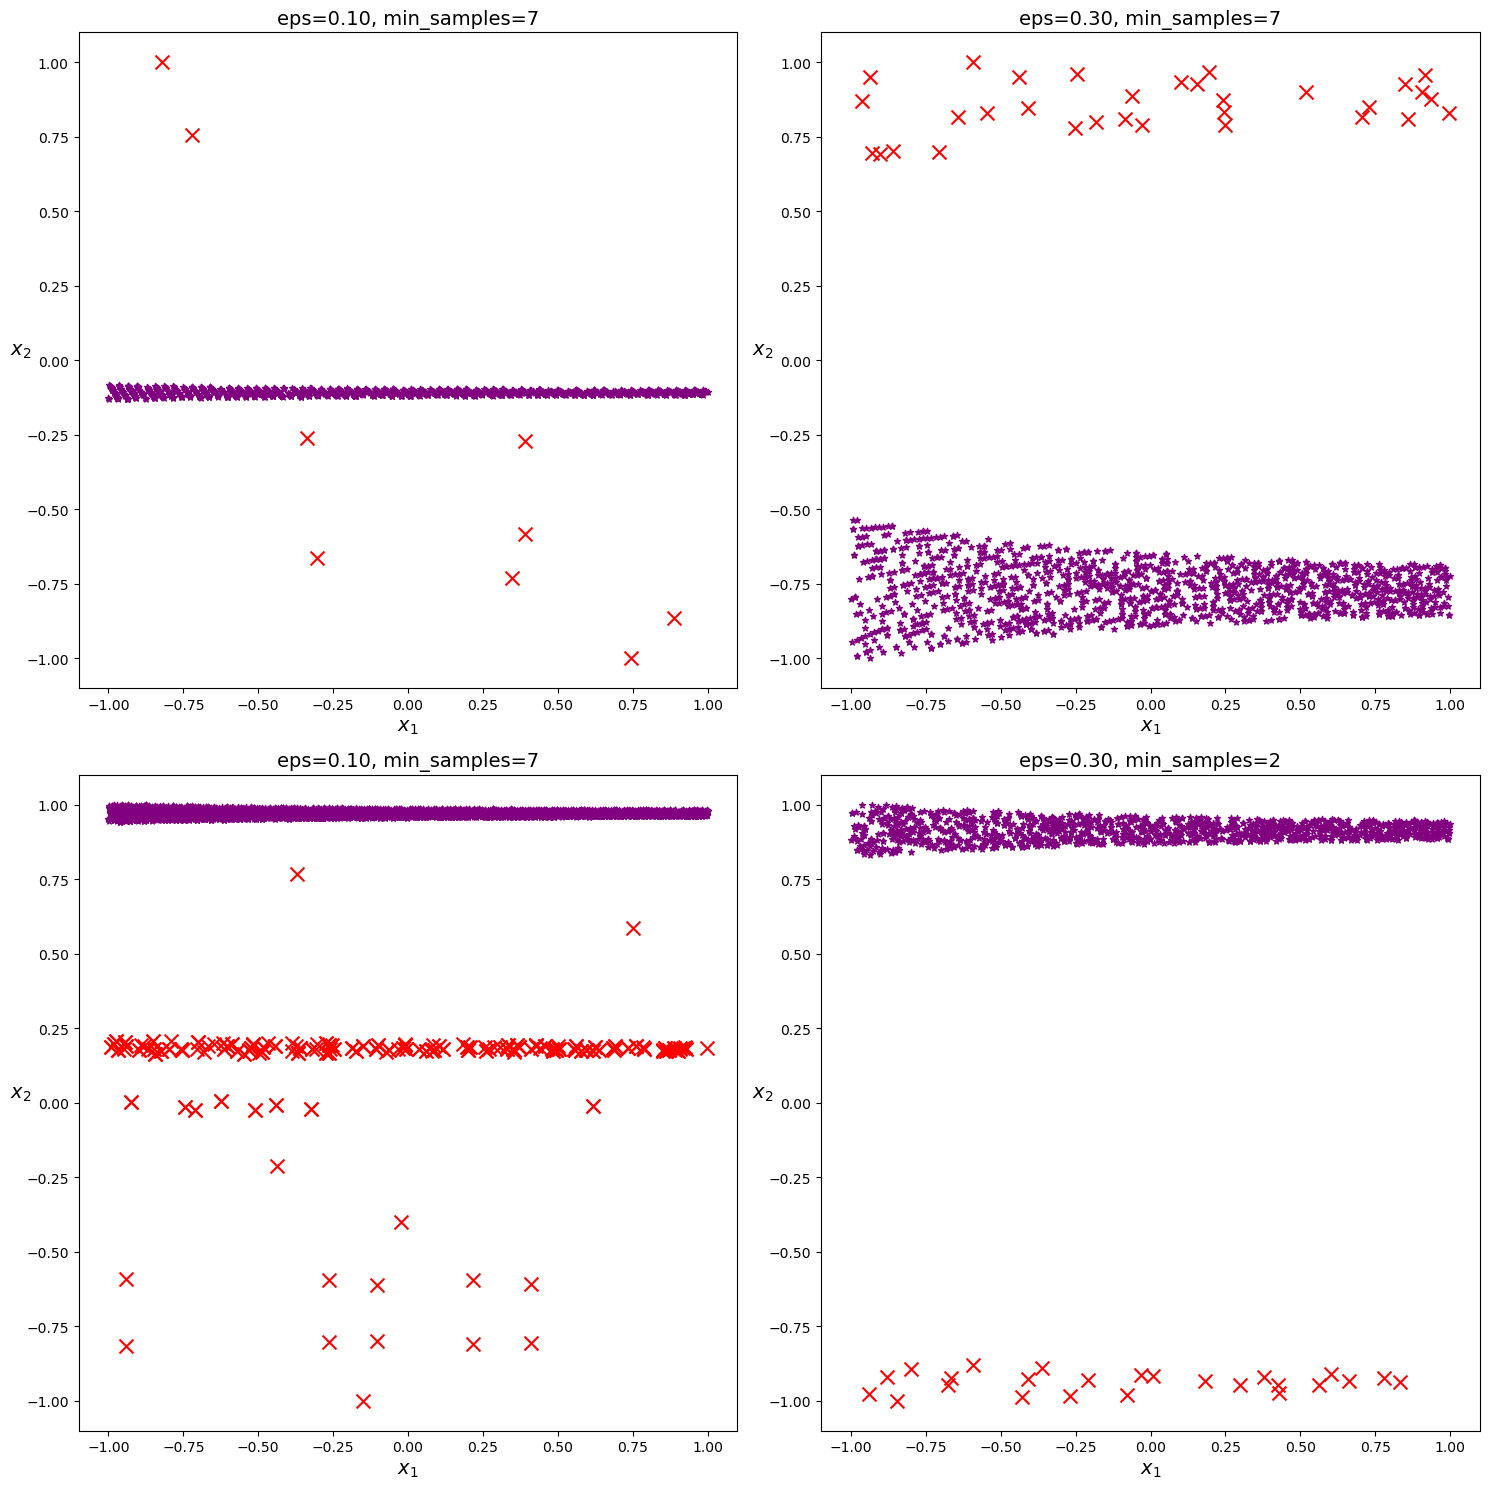

In [310]:
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plot_dbscan3(dbscan, real_data_power_10, size=100)

plt.subplot(2,2,2)
plot_dbscan3(dbscan2, real_data_power_20, size=100)

plt.subplot(2,2,3)
plot_dbscan3(dbscan3,real_data_power_30, size=100)

plt.subplot(2,2,4)
plot_dbscan3(dbscan4, real_data_power_50, size=100)

plt.tight_layout()

In [229]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1461, 1462, 1463], dtype=int64)

In [227]:
labels1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [230]:
import numpy as np
import scipy as sp

def dbscan_predict(dbscan_model, X_new, metric=sp.spatial.distance.euclidean):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.components_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

In [231]:
dbscan_predict(dbscan, np.array([[-0.5, -0.6],[0,0]]))

array([-1,  0])

In [268]:
real_data_power_10[real_data_power_10['x2'] > 0.5]['label']

610   -1
611   -1
Name: label, dtype: int64

In [280]:
len(sum_data_power_10)

1464

In [279]:
len(train_data_power_10), len(test_data_power_10)

(366, 1098)

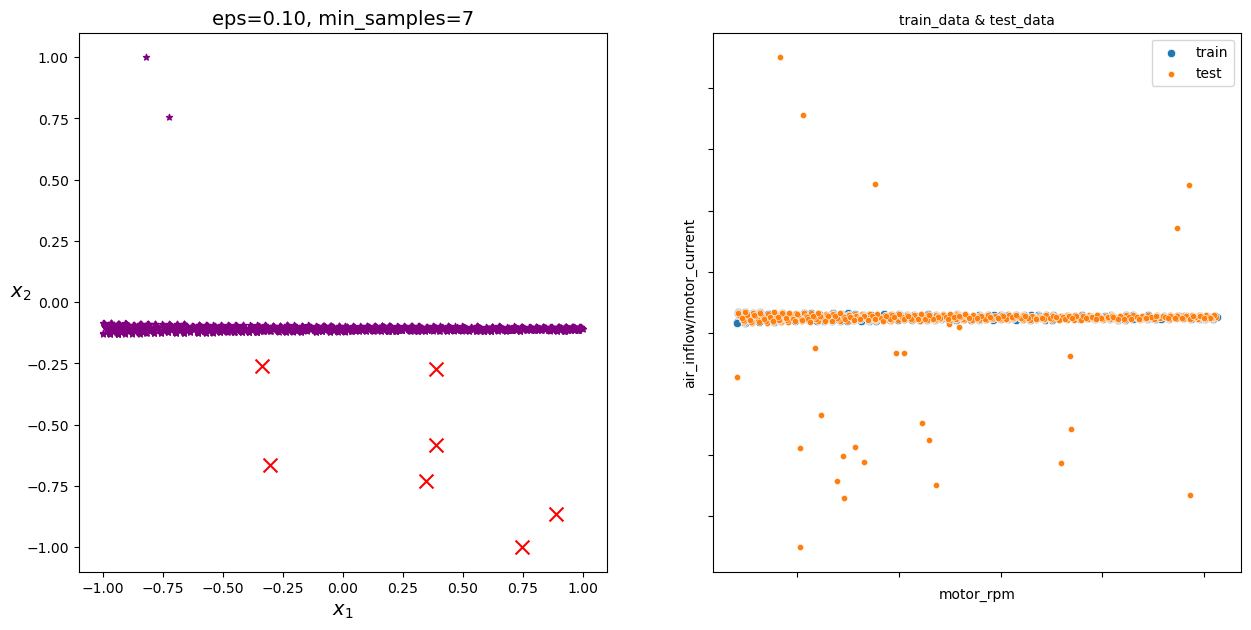

<Figure size 640x480 with 0 Axes>

In [275]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plot_dbscan3(dbscan, real_data_power_10, size=100)

plt.subplot(1,2,2)
sub_plot_corr2(train_data_power_10, test_data_power_10, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

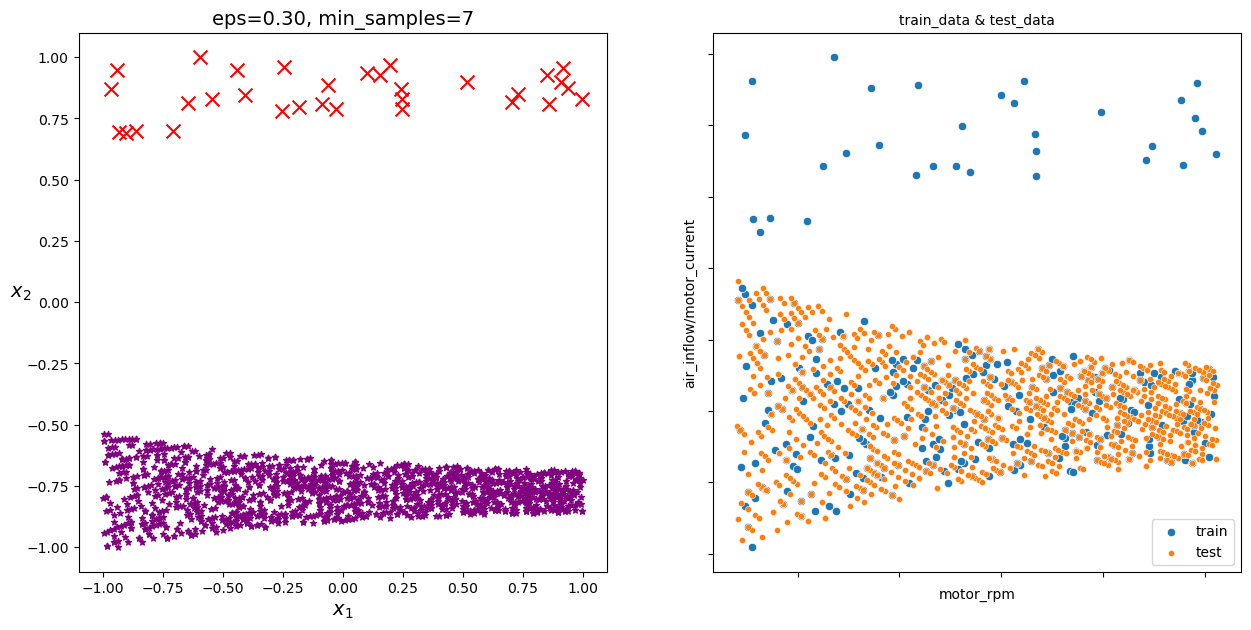

<Figure size 640x480 with 0 Axes>

In [281]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_dbscan3(dbscan2,real_data_power_20, size=100)

plt.subplot(1,2,2)
sub_plot_corr2(train_data_power_20, test_data_power_20, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

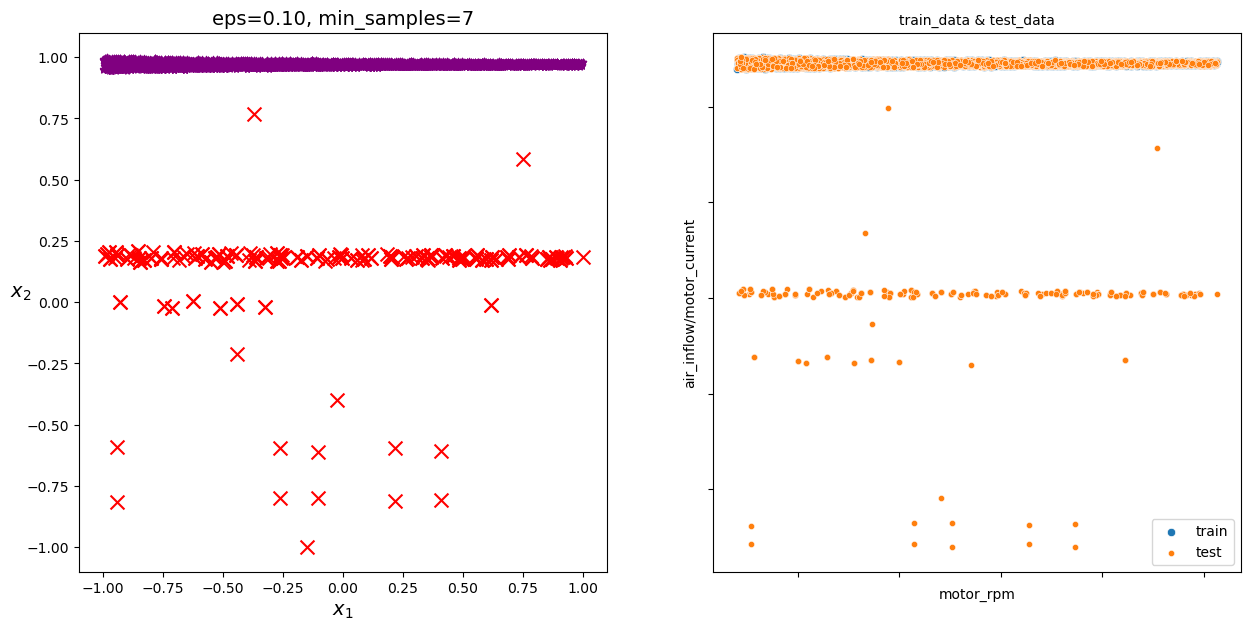

<Figure size 640x480 with 0 Axes>

In [282]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_dbscan3(dbscan3,real_data_power_30, size=100)

plt.subplot(1,2,2)
sub_plot_corr2(train_data_power_30, test_data_power_30, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

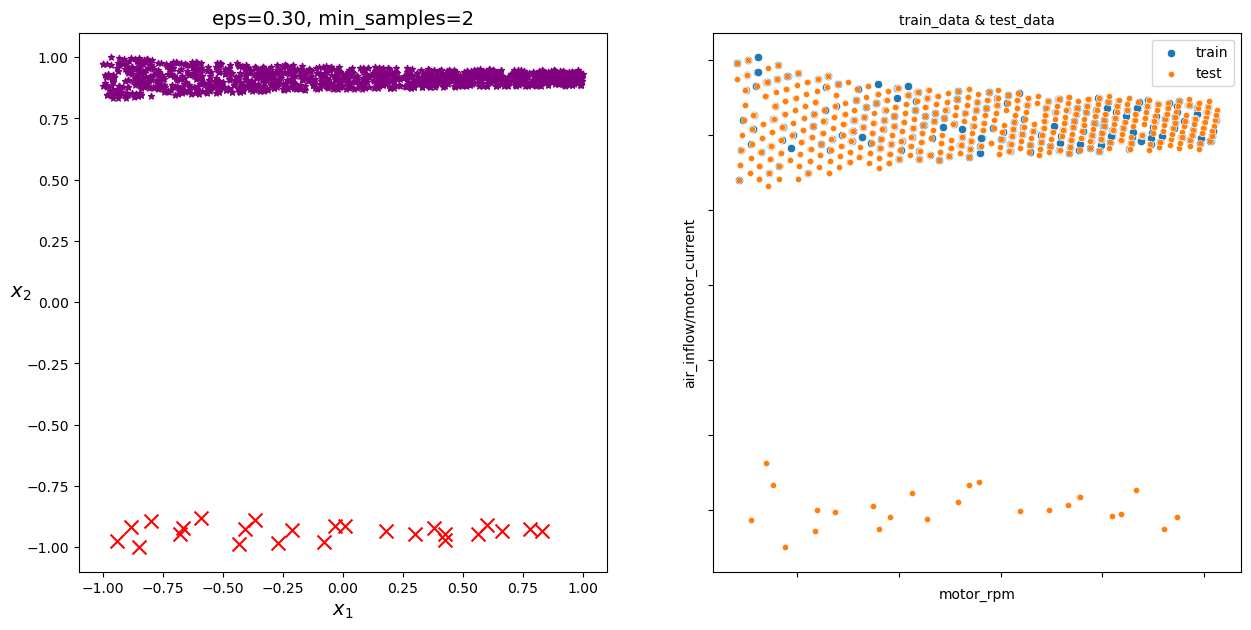

<Figure size 640x480 with 0 Axes>

In [285]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plot_dbscan3(dbscan4,real_data_power_50, size=100)

plt.subplot(1,2,2)
sub_plot_corr2(train_data_power_50, test_data_power_50, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

In [311]:
real_data_power_10[real_data_power_10['x2'] > 0.5]['label']

610   -1
611   -1
Name: label, dtype: int64

In [312]:
real_data_power_10['label'][610:612] = 0

In [313]:
real_data_power_20[real_data_power_20['x2'] > 0]['label']

117   -1
118   -1
119   -1
120   -1
121   -1
122   -1
123   -1
124   -1
125   -1
126   -1
127   -1
128   -1
129   -1
130   -1
131   -1
132   -1
133   -1
134   -1
135   -1
136   -1
137   -1
138   -1
139   -1
140   -1
141   -1
142   -1
143   -1
144   -1
145   -1
146   -1
147   -1
148   -1
Name: label, dtype: int64

In [315]:
real_data_power_20['label'][real_data_power_20[real_data_power_20['x2'] > 0]['label'].index] = 0
real_data_power_20[real_data_power_20['x2'] > 0]['label']

117    0
118    0
119    0
120    0
121    0
122    0
123    0
124    0
125    0
126    0
127    0
128    0
129    0
130    0
131    0
132    0
133    0
134    0
135    0
136    0
137    0
138    0
139    0
140    0
141    0
142    0
143    0
144    0
145    0
146    0
147    0
148    0
Name: label, dtype: int64

In [317]:
real_data_power_50[real_data_power_50['x2'] < 0]['label']

745   -1
746   -1
747   -1
748   -1
749   -1
750   -1
751   -1
752   -1
753   -1
754   -1
755   -1
756   -1
757   -1
758   -1
759   -1
760   -1
761   -1
762   -1
763   -1
764   -1
765   -1
766   -1
767   -1
768   -1
769   -1
Name: label, dtype: int64

In [318]:
real_data_power_50['label'][real_data_power_50[real_data_power_50['x2'] < 0]['label'].index] = 0
real_data_power_50[real_data_power_50['x2'] < 0]['label']

745    0
746    0
747    0
748    0
749    0
750    0
751    0
752    0
753    0
754    0
755    0
756    0
757    0
758    0
759    0
760    0
761    0
762    0
763    0
764    0
765    0
766    0
767    0
768    0
769    0
Name: label, dtype: int64

In [335]:
real_data_power_10['label'].unique()

array([ 0, -1], dtype=int64)

In [321]:
real_data_power_10[real_data_power_10['data_type'] == 'test']

x1        x2  label  index data_type
366   0.440915 -0.100756      0   2403      test
367   0.278272 -0.114658      0   2404      test
368   0.961033 -0.102955      0   2405      test
369  -0.979670 -0.110706      0   2406      test
370   0.433291 -0.115928      0   2407      test
...        ...       ...    ...    ...       ...
1459 -0.197798 -0.099713      0   3496      test
1460  0.900042 -0.102849      0   3497      test
1461  0.495129 -0.116283      0   3498      test
1462 -0.031766 -0.111522      0   3499      test
1463 -0.943244 -0.119600      0   3500      test

[1098 rows x 5 columns]

In [352]:
final_data = pd.concat([real_data_power_10[real_data_power_10['data_type'] == 'test'], real_data_power_20[real_data_power_20['data_type'] == 'test'],
           real_data_power_30[real_data_power_30['data_type'] == 'test'], real_data_power_50[real_data_power_50['data_type'] == 'test']])

In [353]:
final_data['label'].unique()

array([ 0, -1], dtype=int64)

In [354]:
final_data.sort_values(by='index', inplace=True)
final_data.reset_index(drop=True, inplace=True)
final_data

x1        x2  label  index data_type
0     0.236887  0.960306      0      0      test
1     0.369712  0.965258      0      1      test
2    -0.476311  0.979306      0      2      test
3    -0.042301  0.963831      0      3      test
4    -0.169205  0.968746      0      4      test
...        ...       ...    ...    ...       ...
7384 -0.115059  0.967412      0   7384      test
7385 -0.686971  0.958708      0   7385      test
7386 -0.620135  0.982527      0   7386      test
7387 -0.594755  0.989379      0   7387      test
7388 -0.491540  0.967552      0   7388      test

[7389 rows x 5 columns]

In [355]:
final_data[final_data['label'] == -1].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6795, 6796, 6797, 6798, 6799, 6800, 7342, 7348, 7359, 7360],
           dtype='int64', length=291)

In [356]:
final_data['label'] = final_data['label'].apply(lambda x: 1 if x == -1 else x)
final_data[final_data['label'] == 1].index

Int64Index([ 585,  586,  587,  588,  589,  590,  591,  592,  593,  594,
            ...
            6795, 6796, 6797, 6798, 6799, 6800, 7342, 7348, 7359, 7360],
           dtype='int64', length=291)

In [357]:
final_data['label']

0       0
1       0
2       0
3       0
4       0
       ..
7384    0
7385    0
7386    0
7387    0
7388    0
Name: label, Length: 7389, dtype: int64

In [358]:
submission['label'] = final_data['label']

In [359]:
submission.to_csv('submission2.csv', index=False)

In [ ]:
plt.figure(figsize=(15, 7))

plt.subplot(2,2,3)
plot_dbscan3(dbscan3,real_data_power_30, size=100)

plt.subplot(2,2,4)
sub_plot_corr2(train_data_power_30, test_data_power_30, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

In [259]:
real_data_power_30[]

array([ 0, -1], dtype=int64)

In [235]:
real_data_power_50

x1        x2  label  index data_type
0     0.272112  0.898153      0   1151     train
1     0.713923  0.945817      0   1152     train
2    -0.832416  0.942601      0   1153     train
3     0.815489  0.944700      0   1154     train
4     0.126534  0.905850      0   1155     train
...        ...       ...    ...    ...       ...
1219  0.397376  0.906840      0   4414      test
1220 -0.488785  0.930133      0   4415      test
1221  0.186627  0.955417      0   4416      test
1222  0.996614  0.914669      0   4417      test
1223 -0.860347  0.906496      0   4418      test

[1224 rows x 5 columns]

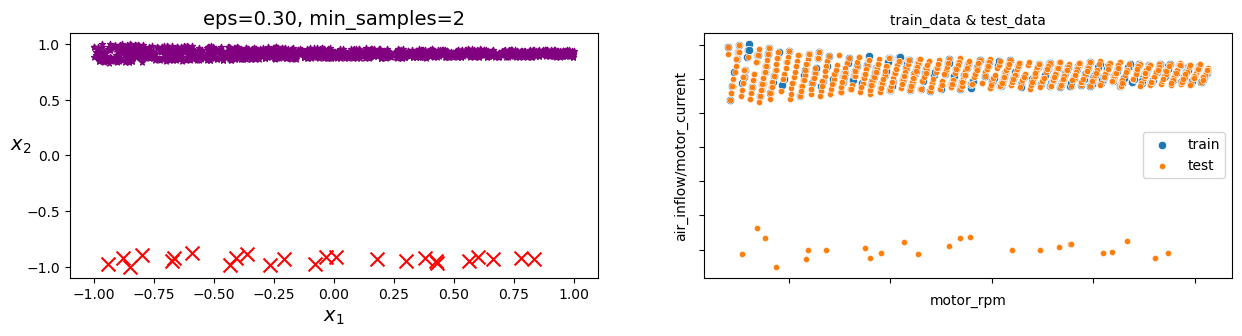

<Figure size 640x480 with 0 Axes>

In [236]:
plt.figure(figsize=(15, 7))

plt.subplot(2,2,3)
plot_dbscan3(dbscan4,real_data_power_50, size=100)

plt.subplot(2,2,4)
sub_plot_corr2(train_data_power_50, test_data_power_50, 'motor_rpm', 'air_inflow/motor_current')

plt.tight_layout()

In [237]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15)
y.shape

(100,)

In [238]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

In [239]:
np.array(real_data_power_10['x1'])

array([-0.11308767, -0.27064803, -0.63490047, ...,  0.49512918,
       -0.0317662 , -0.94324439])

In [240]:
tmp = np.empty((len(real_data_power_10),2))
tmp[:,0] = np.array(real_data_power_10['x1'])
tmp[:,1] = np.array(real_data_power_10['x2'])
tmp2 = np.array(real_data_power_10['label'])
tmp.shape

(1464, 2)

In [241]:
svc_rbf = SVC(kernel='rbf', gamma=5, C=0.001)
svc_rbf.fit(tmp, tmp2)

SVC(C=0.001, gamma=5)

In [242]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [243]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [244]:

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
X.shape

(100, 2)

In [245]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    print(x0.shape, x1.shape, X.shape)
    y_pred = clf.predict(X).reshape(x0.shape)
    print(clf.predict(X).shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [246]:
def plot_predictions(clf, dbscan, X, t1, t2, gamma, C, size= 100, show_xlabels=True, show_ylabels=True):
    anomalies_mask = X['label'] == -1
    real_mask = X['label'] == 0
    anomalies = X[anomalies_mask]
    real = X[real_mask]
    plt.scatter(real['x1'], real['x2'], marker='*', s=20, c='purple')
    plt.scatter(anomalies['x1'], anomalies['x2'],
                c="r", marker="x", s=100)
    axe = plt.gca()
    ax1, ax2 = axe.get_xlim()
    ax3, ax4 = axe.get_ylim()
    
    x0s = np.linspace(ax1, ax2, 100)
    x1s = np.linspace(ax3, ax4, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    print(x0.shape, x1.shape)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.3)
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(r"$\gamma = {}, C = {}, $".format(gamma, C) + "eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [247]:
np.array(real_data_power_10['x1'],real_data_power_10['x2']).shape

(1464,)

(100, 100) (100, 100)
(100, 100) (100, 100)
(100, 100) (100, 100)
(100, 100) (100, 100)


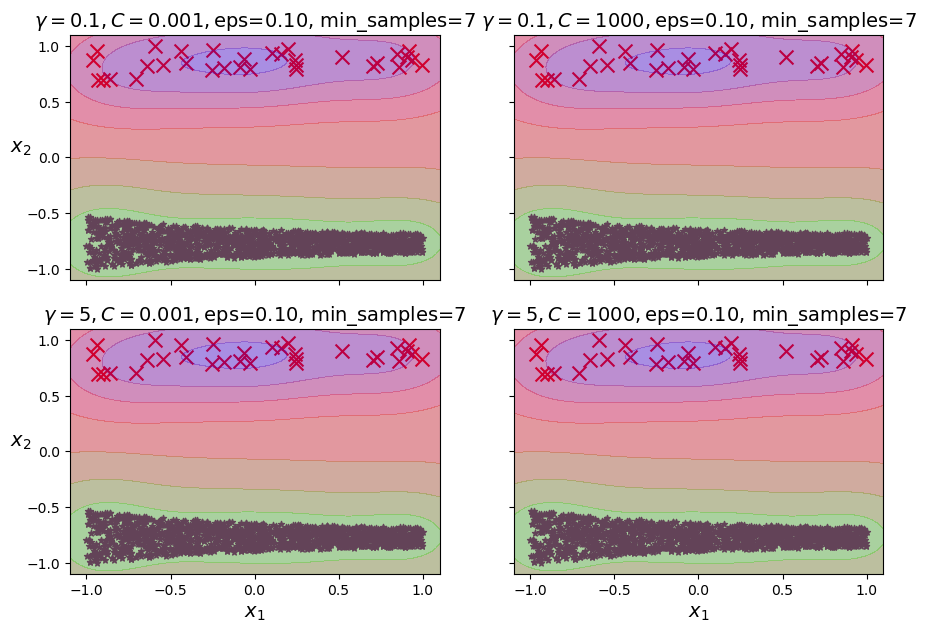

In [248]:
tmp = np.empty((len(real_data_power_20),2))
tmp[:,0] = np.array(real_data_power_20['x1'])
tmp[:,1] = np.array(real_data_power_20['x2'])
tmp2 = np.array(real_data_power_20['label'])
tmp.shape

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    svc_rbf = SVC(kernel='rbf', gamma=5, C=0.001)
    svc_rbf.fit(tmp, tmp2)
    svm_clfs.append(svc_rbf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    gamma, C = hyperparams[i]
    plot_predictions(svm_clf, dbscan, real_data_power_20, tmp, tmp2, gamma, C)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
plt.show()

In [ ]:
tmp[0,0]

In [249]:
tmp2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [250]:
tmp

array([[ 0.50169492, -0.85596621],
       [-0.11610169, -0.74438933],
       [-0.07966102, -0.87714441],
       ...,
       [ 0.41271186, -0.83314659],
       [-0.79830508, -0.74678482],
       [ 0.32966102, -0.68140131]])

In [251]:
np.array([[0, 0.5],[0, 0.8]]).reshape(-1, 2)

array([[0. , 0.5],
       [0. , 0.8]])

In [252]:
svc_rbf.predict(np.array([[0.5, -0.9],[0, 0.9]]).reshape(-1, 2))

array([0, 0], dtype=int64)

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [254]:
linear_svm = LinearSVC().fit(tmp, tmp2)

In [255]:
linear_svm.coef_, linear_svm.intercept_

(array([[-0.08324504, -1.45259583]]), array([0.07997666]))

In [256]:
def plot_predictions2(linear_svm, dbscan, X, size= 100, show_xlabels=True, show_ylabels=True):
    anomalies_mask = X['label'] == -1
    real_mask = X['label'] == 0
    anomalies = X[anomalies_mask]
    real = X[real_mask]
    plt.scatter(real['x1'], real['x2'], marker='*', s=20, c='purple')
    plt.scatter(anomalies['x1'], anomalies['x2'],
                c="r", marker="x", s=100)
    axe = plt.gca()
    ax1, ax2 = axe.get_xlim()
    ax3, ax4 = axe.get_ylim()
    line = np.linspace(ax1, ax2)
    i = 0
    color = ['blue', 'red']
    for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
        plt.plot(line, -(line * coef[0] + intercept) / coef[1], c=color[i])
        i += 1
        
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

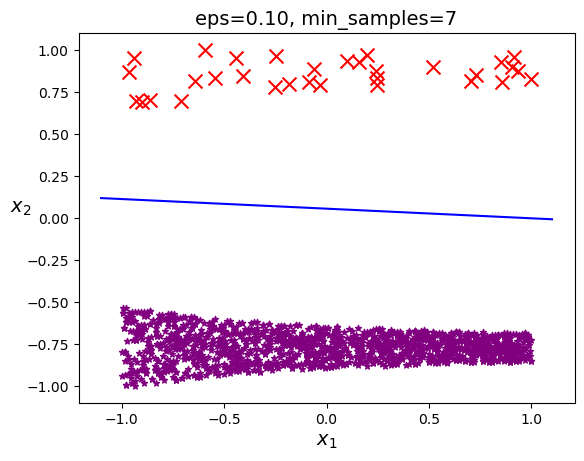

In [257]:
plot_predictions2(linear_svm, dbscan, real_data_power_20, size= 100)